In [1]:
!pip install pydicom
!pip install pylidc
!pip install torchsummary
!pip install imageio
!pip install gsutil

     |████████████████████████████████| 2.0 MB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 30.2 MB 73.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 66.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 71.4 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 98.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.3 MB 54.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 61.0 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 109.7 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.2.0
    Uninstalling Pillow-8.2.0:
      Successfully uninstalled Pillow-8.2.0
     |████████████████████████████████| 2.9 MB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 14.0 MB/s eta 0:00:01
     |████████████████████████████████| 135 kB 74.2 MB/s eta 0:00:01
     |████████████████

In [2]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import contextlib
import matplotlib.patches as patches
import os
import imageio
import sys

In [3]:
def set_dicom_path(dicom_path):
    f = open ('/root/.pylidcrc','w')    #For Colab
    f.write('[dicom]'+'\n')
    f.write('path =' + dicom_path +'\n')
    f.write('warn = True')
    f.close()

In [4]:
import matplotlib.patches as patches
def get_bounding_box(img):
    minx = []
    miny = []
    maxx = []
    maxy = []
    contours = find_contours(img.astype(float), 0.5)
    for contour in contours:
        minx.append(np.min(contour[:,1]))
        maxx.append(np.max(contour[:,1]))
        miny.append(np.min(contour[:,0]))
        maxy.append(np.max(contour[:,0]))
        
    if len(minx) > 0:
        return [(a, b, w-a, h-b) for a, b, w, h in zip(minx, miny, maxx, maxy)]
    else:
        return None
    
def plot_bounding_box(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    
    boxes = get_bounding_box(img)
    if boxes:
        for box in boxes:
            x,y,w,h = box
            print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

In [5]:
def find_all_bboxes(nodule_annotation, nodule_id, plot=False):
    bboxes = []
    #cmask, cbbox, masks = consensus(nodule_annotation)
    
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient {} is {}".format(patient_id, nodule_num))
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask
        

    print("There are {} slices in the image".format(cbbox_CT[nodule_id][2].stop - cbbox_CT[nodule_id][2].start))
    for idx in np.arange(cbbox_CT[nodule_id][2].start, cbbox_CT[nodule_id][2].stop):
        boxes = get_bounding_box(CT_mask[:,:,idx])
        if plot:
            plot_bounding_box(CT_mask[:,:,idx])
        bboxes.append(boxes)
    return bboxes

In [6]:
def plot_bbox_on_full_size_mask(vol, nodules_annotation, nodule_id):
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient is {}".format(nodule_num))
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask
        
    for slice_idx in np.arange(cbbox_CT[nodule_id][2].start, cbbox_CT[nodule_id][2].stop):
        plot_bounding_box(CT_mask[:,:,slice_idx])

In [7]:
def plot_bbox_on_image(vol, nodules_annotation, nodule_id):
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient is {}".format(nodule_num))
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask
        
    for slice_idx in np.arange(cbbox_CT[nodule_id][2].start, cbbox_CT[nodule_id][2].stop):
        boxes = get_bounding_box(CT_mask[:,:,slice_idx])
        img = vol[:,:,slice_idx]
        fig, ax = plt.subplots()
        ax.imshow(img, cmap=plt.cm.gray)
        if boxes:
            for box in boxes:
                x, y, w, h = box
                print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
                rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

In [8]:
import shutil
def clear_dirs(paths):
    for path in paths:
        if os.path.isdir(path):
            shutil.rmtree(path)

In [9]:
class RedirectStdStreams(object):
    def __init__(self, stdout=None, stderr=None):
        self._stdout = stdout or sys.stdout
        self._stderr = stderr or sys.stderr

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr

In [10]:
def un(a, b):
    return np.union1d(a, b)

def unr(ll, acc, i):
    if i < len(ll):
        j = i + 1
        acc = un(ll[i], acc)
        return unr(ll, acc, j)
    else:
        return acc

def get_slices_with_masks(cbbox_CT):
    ll = []
    for cb in cbbox_CT:
        ll.append(np.arange(cb[2].start, cb[2].stop+1))
    return unr(ll, [], 0)

In [171]:

#patient_id = patient_list_test[0]

def load_patient_vol_and_mask(dicom_dir, patient_id=-1):
    
    f = open ('/root/.pylidcrc','w')    #For Colab
    f.write('[dicom]'+'\n')
    f.write('path =' + dicom_dir +'\n')
    f.write('warn = True')
    f.close()

    patient_list = os.listdir(dicom_dir)
    if patient_id == -1: #select one randomly
        patient_id = np.random.choice(patient_list)
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    try:
        #with RedirectStdStreams(stdout=devnull, stderr=devnull):
        vol = scan.to_volume()
    except:
        print("Error loading DICOM for patient {}".format(patient_id))
        return None, None, None, None
    # are there nodules that are useful?

    # process the mask for the image
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        if len(nodule) >= 4:
            cmask, cbbox, masks = consensus(nodule)
            cmask_CT.append(cmask)
            cbbox_CT.append(cbbox)
            masks_CT.append(masks)

    if len(cbbox_CT) <=0:
        print("No relevant nodules for patient {}".format(patient_id))
        return None, None, None, None


    # create the mask voxel
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)

    #print("Number of nodules {}".format(nodule_num))
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask

    # get the slices that have annotations
    slices_with_mask = get_slices_with_masks(cbbox_CT)
    
    return vol, CT_mask, cbbox_CT, slices_with_mask

In [12]:
def plot_side_by_side(vol, mask, idx):
    f, a = plt.subplots(1,2, figsize=(8,10))
    a[0].imshow(vol[:,:,idx])
    a[1].imshow(mask[:,:,idx])
    plt.show()

# get 8 pixels along all axes
def plot_side_by_side_cropped(cbbox, vol, mask, idx):
    f, a = plt.subplots(1,2, figsize=(8,10))
    a[0].imshow(vol[cbbox[0],cbbox[1],cbbox[2]][:,:,idx])
    a[1].imshow(mask[cbbox[0],cbbox[1],cbbox[2]][:,:,idx])
    plt.show()

#### Generate data for Unet

- Select patients from the dicom dir
- for each patient, load the volumes and masks
    - Choose only those nodules that are annotated by more than 4 radiologists
    - Select only those slices from the DICOM image which has annotated masks
    - For each of those slices, extract a cropped 64x64 image around the mask with the annotated bounding box in the center
    - Also generate at least one 64x64 image with the center randomly chosen in the annotated bounding box

In [13]:
# take 32 pixels including c_x on each axis
def get_stride(c):
    start = 0
    if (c - 32) > 0:
        start = c - 32
    else:
        start = 0
    if (c + 32) < 512:
        stop = c + 32
    else:
        stop = 512
    return slice(start, stop, None)

"""
    Get a 64x64 image around the nodule, when using random = false, we get the actual clip of the annotated nodule,
    when using random = true, get a 64x64 image around the nodule randomly chosen which may or may not show a part of the nodule
"""
def get_nodule_part(cbbox, random=False):
    # extract 64x64 size images from the image randomly including the mask
    c_x = int(cbbox[0].start + (cbbox[0].stop - cbbox[0].start)/2)
    c_y = int(cbbox[1].start + (cbbox[1].stop - cbbox[1].start)/2)
    #print(c_x, c_y)
    if random: # random center within 64x64 box
        c_x = np.random.choice(np.arange(cbbox[0].start, cbbox[0].stop))
        c_y = np.random.choice(np.arange(cbbox[1].start, cbbox[1].stop))
    return get_stride(c_x), get_stride(c_y), cbbox[2]

"""
    Get a 64x64 image just outside the  
"""
def get_outside_part(cbbox, random=False):
    # extract 64x64 size images from the image randomly including the mask
    c_x = int(cbbox[0].start + (cbbox[0].stop - cbbox[0].start)/2)
    c_y = int(cbbox[1].start + (cbbox[1].stop - cbbox[1].start)/2)
    #print(c_x, c_y)
    if random: # random center within 64x64 box
        c_x = np.random.choice(np.arange(cbbox[0].start, cbbox[0].stop))
        c_y = np.random.choice(np.arange(cbbox[1].start, cbbox[1].stop))
    return get_stride(c_x), get_stride(c_y), cbbox[2]

In [14]:
def in_box(coord):
    return (coord[0] + 32 < 512) and (coord[0] - 32 > 0) and (coord[1] + 32 < 512) and (coord[1] - 32 > 0)

"""
    Takes multiple bounding boxes and returns slices for each of them, converts box to slice
    sample data: boxes = [(285.5, 280.5, 6.0, 5.0)]
"""
def get_slices(boxes, flipxy=True):
    slices = []
    for box in boxes:
        if flipxy:
            x = int(box[1])
            w = x + int(box[2])
            y = int(box[0])
            h = y + int(box[3])
            slices.append((slice(x, w, None), slice(y, h, None)))
        else:
            x = int(box[0])
            w = x + int(box[2])
            y = int(box[1])
            h = y + int(box[3])
            # slices.append((slice(x, w, None), slice(y, h, None)))
            # add 1 pixel margin to handle issues due to float values flooring from box
            slices.append((slice(y-1, h+1, None), slice(x-1, w+1, None)))
    return slices


# get boxes outside of this slice, get a 64x64 box just outside these slices
def get_all_box_centers(slices, shift):
    coords = []
    for slc in slices:
        xslc = slc[1]
        yslc = slc[0]
        coords.extend([a for a in zip(np.repeat(xslc.start - shift, yslc.stop-yslc.start), np.arange(yslc.start, yslc.stop))])
        coords.extend([a for a in zip(np.repeat(xslc.stop + shift, yslc.stop-yslc.start), np.arange(yslc.start, yslc.stop))])
        coords.extend([a for a in zip(np.arange(xslc.start, xslc.stop), np.repeat(yslc.stop + shift, xslc.stop-xslc.start))])
        coords.extend([a for a in zip(np.arange(xslc.start, xslc.stop), np.repeat(yslc.start - shift, xslc.stop-xslc.start))])
        coords = [crd for crd in coords if in_box(crd)]
    return coords

def get_random_slices(coords, num_select=1):
    slices = []
    idxs = np.random.choice(np.arange(len(coords)), num_select)
    for idx in idxs:
        x, y = coords[idx]
        #slices.append((slice(x-32,x+32, None), slice(y-32, y+32, None)))
        slices.append((slice(y-32, y+32, None), slice(x-32,x+32, None)))
    return slices

In [15]:
def save_surrounding_images(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, image_save=False, image_plot=True):
    devnull = open(os.devnull, 'w')
    if image_save:
        assert os.path.exists(root_dir)
        image_dir = root_dir + '/images/'
        mask_dir = root_dir + '/masks/'
        assert os.path.exists(image_dir)
        assert os.path.exists(mask_dir)
    slcz = bounding_box[nodule_number][2]
    unique_slice_ids = np.arange(slcz.start, slcz.stop)
    voxel = CT_mask[:,:,bounding_box[nodule_number][2]]
    img_voxel = vol[:,:,bounding_box[nodule_number][2]]
    out_masks = []
    out_images = []
    out_slices = None
    for slice_id in range(voxel.shape[2]):
        boxes = get_bounding_box(voxel[:,:,slice_id])
        if boxes is None:
            print("No bounding box for {} and slice {}".format(patient_id, slice_id))
            continue
        slices = get_slices(boxes, False)
        coords = get_all_box_centers(slices, 34)
        out_slices = get_random_slices(coords, 2) # get 3 random 64x64 images randomly from the image that does not show the mask (i.e., negative samples)
        out_slices = [out_slice + (bounding_box[nodule_number][2],) for out_slice in out_slices]
        for out_slice in out_slices:
            out_masks.append(voxel[:,:,slice_id][(out_slice[0],out_slice[1])])
            out_images.append(img_voxel[:,:,slice_id][(out_slice[0],out_slice[1])])
    
#     for idx, mask in enumerate(out_masks):
#         assert mask.shape[2] == len(unique_slice_ids)
#         if len(np.unique(mask)) < 1:
    b = []
    for a1 in unique_slice_ids:
        b.extend(np.repeat(a1, 2))
    for idx, (unique_slice_id, mask)in enumerate(zip(b, out_masks)):
        img = out_images[idx]
        mask = out_masks[idx]
        if img.shape != (64, 64):
            continue
        if mask.shape != (64, 64):
            continue
        if len(np.unique(mask)) > 1:
            continue
        if image_save:
                #TODO: generate unique file names
                image_file_name = "img_out_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, idx, unique_slice_id)
                mask_file_name = "mask_out_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, idx, unique_slice_id)
                with RedirectStdStreams(stdout=devnull, stderr=devnull):
                    imageio.imwrite(image_dir + image_file_name, img)
                with RedirectStdStreams(stdout=devnull, stderr=devnull):    
                    imageio.imwrite(mask_dir + mask_file_name, mask)
        if image_plot:
            f, a =  plt.subplots(1,2, figsize=(8,10))
            a[0].imshow(img)
            a[0].set_title("img_out_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, idx, unique_slice_id))
            a[1].imshow(mask)
            plt.show()
                
                
#     for i in range(len(out_masks)):
#         assert out_masks[i].shape[2] == len(unique_slice_ids)
#         for slice_id, unique_slice_id in zip(range(out_masks[i].shape[2]), unique_slice_ids):
#         #for slice_id in unique_slice_ids:
#             img = out_images[i][:,:,slice_id]
#             mask = out_masks[i][:,:, slice_id]
#             if image_save:
#                 #TODO: generate unique file names
#                 image_file_name = "img_out_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, i, unique_slice_id)
#                 mask_file_name = "mask_out_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, i, unique_slice_id)
#                 with RedirectStdStreams(stdout=devnull, stderr=devnull):
#                     imageio.imwrite(image_dir + image_file_name, img)
#                 with RedirectStdStreams(stdout=devnull, stderr=devnull):    
#                     imageio.imwrite(mask_dir + mask_file_name, mask)
#             if image_plot:
#                 f, a =  plt.subplots(1,2, figsize=(8,10))
#                 a[0].imshow(img)
#                 a[0].set_title("img_out_{}_{}_{}_{}.jpg".format(patient_id, nodule_number, i, unique_slice_id))
#                 a[1].imshow(mask)
#                 plt.show()

In [16]:
def validate_surrounding_images(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, image_save=False, image_plot=True):
    devnull = open(os.devnull, 'w')
    if image_save:
        assert os.path.exists(root_dir)
        image_dir = root_dir + '/images/'
        mask_dir = root_dir + '/masks/'
        assert os.path.exists(image_dir)
        assert os.path.exists(mask_dir)
    slcz = bounding_box[nodule_number][2]
    unique_slice_ids = np.arange(slcz.start, slcz.stop)
    voxel = CT_mask[:,:,bounding_box[nodule_number][2]]
    img_voxel = vol[:,:,bounding_box[nodule_number][2]]
    out_masks = []
    out_images = []
    out_slices = None
    #print("voxel shape 2 = {}".format(voxel.shape[2]))
    for slice_id in range(voxel.shape[2]):
        boxes = get_bounding_box(voxel[:,:,slice_id])
        if boxes is None:
            print("No bounding box for {} and slice {}".format(patient_id, slice_id))
            continue
        slices = get_slices(boxes, False)
        coords = get_all_box_centers(slices, 34)
        out_slices = get_random_slices(coords, 3) # get 3 random 64x64 images randomly from the image that does not show the mask (i.e., negative samples)
        out_slices = [out_slice + (bounding_box[nodule_number][2],) for out_slice in out_slices]
        #out_slices = [(slice(y-32, y+32, None), slice(x-32, x+32, None), bounding_box[nodule_number][2]) for x,y in coords]
        for out_slice in out_slices:
            out_masks.append(voxel[:,:,slice_id][(out_slice[0],out_slice[1])])
            out_images.append(img_voxel[:,:,slice_id][(out_slice[0],out_slice[1])])
#             out_masks.append(CT_mask[out_slice])
#             out_images.append(vol[out_slice])
    
    errors = []
    cnt = 0
    #print("Unique slices = {}".format(len(unique_slice_ids)))
    b=[]
    for a1 in unique_slice_ids:
        b.extend(np.repeat(a1, 3))
    for idx, (slice1, mask )in enumerate(zip(b, out_masks)):
        print("{}_{}_{}_{}".format(slice1,patient_id, nodule_number, idx))
        if len(np.unique(mask)) > 1:
            s = (np.sum(mask), idx, patient_id, nodule_number, unique_slice_id)
            errors.append(s)
        cnt += 1
    return errors, cnt

In [17]:
"""
    Save the nodule image and at least one more random image with the nodule visible 
    but not identical to the nodule image
"""
def save_image_foreach_slice(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, image_save=False, image_plot=True):
    devnull = open(os.devnull, 'w')
    if image_save:
        assert os.path.exists(root_dir)
        image_dir = root_dir + '/images/'
        mask_dir = root_dir + '/masks/'
        assert os.path.exists(image_dir)
        assert os.path.exists(mask_dir)
    slcz = bounding_box[nodule_number][2]
    unique_slice_ids = np.arange(slcz.start, slcz.stop)
    slc = get_nodule_part(bounding_box[nodule_number], random)

    assert len(unique_slice_ids) == len(range(slc[2].stop - slc[2].start))
    for slice_index, unique_slice_id in zip(range(slc[2].stop - slc[2].start),unique_slice_ids):
        img = vol[slc[0],slc[1],slc[2]][:,:,slice_index]
        mask = CT_mask[slc[0],slc[1],slc[2]][:,:,slice_index]
        if img.shape != (64, 64):
            continue
        if mask.shape != (64, 64):
            continue
        if image_save:
            if random:
                image_file_name = "img_random_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
                mask_file_name = "mask_random_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
            else:
                image_file_name = "img_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
                mask_file_name = "mask_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
            with RedirectStdStreams(stdout=devnull, stderr=devnull):
                imageio.imwrite(image_dir + image_file_name, img)
            with RedirectStdStreams(stdout=devnull, stderr=devnull):
                imageio.imwrite(mask_dir + mask_file_name, mask)
        if image_plot:
            f, a =  plt.subplots(1,2, figsize=(8,10))
            a[0].imshow(img)
            if random:
                a[0].set_title("img_random_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id))
            else:
                a[0].set_title("img_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id))
            a[1].imshow(mask)
            plt.show()

Loading dicom files ... This may take a moment.
There are 2 nodules


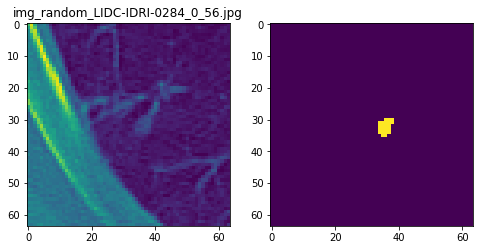

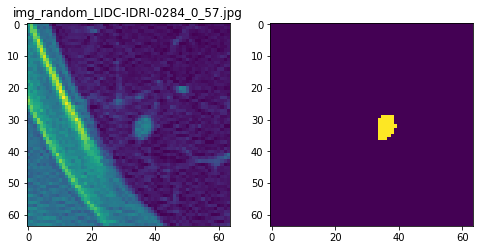

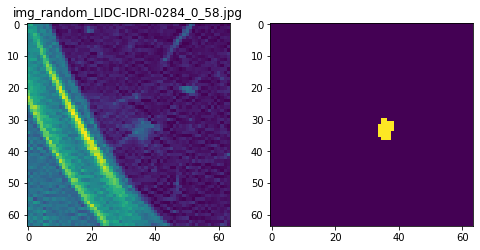

In [143]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/rawdata/train/sorted_gcsfiles', 'LIDC-IDRI-0284')
print("There are {} nodules".format(len(cbbox)))
save_image_foreach_slice(root_dir='/data/unet/train/', patient_id='LIDC-IDRI-0284', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=True, image_plot=True)

In [154]:
vol.shape != (512, 512, 133)

False

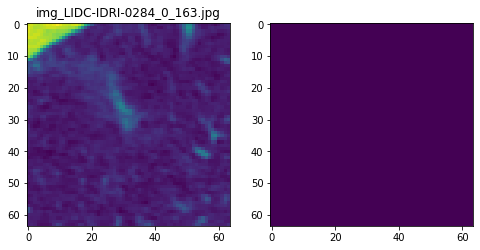

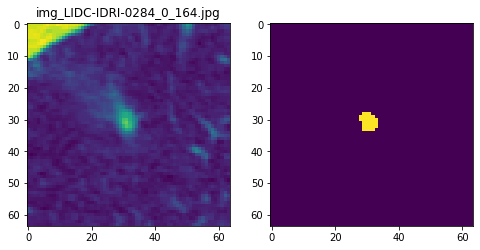

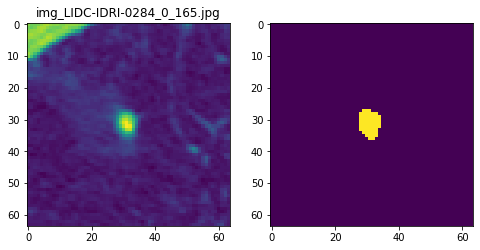

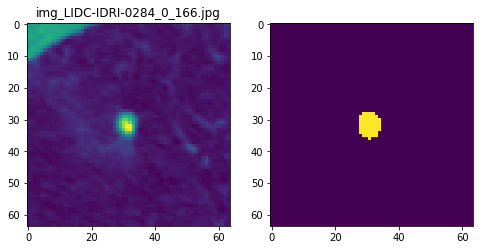

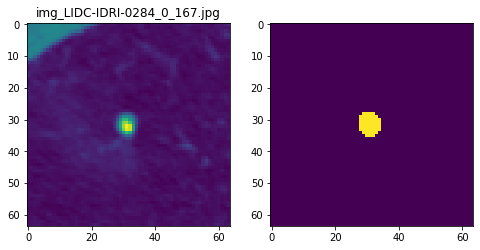

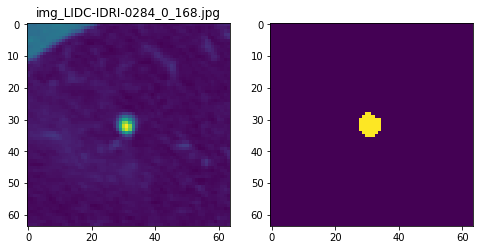

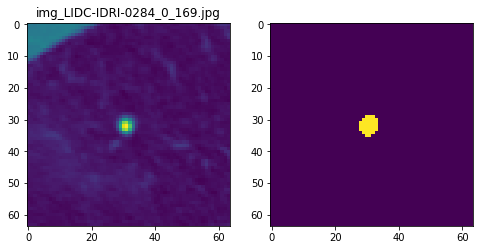

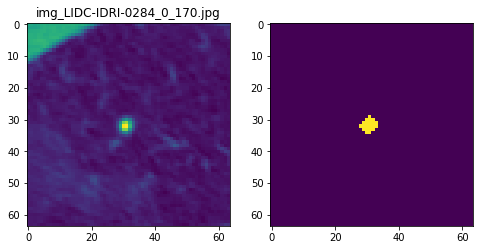

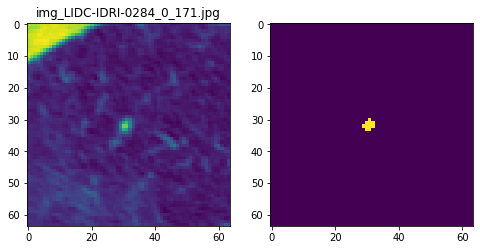

In [232]:
save_image_foreach_slice(root_dir='/data/unet/train/', patient_id='LIDC-IDRI-0284', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=False, image_save=True, image_plot=True)

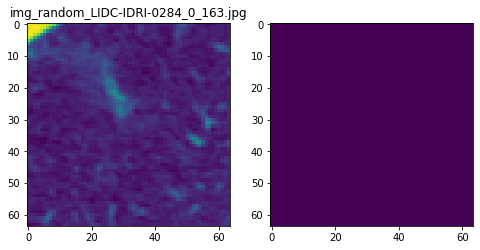

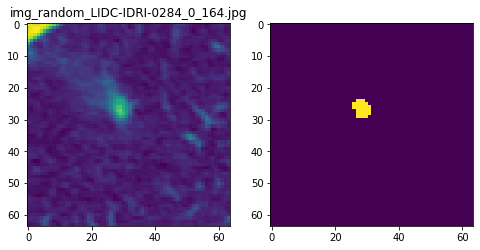

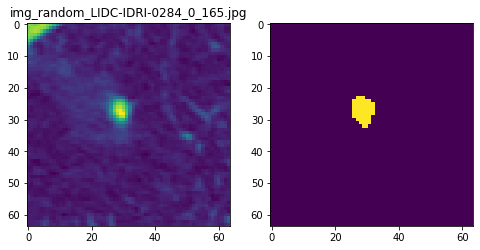

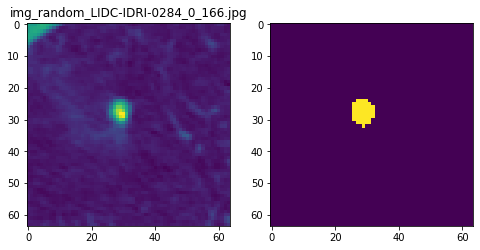

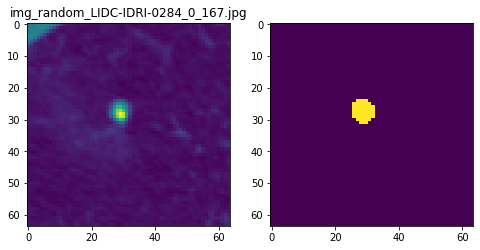

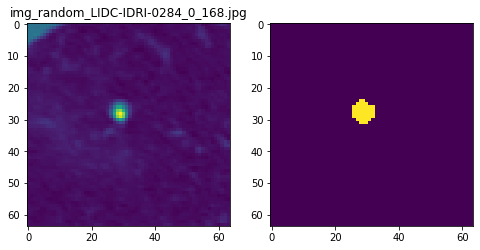

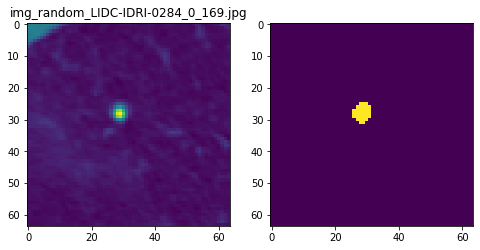

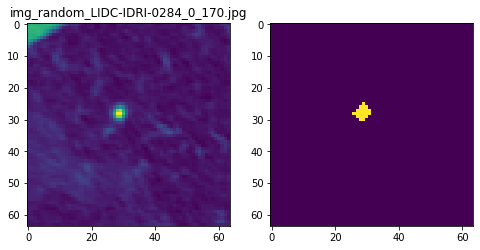

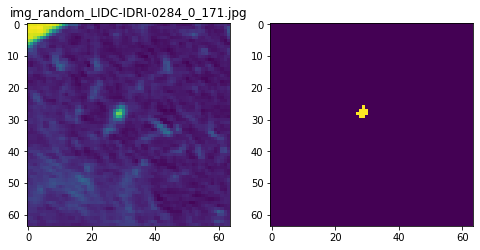

In [233]:
save_image_foreach_slice(root_dir='/data/unet/train/', patient_id='LIDC-IDRI-0284', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=True, image_plot=True)

No bounding box for LIDC-IDRI-0284 and slice 0


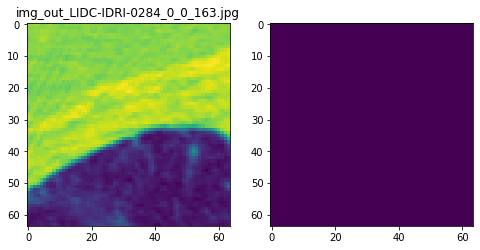

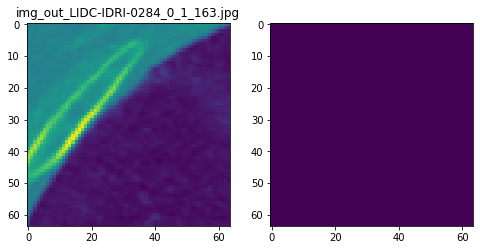

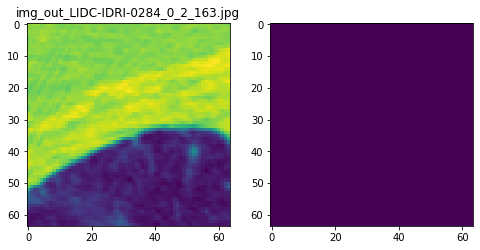

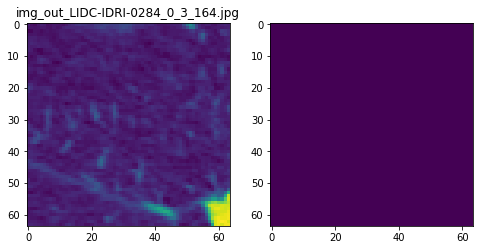

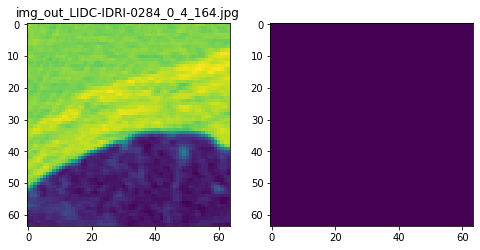

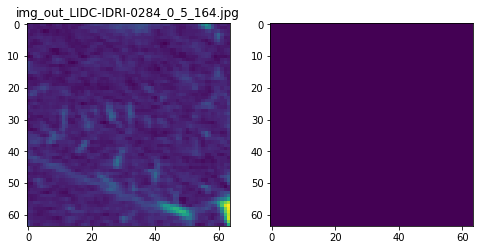

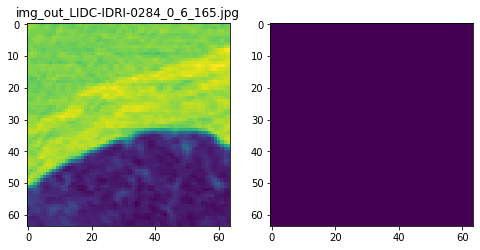

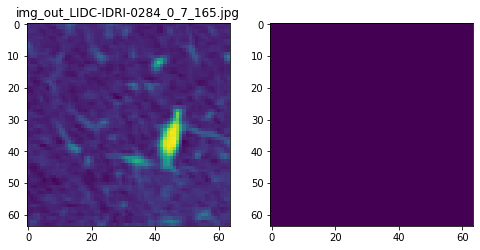

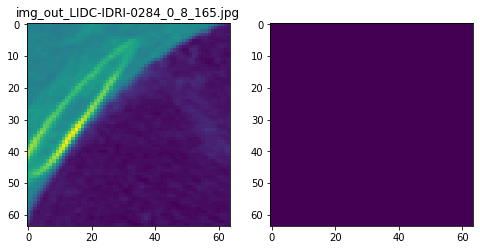

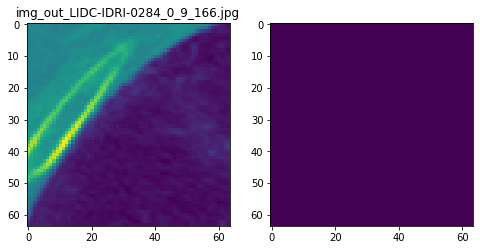

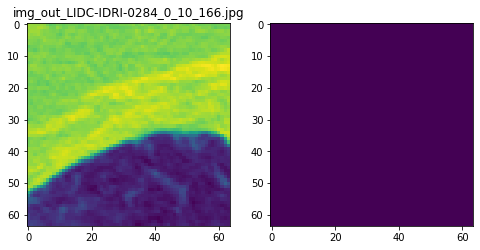

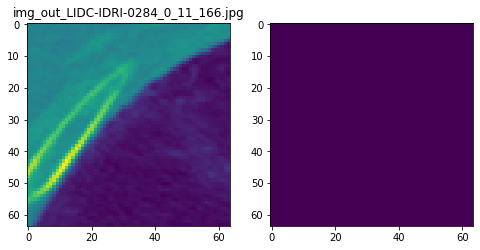

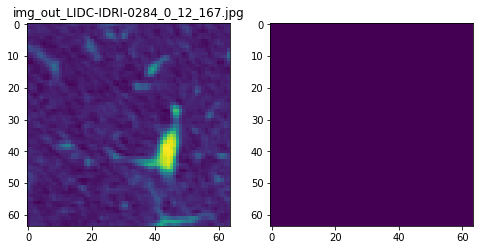

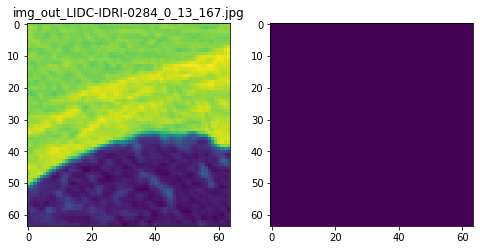

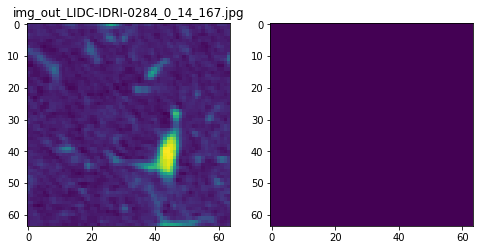

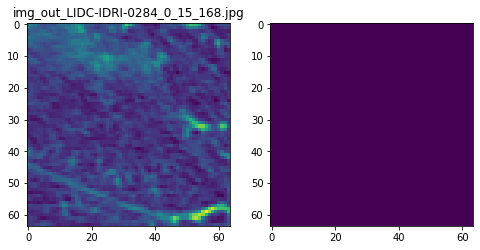

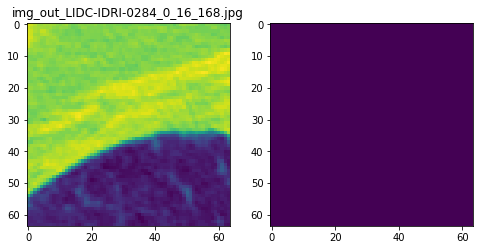

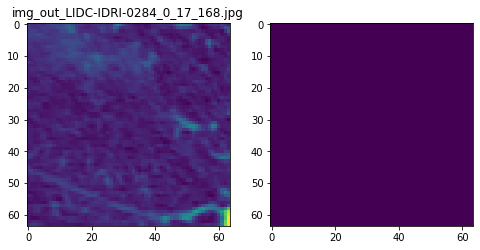

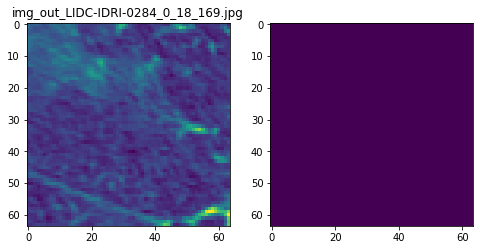

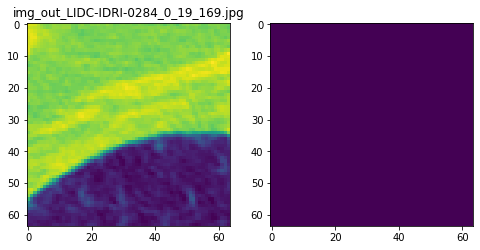

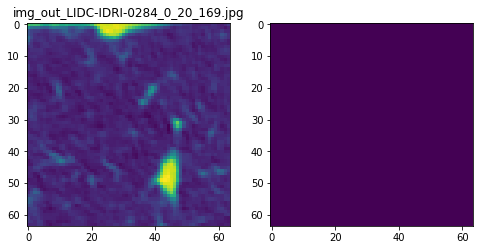

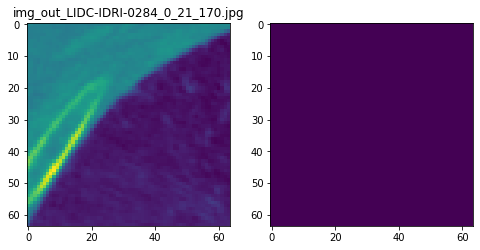

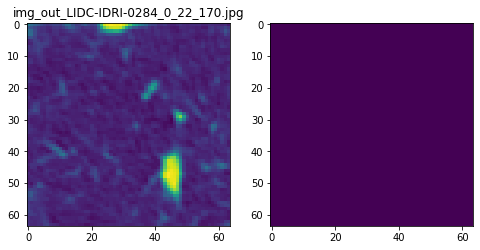

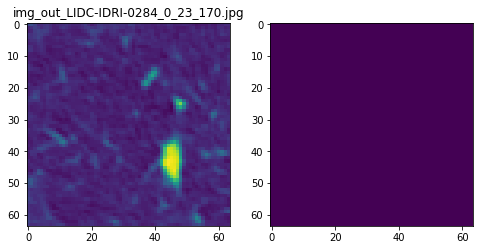

In [234]:
save_surrounding_images(root_dir='/data/unet/train/', patient_id='LIDC-IDRI-0284', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, random=True, image_save=True, image_plot=True)

In [18]:
def save_generated_images_for_patient(root_dir='/data/unet/train/', dicom_dir='/rawdata/train/sorted_gcsfiles', patient_id='LIDC-IDRI-0284'):
    vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask(dicom_dir, patient_id)
    if cbbox:
        for nodule_num in range(len(cbbox)):
            save_image_foreach_slice(root_dir=root_dir, patient_id=patient_id, bounding_box=cbbox, nodule_number=nodule_num,  
                                 vol=vol, CT_mask=CT_mask, random=True, image_save=True, image_plot=False)
            save_image_foreach_slice(root_dir=root_dir, patient_id=patient_id, bounding_box=cbbox, nodule_number=nodule_num,  
                             vol=vol, CT_mask=CT_mask, random=False, image_save=True, image_plot=False)
            save_surrounding_images(root_dir=root_dir, patient_id=patient_id, bounding_box=cbbox, nodule_number=nodule_num,  
                             vol=vol, CT_mask=CT_mask, random=True, image_save=True, image_plot=False)

In [172]:
patients = os.listdir('/rawdata/train/sorted_gcsfiles')
for pat in tqdm(patients):
    save_generated_images_for_patient(root_dir='/data/unet/train/', dicom_dir='/rawdata/train/sorted_gcsfiles', patient_id=pat)

  0%|                                                                                                                                  | 0/696 [00:00<?, ?it/s]

Loading dicom files ... This may take a moment.


  0%|▏                                                                                                                         | 1/696 [00:01<19:35,  1.69s/it]

No relevant nodules for patient LIDC-IDRI-0971
Loading dicom files ... This may take a moment.


  0%|▎                                                                                                                         | 2/696 [00:05<33:48,  2.92s/it]

No relevant nodules for patient LIDC-IDRI-0856
Loading dicom files ... This may take a moment.


  0%|▌                                                                                                                         | 3/696 [00:09<39:08,  3.39s/it]

No relevant nodules for patient LIDC-IDRI-0826
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0375 and slice 0
No bounding box for LIDC-IDRI-0375 and slice 15


  1%|▋                                                                                                                         | 4/696 [00:13<40:53,  3.55s/it]

Loading dicom files ... This may take a moment.


  1%|▉                                                                                                                         | 5/696 [00:15<34:22,  2.99s/it]

Loading dicom files ... This may take a moment.


  1%|█                                                                                                                         | 6/696 [00:16<26:56,  2.34s/it]

No relevant nodules for patient LIDC-IDRI-0584
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0315 and slice 0


  1%|█▏                                                                                                                        | 7/696 [00:18<25:52,  2.25s/it]

Loading dicom files ... This may take a moment.


  1%|█▍                                                                                                                        | 8/696 [00:20<25:23,  2.21s/it]

No relevant nodules for patient LIDC-IDRI-0859
Loading dicom files ... This may take a moment.


  1%|█▌                                                                                                                        | 9/696 [00:21<21:42,  1.90s/it]

Loading dicom files ... This may take a moment.


  1%|█▋                                                                                                                       | 10/696 [00:23<22:34,  1.98s/it]

Loading dicom files ... This may take a moment.


  2%|█▉                                                                                                                       | 11/696 [00:25<21:15,  1.86s/it]

No relevant nodules for patient LIDC-IDRI-0654
Loading dicom files ... This may take a moment.


  2%|██                                                                                                                       | 12/696 [00:26<18:45,  1.65s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0347 and slice 0
No bounding box for LIDC-IDRI-0347 and slice 0
No bounding box for LIDC-IDRI-0347 and slice 5
No bounding box for LIDC-IDRI-0347 and slice 6


  2%|██▎                                                                                                                      | 13/696 [00:28<19:26,  1.71s/it]

Loading dicom files ... This may take a moment.


  2%|██▍                                                                                                                      | 14/696 [00:30<20:45,  1.83s/it]

No relevant nodules for patient LIDC-IDRI-0662
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0620 and slice 0


  2%|██▌                                                                                                                      | 15/696 [00:32<22:37,  1.99s/it]

Loading dicom files ... This may take a moment.


  2%|██▊                                                                                                                      | 16/696 [00:34<19:26,  1.72s/it]

Loading dicom files ... This may take a moment.


  2%|██▉                                                                                                                      | 17/696 [00:35<17:27,  1.54s/it]

No relevant nodules for patient LIDC-IDRI-0670
Loading dicom files ... This may take a moment.


  3%|███▏                                                                                                                     | 18/696 [00:36<15:26,  1.37s/it]

No relevant nodules for patient LIDC-IDRI-0157
Loading dicom files ... This may take a moment.


  3%|███▎                                                                                                                     | 19/696 [00:38<20:22,  1.81s/it]

Loading dicom files ... This may take a moment.


  3%|███▍                                                                                                                     | 20/696 [00:41<21:46,  1.93s/it]

No relevant nodules for patient LIDC-IDRI-0019
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0310 and slice 0


  3%|███▋                                                                                                                     | 21/696 [00:42<18:34,  1.65s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0686 and slice 7
No bounding box for LIDC-IDRI-0686 and slice 0


  3%|███▊                                                                                                                     | 22/696 [00:49<39:23,  3.51s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0276 and slice 0
No bounding box for LIDC-IDRI-0276 and slice 4


  3%|███▉                                                                                                                     | 23/696 [00:51<32:45,  2.92s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0604 and slice 7
No bounding box for LIDC-IDRI-0604 and slice 5


  3%|████▏                                                                                                                    | 24/696 [00:57<42:35,  3.80s/it]

Loading dicom files ... This may take a moment.


  4%|████▎                                                                                                                    | 25/696 [01:01<41:57,  3.75s/it]

No relevant nodules for patient LIDC-IDRI-0575
Loading dicom files ... This may take a moment.


  4%|████▌                                                                                                                    | 26/696 [01:02<33:30,  3.00s/it]

No relevant nodules for patient LIDC-IDRI-0680
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0919 and slice 16


  4%|████▋                                                                                                                    | 27/696 [01:05<33:06,  2.97s/it]

Loading dicom files ... This may take a moment.


  4%|████▊                                                                                                                    | 28/696 [01:08<33:14,  2.99s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0204 and slice 0
No bounding box for LIDC-IDRI-0204 and slice 1
No bounding box for LIDC-IDRI-0204 and slice 13


  4%|█████                                                                                                                    | 29/696 [01:10<29:29,  2.65s/it]

Loading dicom files ... This may take a moment.


  4%|█████▏                                                                                                                   | 30/696 [01:12<27:24,  2.47s/it]

No relevant nodules for patient LIDC-IDRI-0457
Loading dicom files ... This may take a moment.


  4%|█████▍                                                                                                                   | 31/696 [01:13<23:45,  2.14s/it]

Loading dicom files ... This may take a moment.


  5%|█████▌                                                                                                                   | 32/696 [01:18<33:45,  3.05s/it]

No relevant nodules for patient LIDC-IDRI-0839
Loading dicom files ... This may take a moment.


  5%|█████▋                                                                                                                   | 33/696 [01:21<31:40,  2.87s/it]

No relevant nodules for patient LIDC-IDRI-0979
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0068 and slice 0
No bounding box for LIDC-IDRI-0068 and slice 9


  5%|█████▉                                                                                                                   | 34/696 [01:26<38:40,  3.50s/it]

Loading dicom files ... This may take a moment.


  5%|██████                                                                                                                   | 35/696 [01:27<31:48,  2.89s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0184 and slice 3


  5%|██████▎                                                                                                                  | 36/696 [01:29<27:43,  2.52s/it]

Loading dicom files ... This may take a moment.


  5%|██████▍                                                                                                                  | 37/696 [01:31<27:21,  2.49s/it]

No relevant nodules for patient LIDC-IDRI-0180
Loading dicom files ... This may take a moment.


  5%|██████▌                                                                                                                  | 38/696 [01:37<37:16,  3.40s/it]

No relevant nodules for patient LIDC-IDRI-0397
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0624 and slice 0
No bounding box for LIDC-IDRI-0624 and slice 1
No bounding box for LIDC-IDRI-0624 and slice 2
No bounding box for LIDC-IDRI-0624 and slice 20


  6%|██████▊                                                                                                                  | 39/696 [01:41<40:24,  3.69s/it]

Loading dicom files ... This may take a moment.


  6%|██████▉                                                                                                                  | 40/696 [01:46<44:40,  4.09s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0568 and slice 0
No bounding box for LIDC-IDRI-0568 and slice 4


  6%|███████▏                                                                                                                 | 41/696 [01:50<43:57,  4.03s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0998 and slice 3


  6%|███████▎                                                                                                                 | 42/696 [01:53<39:10,  3.59s/it]

Loading dicom files ... This may take a moment.


  6%|███████▍                                                                                                                 | 43/696 [01:55<36:29,  3.35s/it]

No relevant nodules for patient LIDC-IDRI-0291
Loading dicom files ... This may take a moment.


  6%|███████▋                                                                                                                 | 44/696 [01:58<34:10,  3.15s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0244 and slice 2


  6%|███████▊                                                                                                                 | 45/696 [02:00<30:25,  2.80s/it]

Loading dicom files ... This may take a moment.


  7%|███████▉                                                                                                                 | 46/696 [02:01<24:51,  2.29s/it]

No relevant nodules for patient LIDC-IDRI-0927
Loading dicom files ... This may take a moment.


  7%|████████▏                                                                                                                | 47/696 [02:04<25:19,  2.34s/it]

No relevant nodules for patient LIDC-IDRI-0307
Loading dicom files ... This may take a moment.


  7%|████████▎                                                                                                                | 48/696 [02:05<23:44,  2.20s/it]

No relevant nodules for patient LIDC-IDRI-0885
Loading dicom files ... This may take a moment.


  7%|████████▌                                                                                                                | 49/696 [02:07<20:48,  1.93s/it]

No relevant nodules for patient LIDC-IDRI-0677
Loading dicom files ... This may take a moment.


  7%|████████▋                                                                                                                | 50/696 [02:08<18:55,  1.76s/it]

No relevant nodules for patient LIDC-IDRI-0261
Loading dicom files ... This may take a moment.


  7%|████████▊                                                                                                                | 51/696 [02:12<25:00,  2.33s/it]

Loading dicom files ... This may take a moment.


  7%|█████████                                                                                                                | 52/696 [02:13<22:50,  2.13s/it]

No relevant nodules for patient LIDC-IDRI-0666
Loading dicom files ... This may take a moment.


  8%|█████████▏                                                                                                               | 53/696 [02:18<30:43,  2.87s/it]

No relevant nodules for patient LIDC-IDRI-0468
Loading dicom files ... This may take a moment.


  8%|█████████▍                                                                                                               | 54/696 [02:19<26:02,  2.43s/it]

No relevant nodules for patient LIDC-IDRI-0243
Loading dicom files ... This may take a moment.


  8%|█████████▌                                                                                                               | 55/696 [02:21<24:13,  2.27s/it]

Loading dicom files ... This may take a moment.


  8%|█████████▋                                                                                                               | 56/696 [02:24<25:33,  2.40s/it]

No relevant nodules for patient LIDC-IDRI-0736
Loading dicom files ... This may take a moment.


  8%|█████████▉                                                                                                               | 57/696 [02:26<24:12,  2.27s/it]

No relevant nodules for patient LIDC-IDRI-0852
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0348 and slice 0


  8%|██████████                                                                                                               | 58/696 [02:28<23:07,  2.18s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0016 and slice 5
No bounding box for LIDC-IDRI-0016 and slice 2
No bounding box for LIDC-IDRI-0016 and slice 0
No bounding box for LIDC-IDRI-0016 and slice 7


  8%|██████████▎                                                                                                              | 59/696 [02:31<26:06,  2.46s/it]

Loading dicom files ... This may take a moment.


  9%|██████████▍                                                                                                              | 60/696 [02:32<22:04,  2.08s/it]

No relevant nodules for patient LIDC-IDRI-0881
Loading dicom files ... This may take a moment.


  9%|██████████▌                                                                                                              | 61/696 [02:34<20:29,  1.94s/it]

Loading dicom files ... This may take a moment.


  9%|██████████▊                                                                                                              | 62/696 [02:38<27:10,  2.57s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0671 and slice 5


  9%|██████████▉                                                                                                              | 63/696 [02:42<32:28,  3.08s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0390 and slice 0
No bounding box for LIDC-IDRI-0390 and slice 3


  9%|███████████▏                                                                                                             | 64/696 [02:45<31:52,  3.03s/it]

Loading dicom files ... This may take a moment.


  9%|███████████▎                                                                                                             | 65/696 [02:49<36:24,  3.46s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0896 and slice 6


  9%|███████████▍                                                                                                             | 66/696 [02:52<32:08,  3.06s/it]

Loading dicom files ... This may take a moment.


 10%|███████████▋                                                                                                             | 67/696 [02:54<30:02,  2.87s/it]

No relevant nodules for patient LIDC-IDRI-0324
Loading dicom files ... This may take a moment.


 10%|███████████▊                                                                                                             | 68/696 [02:55<24:55,  2.38s/it]

No relevant nodules for patient LIDC-IDRI-0173
Loading dicom files ... This may take a moment.


 10%|███████████▉                                                                                                             | 69/696 [02:58<24:27,  2.34s/it]

No relevant nodules for patient LIDC-IDRI-0304
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0965 and slice 0


 10%|████████████▏                                                                                                            | 70/696 [03:02<30:33,  2.93s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0091 and slice 0
No bounding box for LIDC-IDRI-0091 and slice 6
No bounding box for LIDC-IDRI-0091 and slice 0
No bounding box for LIDC-IDRI-0091 and slice 11
No bounding box for LIDC-IDRI-0091 and slice 12


 10%|████████████▎                                                                                                            | 71/696 [03:05<32:33,  3.13s/it]

Loading dicom files ... This may take a moment.


 10%|████████████▌                                                                                                            | 72/696 [03:07<26:51,  2.58s/it]

No relevant nodules for patient LIDC-IDRI-0958
Loading dicom files ... This may take a moment.


 10%|████████████▋                                                                                                            | 73/696 [03:08<23:38,  2.28s/it]

No relevant nodules for patient LIDC-IDRI-0638
Loading dicom files ... This may take a moment.


 11%|████████████▊                                                                                                            | 74/696 [03:14<33:53,  3.27s/it]

Loading dicom files ... This may take a moment.


 11%|█████████████                                                                                                            | 75/696 [03:21<46:37,  4.50s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0379 and slice 4
No bounding box for LIDC-IDRI-0379 and slice 0
No bounding box for LIDC-IDRI-0379 and slice 0


 11%|█████████████▏                                                                                                           | 76/696 [03:23<39:25,  3.82s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-1002 and slice 0
No bounding box for LIDC-IDRI-1002 and slice 10


 11%|█████████████▍                                                                                                           | 77/696 [03:32<52:43,  5.11s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0751 and slice 0
No bounding box for LIDC-IDRI-0751 and slice 4
No bounding box for LIDC-IDRI-0751 and slice 10


 11%|█████████████▌                                                                                                           | 78/696 [03:36<49:34,  4.81s/it]

Loading dicom files ... This may take a moment.


 11%|█████████████▋                                                                                                           | 79/696 [03:40<46:27,  4.52s/it]

Loading dicom files ... This may take a moment.


 11%|█████████████▉                                                                                                           | 80/696 [03:41<35:43,  3.48s/it]

No relevant nodules for patient LIDC-IDRI-0062
Loading dicom files ... This may take a moment.


 12%|██████████████                                                                                                           | 81/696 [03:42<29:36,  2.89s/it]

Loading dicom files ... This may take a moment.


 12%|██████████████▎                                                                                                          | 82/696 [03:45<28:05,  2.74s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0929 and slice 4
No bounding box for LIDC-IDRI-0929 and slice 5


 12%|██████████████▍                                                                                                          | 83/696 [03:47<27:57,  2.74s/it]

Loading dicom files ... This may take a moment.


 12%|██████████████▌                                                                                                          | 84/696 [03:49<24:14,  2.38s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0759 and slice 0


 12%|██████████████▊                                                                                                          | 85/696 [03:51<22:54,  2.25s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0171 and slice 0
No bounding box for LIDC-IDRI-0171 and slice 1
No bounding box for LIDC-IDRI-0171 and slice 8
No bounding box for LIDC-IDRI-0171 and slice 2
No bounding box for LIDC-IDRI-0171 and slice 0


 12%|██████████████▉                                                                                                          | 86/696 [03:53<22:26,  2.21s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0111 and slice 0
No bounding box for LIDC-IDRI-0111 and slice 0
No bounding box for LIDC-IDRI-0111 and slice 0


 12%|███████████████▏                                                                                                         | 87/696 [03:56<24:18,  2.40s/it]

Loading dicom files ... This may take a moment.


 13%|███████████████▎                                                                                                         | 88/696 [03:59<27:07,  2.68s/it]

Loading dicom files ... This may take a moment.


 13%|███████████████▍                                                                                                         | 89/696 [04:00<22:51,  2.26s/it]

No relevant nodules for patient LIDC-IDRI-0414
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0021 and slice 0


 13%|███████████████▋                                                                                                         | 90/696 [04:02<21:28,  2.13s/it]

Loading dicom files ... This may take a moment.


 13%|███████████████▊                                                                                                         | 91/696 [04:06<25:53,  2.57s/it]

No relevant nodules for patient LIDC-IDRI-0870
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0089 and slice 10


 13%|███████████████▉                                                                                                         | 92/696 [04:08<23:46,  2.36s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0343 and slice 6
No bounding box for LIDC-IDRI-0343 and slice 7


 13%|████████████████▏                                                                                                        | 93/696 [04:09<21:32,  2.14s/it]

Loading dicom files ... This may take a moment.


 14%|████████████████▎                                                                                                        | 94/696 [04:10<18:42,  1.86s/it]

No relevant nodules for patient LIDC-IDRI-0143
Loading dicom files ... This may take a moment.


 14%|████████████████▌                                                                                                        | 95/696 [04:17<32:06,  3.21s/it]

No relevant nodules for patient LIDC-IDRI-0328
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0803 and slice 3


 14%|████████████████▋                                                                                                        | 96/696 [04:20<30:43,  3.07s/it]

Loading dicom files ... This may take a moment.


 14%|████████████████▊                                                                                                        | 97/696 [04:23<32:09,  3.22s/it]

No relevant nodules for patient LIDC-IDRI-0424
Loading dicom files ... This may take a moment.


 14%|█████████████████                                                                                                        | 98/696 [04:24<26:14,  2.63s/it]

No relevant nodules for patient LIDC-IDRI-0494
Loading dicom files ... This may take a moment.


 14%|█████████████████▏                                                                                                       | 99/696 [04:26<24:01,  2.41s/it]

Loading dicom files ... This may take a moment.


 14%|█████████████████▏                                                                                                      | 100/696 [04:31<32:09,  3.24s/it]

No relevant nodules for patient LIDC-IDRI-0293
Loading dicom files ... This may take a moment.


 15%|█████████████████▍                                                                                                      | 101/696 [04:33<26:22,  2.66s/it]

No relevant nodules for patient LIDC-IDRI-0891
Loading dicom files ... This may take a moment.


 15%|█████████████████▌                                                                                                      | 102/696 [04:36<27:02,  2.73s/it]

No relevant nodules for patient LIDC-IDRI-0888
Loading dicom files ... This may take a moment.


 15%|█████████████████▊                                                                                                      | 103/696 [04:40<33:04,  3.35s/it]

No relevant nodules for patient LIDC-IDRI-0669
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0527 and slice 0


 15%|█████████████████▉                                                                                                      | 104/696 [04:42<27:25,  2.78s/it]

Loading dicom files ... This may take a moment.


 15%|██████████████████                                                                                                      | 105/696 [04:45<27:08,  2.76s/it]

No relevant nodules for patient LIDC-IDRI-0783
Loading dicom files ... This may take a moment.


 15%|██████████████████▎                                                                                                     | 106/696 [04:47<26:09,  2.66s/it]

No relevant nodules for patient LIDC-IDRI-0774
Loading dicom files ... This may take a moment.


 15%|██████████████████▍                                                                                                     | 107/696 [04:48<22:33,  2.30s/it]

No relevant nodules for patient LIDC-IDRI-0035
Loading dicom files ... This may take a moment.


 16%|██████████████████▌                                                                                                     | 108/696 [04:50<20:49,  2.13s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0613 and slice 0


 16%|██████████████████▊                                                                                                     | 109/696 [04:54<24:52,  2.54s/it]

Loading dicom files ... This may take a moment.


 16%|██████████████████▉                                                                                                     | 110/696 [04:56<24:26,  2.50s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0855 and slice 0


 16%|███████████████████▏                                                                                                    | 111/696 [05:00<28:14,  2.90s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0298 and slice 0


 16%|███████████████████▎                                                                                                    | 112/696 [05:06<37:38,  3.87s/it]

Loading dicom files ... This may take a moment.


 16%|███████████████████▍                                                                                                    | 113/696 [05:12<43:08,  4.44s/it]

No relevant nodules for patient LIDC-IDRI-0623
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0501 and slice 0
No bounding box for LIDC-IDRI-0501 and slice 4


 16%|███████████████████▋                                                                                                    | 114/696 [05:15<38:49,  4.00s/it]

Loading dicom files ... This may take a moment.


 17%|███████████████████▊                                                                                                    | 115/696 [05:16<31:02,  3.21s/it]

No relevant nodules for patient LIDC-IDRI-0514
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0874 and slice 29
No bounding box for LIDC-IDRI-0874 and slice 30


 17%|████████████████████                                                                                                    | 116/696 [05:24<44:53,  4.64s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0211 and slice 0


 17%|████████████████████▏                                                                                                   | 117/696 [05:27<39:54,  4.14s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0608 and slice 0
No bounding box for LIDC-IDRI-0608 and slice 0
No bounding box for LIDC-IDRI-0608 and slice 11
No bounding box for LIDC-IDRI-0608 and slice 12
No bounding box for LIDC-IDRI-0608 and slice 13
No bounding box for LIDC-IDRI-0608 and slice 14
No bounding box for LIDC-IDRI-0608 and slice 15
No bounding box for LIDC-IDRI-0608 and slice 16
No bounding box for LIDC-IDRI-0608 and slice 17


 17%|████████████████████▎                                                                                                   | 118/696 [05:32<41:21,  4.29s/it]

Loading dicom files ... This may take a moment.


 17%|████████████████████▌                                                                                                   | 119/696 [05:34<36:35,  3.81s/it]

No relevant nodules for patient LIDC-IDRI-0136
Loading dicom files ... This may take a moment.


 17%|████████████████████▋                                                                                                   | 120/696 [05:36<31:27,  3.28s/it]

No relevant nodules for patient LIDC-IDRI-0218
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0119 and slice 0
No bounding box for LIDC-IDRI-0119 and slice 0
No bounding box for LIDC-IDRI-0119 and slice 1
No bounding box for LIDC-IDRI-0119 and slice 2
No bounding box for LIDC-IDRI-0119 and slice 3


 17%|████████████████████▊                                                                                                   | 121/696 [05:41<34:52,  3.64s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0854 and slice 0
No bounding box for LIDC-IDRI-0854 and slice 10


 18%|█████████████████████                                                                                                   | 122/696 [05:47<40:28,  4.23s/it]

Loading dicom files ... This may take a moment.


 18%|█████████████████████▏                                                                                                  | 123/696 [05:48<32:14,  3.38s/it]

No relevant nodules for patient LIDC-IDRI-0934
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0252 and slice 0


 18%|█████████████████████▍                                                                                                  | 124/696 [05:50<27:43,  2.91s/it]

Loading dicom files ... This may take a moment.


 18%|█████████████████████▌                                                                                                  | 125/696 [05:52<25:08,  2.64s/it]

Loading dicom files ... This may take a moment.


 18%|█████████████████████▋                                                                                                  | 126/696 [05:55<26:53,  2.83s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0672 and slice 0


 18%|█████████████████████▉                                                                                                  | 127/696 [06:01<35:25,  3.73s/it]

Loading dicom files ... This may take a moment.


 18%|██████████████████████                                                                                                  | 128/696 [06:02<27:58,  2.96s/it]

No relevant nodules for patient LIDC-IDRI-0995
Loading dicom files ... This may take a moment.


 19%|██████████████████████▏                                                                                                 | 129/696 [06:05<27:14,  2.88s/it]

No relevant nodules for patient LIDC-IDRI-0029
Loading dicom files ... This may take a moment.


 19%|██████████████████████▍                                                                                                 | 130/696 [06:08<27:10,  2.88s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0398 and slice 0
No bounding box for LIDC-IDRI-0398 and slice 0
No bounding box for LIDC-IDRI-0398 and slice 12


 19%|██████████████████████▌                                                                                                 | 131/696 [06:13<33:14,  3.53s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0809 and slice 5


 19%|██████████████████████▊                                                                                                 | 132/696 [06:15<29:47,  3.17s/it]

Loading dicom files ... This may take a moment.


 19%|██████████████████████▉                                                                                                 | 133/696 [06:17<25:07,  2.68s/it]

Loading dicom files ... This may take a moment.


 19%|███████████████████████                                                                                                 | 134/696 [06:23<34:17,  3.66s/it]

No relevant nodules for patient LIDC-IDRI-0663
Loading dicom files ... This may take a moment.


 19%|███████████████████████▎                                                                                                | 135/696 [06:24<28:52,  3.09s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0724 and slice 3


 20%|███████████████████████▍                                                                                                | 136/696 [06:26<24:44,  2.65s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0615 and slice 5
No bounding box for LIDC-IDRI-0615 and slice 0


 20%|███████████████████████▌                                                                                                | 137/696 [06:29<25:45,  2.76s/it]

Loading dicom files ... This may take a moment.


 20%|███████████████████████▊                                                                                                | 138/696 [06:34<31:04,  3.34s/it]

No relevant nodules for patient LIDC-IDRI-0370
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0319 and slice 0


 20%|███████████████████████▉                                                                                                | 139/696 [06:36<27:51,  3.00s/it]

Loading dicom files ... This may take a moment.


 20%|████████████████████████▏                                                                                               | 140/696 [06:37<23:14,  2.51s/it]

No relevant nodules for patient LIDC-IDRI-0612
Loading dicom files ... This may take a moment.


 20%|████████████████████████▎                                                                                               | 141/696 [06:39<21:11,  2.29s/it]

No relevant nodules for patient LIDC-IDRI-0787
Loading dicom files ... This may take a moment.


 20%|████████████████████████▍                                                                                               | 142/696 [06:40<18:44,  2.03s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0867 and slice 0
No bounding box for LIDC-IDRI-0867 and slice 7


 21%|████████████████████████▋                                                                                               | 143/696 [06:46<29:31,  3.20s/it]

Loading dicom files ... This may take a moment.


 21%|████████████████████████▊                                                                                               | 144/696 [06:48<24:05,  2.62s/it]

No relevant nodules for patient LIDC-IDRI-0247
Loading dicom files ... This may take a moment.


 21%|█████████████████████████                                                                                               | 145/696 [06:53<31:26,  3.42s/it]

No relevant nodules for patient LIDC-IDRI-0831
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0734 and slice 0
No bounding box for LIDC-IDRI-0734 and slice 1
No bounding box for LIDC-IDRI-0734 and slice 2
No bounding box for LIDC-IDRI-0734 and slice 3
No bounding box for LIDC-IDRI-0734 and slice 23


 21%|█████████████████████████▏                                                                                              | 146/696 [06:58<36:48,  4.02s/it]

Loading dicom files ... This may take a moment.


 21%|█████████████████████████▎                                                                                              | 147/696 [07:01<32:52,  3.59s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0789 and slice 0


 21%|█████████████████████████▌                                                                                              | 148/696 [07:06<37:03,  4.06s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0676 and slice 7
No bounding box for LIDC-IDRI-0676 and slice 8
No bounding box for LIDC-IDRI-0676 and slice 9


 21%|█████████████████████████▋                                                                                              | 149/696 [07:11<38:56,  4.27s/it]

Loading dicom files ... This may take a moment.


 22%|█████████████████████████▊                                                                                              | 150/696 [07:14<34:47,  3.82s/it]

No relevant nodules for patient LIDC-IDRI-0950
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0124 and slice 3


 22%|██████████████████████████                                                                                              | 151/696 [07:17<33:12,  3.66s/it]

Loading dicom files ... This may take a moment.


 22%|██████████████████████████▏                                                                                             | 152/696 [07:20<32:00,  3.53s/it]

Loading dicom files ... This may take a moment.


 22%|██████████████████████████▍                                                                                             | 153/696 [07:26<38:13,  4.22s/it]

No relevant nodules for patient LIDC-IDRI-0757
Loading dicom files ... This may take a moment.


 22%|██████████████████████████▌                                                                                             | 154/696 [07:28<31:16,  3.46s/it]

Loading dicom files ... This may take a moment.


 22%|██████████████████████████▋                                                                                             | 155/696 [07:36<44:11,  4.90s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0023 and slice 0


 22%|██████████████████████████▉                                                                                             | 156/696 [07:38<35:47,  3.98s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0008 and slice 0


 23%|███████████████████████████                                                                                             | 157/696 [07:39<29:31,  3.29s/it]

Loading dicom files ... This may take a moment.


 23%|███████████████████████████▏                                                                                            | 158/696 [07:41<25:09,  2.81s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0819 and slice 27
No bounding box for LIDC-IDRI-0819 and slice 28


 23%|███████████████████████████▍                                                                                            | 159/696 [07:46<31:43,  3.54s/it]

Loading dicom files ... This may take a moment.


 23%|███████████████████████████▌                                                                                            | 160/696 [07:48<27:11,  3.04s/it]

No relevant nodules for patient LIDC-IDRI-0563
Loading dicom files ... This may take a moment.


 23%|███████████████████████████▊                                                                                            | 161/696 [07:51<27:12,  3.05s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0092 and slice 7
No bounding box for LIDC-IDRI-0092 and slice 8
No bounding box for LIDC-IDRI-0092 and slice 9


 23%|███████████████████████████▉                                                                                            | 162/696 [07:55<27:43,  3.12s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0577 and slice 6


 23%|████████████████████████████                                                                                            | 163/696 [07:57<25:45,  2.90s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0450 and slice 0
No bounding box for LIDC-IDRI-0450 and slice 4


 24%|████████████████████████████▎                                                                                           | 164/696 [08:02<31:24,  3.54s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0895 and slice 0
No bounding box for LIDC-IDRI-0895 and slice 7
No bounding box for LIDC-IDRI-0895 and slice 8
No bounding box for LIDC-IDRI-0895 and slice 9


 24%|████████████████████████████▍                                                                                           | 165/696 [08:09<39:34,  4.47s/it]

Loading dicom files ... This may take a moment.


 24%|████████████████████████████▌                                                                                           | 166/696 [08:15<43:51,  4.97s/it]

Loading dicom files ... This may take a moment.


 24%|████████████████████████████▊                                                                                           | 167/696 [08:19<42:45,  4.85s/it]

No relevant nodules for patient LIDC-IDRI-0897
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-1005 and slice 0


 24%|████████████████████████████▉                                                                                           | 168/696 [08:23<40:33,  4.61s/it]

Loading dicom files ... This may take a moment.


 24%|█████████████████████████████▏                                                                                          | 169/696 [08:29<44:18,  5.04s/it]

No relevant nodules for patient LIDC-IDRI-0664
Loading dicom files ... This may take a moment.


 24%|█████████████████████████████▎                                                                                          | 170/696 [08:30<33:51,  3.86s/it]

No relevant nodules for patient LIDC-IDRI-0544
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0270 and slice 0


 25%|█████████████████████████████▍                                                                                          | 171/696 [08:32<27:50,  3.18s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0709 and slice 0
No bounding box for LIDC-IDRI-0709 and slice 11


 25%|█████████████████████████████▋                                                                                          | 172/696 [08:34<25:11,  2.89s/it]

Loading dicom files ... This may take a moment.


 25%|█████████████████████████████▊                                                                                          | 173/696 [08:35<20:40,  2.37s/it]

No relevant nodules for patient LIDC-IDRI-0279
Loading dicom files ... This may take a moment.


 25%|██████████████████████████████                                                                                          | 174/696 [08:37<18:45,  2.16s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0220 and slice 0
No bounding box for LIDC-IDRI-0220 and slice 1
No bounding box for LIDC-IDRI-0220 and slice 2
No bounding box for LIDC-IDRI-0220 and slice 14


 25%|██████████████████████████████▏                                                                                         | 175/696 [08:41<21:56,  2.53s/it]

Loading dicom files ... This may take a moment.


 25%|██████████████████████████████▎                                                                                         | 176/696 [08:43<22:41,  2.62s/it]

Loading dicom files ... This may take a moment.


 25%|██████████████████████████████▌                                                                                         | 177/696 [08:45<18:58,  2.19s/it]

Loading dicom files ... This may take a moment.


 26%|██████████████████████████████▋                                                                                         | 178/696 [08:46<16:46,  1.94s/it]

No relevant nodules for patient LIDC-IDRI-0290
Loading dicom files ... This may take a moment.


 26%|██████████████████████████████▊                                                                                         | 179/696 [08:47<15:05,  1.75s/it]

No relevant nodules for patient LIDC-IDRI-0679
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0541 and slice 0


 26%|███████████████████████████████                                                                                         | 180/696 [08:49<14:03,  1.64s/it]

Loading dicom files ... This may take a moment.


 26%|███████████████████████████████▏                                                                                        | 181/696 [08:51<14:52,  1.73s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0940 and slice 0
No bounding box for LIDC-IDRI-0940 and slice 1
No bounding box for LIDC-IDRI-0940 and slice 2


 26%|███████████████████████████████▍                                                                                        | 182/696 [08:57<25:49,  3.01s/it]

Loading dicom files ... This may take a moment.


 26%|███████████████████████████████▌                                                                                        | 183/696 [08:58<21:28,  2.51s/it]

No relevant nodules for patient LIDC-IDRI-0824
Loading dicom files ... This may take a moment.


 26%|███████████████████████████████▋                                                                                        | 184/696 [09:00<21:41,  2.54s/it]

No relevant nodules for patient LIDC-IDRI-0100
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0875 and slice 16
No bounding box for LIDC-IDRI-0875 and slice 17
No bounding box for LIDC-IDRI-0875 and slice 18
No bounding box for LIDC-IDRI-0875 and slice 19
No bounding box for LIDC-IDRI-0875 and slice 20
No bounding box for LIDC-IDRI-0875 and slice 21


 27%|███████████████████████████████▉                                                                                        | 185/696 [09:04<24:05,  2.83s/it]

Loading dicom files ... This may take a moment.


 27%|████████████████████████████████                                                                                        | 186/696 [09:06<22:41,  2.67s/it]

No relevant nodules for patient LIDC-IDRI-0547
Loading dicom files ... This may take a moment.


 27%|████████████████████████████████▏                                                                                       | 187/696 [09:10<25:44,  3.04s/it]

Loading dicom files ... This may take a moment.


 27%|████████████████████████████████▍                                                                                       | 188/696 [09:13<25:12,  2.98s/it]

No relevant nodules for patient LIDC-IDRI-0567
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0421 and slice 0


 27%|████████████████████████████████▌                                                                                       | 189/696 [09:15<21:50,  2.58s/it]

Loading dicom files ... This may take a moment.


 27%|████████████████████████████████▊                                                                                       | 190/696 [09:16<18:16,  2.17s/it]

No relevant nodules for patient LIDC-IDRI-0174
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-1001 and slice 0


 27%|████████████████████████████████▉                                                                                       | 191/696 [09:18<18:41,  2.22s/it]

Loading dicom files ... This may take a moment.


 28%|█████████████████████████████████                                                                                       | 192/696 [09:19<16:16,  1.94s/it]

No relevant nodules for patient LIDC-IDRI-0322
Loading dicom files ... This may take a moment.


 28%|█████████████████████████████████▎                                                                                      | 193/696 [09:21<14:50,  1.77s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0442 and slice 0


 28%|█████████████████████████████████▍                                                                                      | 194/696 [09:22<14:26,  1.73s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0936 and slice 0
No bounding box for LIDC-IDRI-0936 and slice 1


 28%|█████████████████████████████████▌                                                                                      | 195/696 [09:26<17:47,  2.13s/it]

Loading dicom files ... This may take a moment.


 28%|█████████████████████████████████▊                                                                                      | 196/696 [09:27<15:05,  1.81s/it]

No relevant nodules for patient LIDC-IDRI-0977
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0313 and slice 18
No bounding box for LIDC-IDRI-0313 and slice 19


 28%|█████████████████████████████████▉                                                                                      | 197/696 [09:30<18:08,  2.18s/it]

Loading dicom files ... This may take a moment.


 28%|██████████████████████████████████▏                                                                                     | 198/696 [09:31<16:10,  1.95s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0766 and slice 0


 29%|██████████████████████████████████▎                                                                                     | 199/696 [09:34<19:42,  2.38s/it]

Loading dicom files ... This may take a moment.


 29%|██████████████████████████████████▍                                                                                     | 200/696 [09:36<16:58,  2.05s/it]

Loading dicom files ... This may take a moment.


 29%|██████████████████████████████████▋                                                                                     | 201/696 [09:37<16:06,  1.95s/it]

No relevant nodules for patient LIDC-IDRI-0687
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0935 and slice 0


 29%|██████████████████████████████████▊                                                                                     | 202/696 [09:39<15:39,  1.90s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0376 and slice 14
No bounding box for LIDC-IDRI-0376 and slice 15


 29%|███████████████████████████████████                                                                                     | 203/696 [09:47<30:58,  3.77s/it]

Loading dicom files ... This may take a moment.


 29%|███████████████████████████████████▏                                                                                    | 204/696 [09:49<25:41,  3.13s/it]

Loading dicom files ... This may take a moment.


 29%|███████████████████████████████████▎                                                                                    | 205/696 [09:53<27:55,  3.41s/it]

No relevant nodules for patient LIDC-IDRI-0731
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0454 and slice 5
No bounding box for LIDC-IDRI-0454 and slice 0


 30%|███████████████████████████████████▌                                                                                    | 206/696 [09:58<32:08,  3.94s/it]

Loading dicom files ... This may take a moment.


 30%|███████████████████████████████████▋                                                                                    | 207/696 [09:59<25:05,  3.08s/it]

No relevant nodules for patient LIDC-IDRI-0737
Loading dicom files ... This may take a moment.


 30%|███████████████████████████████████▊                                                                                    | 208/696 [10:00<20:16,  2.49s/it]

No relevant nodules for patient LIDC-IDRI-0389
Loading dicom files ... This may take a moment.


 30%|████████████████████████████████████                                                                                    | 209/696 [10:04<23:19,  2.87s/it]

Loading dicom files ... This may take a moment.


 30%|████████████████████████████████████▏                                                                                   | 210/696 [10:09<28:21,  3.50s/it]

No relevant nodules for patient LIDC-IDRI-0371
Loading dicom files ... This may take a moment.


 30%|████████████████████████████████████▍                                                                                   | 211/696 [10:11<23:28,  2.90s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0579 and slice 0


 30%|████████████████████████████████████▌                                                                                   | 212/696 [10:13<21:42,  2.69s/it]

Loading dicom files ... This may take a moment.


 31%|████████████████████████████████████▋                                                                                   | 213/696 [10:14<18:43,  2.33s/it]

No relevant nodules for patient LIDC-IDRI-0289
Loading dicom files ... This may take a moment.


 31%|████████████████████████████████████▉                                                                                   | 214/696 [10:17<19:15,  2.40s/it]

No relevant nodules for patient LIDC-IDRI-0082
Loading dicom files ... This may take a moment.


 31%|█████████████████████████████████████                                                                                   | 215/696 [10:20<20:02,  2.50s/it]

No relevant nodules for patient LIDC-IDRI-0802
Loading dicom files ... This may take a moment.


 31%|█████████████████████████████████████▏                                                                                  | 216/696 [10:22<20:36,  2.58s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0925 and slice 0
No bounding box for LIDC-IDRI-0925 and slice 12


 31%|█████████████████████████████████████▍                                                                                  | 217/696 [10:26<23:08,  2.90s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0409 and slice 0


 31%|█████████████████████████████████████▌                                                                                  | 218/696 [10:30<25:37,  3.22s/it]

Loading dicom files ... This may take a moment.


 31%|█████████████████████████████████████▊                                                                                  | 219/696 [10:31<21:07,  2.66s/it]

No relevant nodules for patient LIDC-IDRI-0786
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0299 and slice 8


 32%|█████████████████████████████████████▉                                                                                  | 220/696 [10:39<33:37,  4.24s/it]

Loading dicom files ... This may take a moment.


 32%|██████████████████████████████████████                                                                                  | 221/696 [10:42<29:02,  3.67s/it]

Loading dicom files ... This may take a moment.


 32%|██████████████████████████████████████▎                                                                                 | 222/696 [10:43<23:27,  2.97s/it]

No relevant nodules for patient LIDC-IDRI-0721
Loading dicom files ... This may take a moment.


 32%|██████████████████████████████████████▍                                                                                 | 223/696 [10:47<25:00,  3.17s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0443 and slice 9


 32%|██████████████████████████████████████▌                                                                                 | 224/696 [10:53<31:25,  4.00s/it]

Loading dicom files ... This may take a moment.


 32%|██████████████████████████████████████▊                                                                                 | 225/696 [10:54<25:24,  3.24s/it]

Loading dicom files ... This may take a moment.


 32%|██████████████████████████████████████▉                                                                                 | 226/696 [10:57<25:39,  3.28s/it]

Loading dicom files ... This may take a moment.


 33%|███████████████████████████████████████▏                                                                                | 227/696 [10:59<21:17,  2.72s/it]

Loading dicom files ... This may take a moment.


 33%|███████████████████████████████████████▎                                                                                | 228/696 [11:00<18:25,  2.36s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0837 and slice 0
No bounding box for LIDC-IDRI-0837 and slice 1
No bounding box for LIDC-IDRI-0837 and slice 10


 33%|███████████████████████████████████████▍                                                                                | 229/696 [11:07<28:36,  3.68s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0014 and slice 6


 33%|███████████████████████████████████████▋                                                                                | 230/696 [11:09<23:17,  3.00s/it]

Loading dicom files ... This may take a moment.


 33%|███████████████████████████████████████▊                                                                                | 231/696 [11:11<22:11,  2.86s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0617 and slice 0
No bounding box for LIDC-IDRI-0617 and slice 7


 33%|████████████████████████████████████████                                                                                | 232/696 [11:16<27:07,  3.51s/it]

Loading dicom files ... This may take a moment.


 33%|████████████████████████████████████████▏                                                                               | 233/696 [11:22<32:16,  4.18s/it]

No relevant nodules for patient LIDC-IDRI-0844
Loading dicom files ... This may take a moment.


 34%|████████████████████████████████████████▎                                                                               | 234/696 [11:23<25:00,  3.25s/it]

No relevant nodules for patient LIDC-IDRI-0381
Loading dicom files ... This may take a moment.


 34%|████████████████████████████████████████▌                                                                               | 235/696 [11:26<23:44,  3.09s/it]

No relevant nodules for patient LIDC-IDRI-0444
Loading dicom files ... This may take a moment.


 34%|████████████████████████████████████████▋                                                                               | 236/696 [11:27<20:54,  2.73s/it]

Loading dicom files ... This may take a moment.


 34%|████████████████████████████████████████▊                                                                               | 237/696 [11:30<19:36,  2.56s/it]

No relevant nodules for patient LIDC-IDRI-0878
Loading dicom files ... This may take a moment.


 34%|█████████████████████████████████████████                                                                               | 238/696 [11:31<16:23,  2.15s/it]

No relevant nodules for patient LIDC-IDRI-0351
Loading dicom files ... This may take a moment.


 34%|█████████████████████████████████████████▏                                                                              | 239/696 [11:33<16:31,  2.17s/it]

No relevant nodules for patient LIDC-IDRI-0917
Loading dicom files ... This may take a moment.


 34%|█████████████████████████████████████████▍                                                                              | 240/696 [11:34<14:19,  1.88s/it]

No relevant nodules for patient LIDC-IDRI-0401
Loading dicom files ... This may take a moment.


 35%|█████████████████████████████████████████▌                                                                              | 241/696 [11:36<14:34,  1.92s/it]

No relevant nodules for patient LIDC-IDRI-0817
Loading dicom files ... This may take a moment.


 35%|█████████████████████████████████████████▋                                                                              | 242/696 [11:38<12:59,  1.72s/it]

No relevant nodules for patient LIDC-IDRI-0391
Loading dicom files ... This may take a moment.


 35%|█████████████████████████████████████████▉                                                                              | 243/696 [11:39<12:22,  1.64s/it]

No relevant nodules for patient LIDC-IDRI-0842
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0761 and slice 0


 35%|██████████████████████████████████████████                                                                              | 244/696 [11:42<16:19,  2.17s/it]

Loading dicom files ... This may take a moment.


 35%|██████████████████████████████████████████▏                                                                             | 245/696 [11:46<18:25,  2.45s/it]

No relevant nodules for patient LIDC-IDRI-0816
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0681 and slice 0


 35%|██████████████████████████████████████████▍                                                                             | 246/696 [11:53<28:37,  3.82s/it]

Loading dicom files ... This may take a moment.


 35%|██████████████████████████████████████████▌                                                                             | 247/696 [11:54<22:59,  3.07s/it]

No relevant nodules for patient LIDC-IDRI-0738
Loading dicom files ... This may take a moment.


 36%|██████████████████████████████████████████▊                                                                             | 248/696 [11:56<21:41,  2.91s/it]

No relevant nodules for patient LIDC-IDRI-0984
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0452 and slice 6


 36%|██████████████████████████████████████████▉                                                                             | 249/696 [12:00<23:52,  3.20s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0154 and slice 0


 36%|███████████████████████████████████████████                                                                             | 250/696 [12:02<20:10,  2.72s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0529 and slice 6


 36%|███████████████████████████████████████████▎                                                                            | 251/696 [12:10<32:18,  4.36s/it]

Loading dicom files ... This may take a moment.


 36%|███████████████████████████████████████████▍                                                                            | 252/696 [12:11<25:04,  3.39s/it]

No relevant nodules for patient LIDC-IDRI-0899
Loading dicom files ... This may take a moment.


 36%|███████████████████████████████████████████▌                                                                            | 253/696 [12:15<27:03,  3.66s/it]

No relevant nodules for patient LIDC-IDRI-0639
Loading dicom files ... This may take a moment.


 36%|███████████████████████████████████████████▊                                                                            | 254/696 [12:18<24:42,  3.35s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0073 and slice 0


 37%|███████████████████████████████████████████▉                                                                            | 255/696 [12:20<21:10,  2.88s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0129 and slice 0
No bounding box for LIDC-IDRI-0129 and slice 6
No bounding box for LIDC-IDRI-0129 and slice 6
No bounding box for LIDC-IDRI-0129 and slice 3


 37%|████████████████████████████████████████████▏                                                                           | 256/696 [12:29<33:52,  4.62s/it]

Loading dicom files ... This may take a moment.


 37%|████████████████████████████████████████████▎                                                                           | 257/696 [12:34<36:09,  4.94s/it]

No relevant nodules for patient LIDC-IDRI-0715
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0942 and slice 0
No bounding box for LIDC-IDRI-0942 and slice 20


 37%|████████████████████████████████████████████▍                                                                           | 258/696 [12:39<35:59,  4.93s/it]

Loading dicom files ... This may take a moment.


 37%|████████████████████████████████████████████▋                                                                           | 259/696 [12:41<28:31,  3.92s/it]

Loading dicom files ... This may take a moment.


 37%|████████████████████████████████████████████▊                                                                           | 260/696 [12:43<25:47,  3.55s/it]

No relevant nodules for patient LIDC-IDRI-0477
Loading dicom files ... This may take a moment.


 38%|█████████████████████████████████████████████                                                                           | 261/696 [12:45<21:14,  2.93s/it]

Loading dicom files ... This may take a moment.


 38%|█████████████████████████████████████████████▏                                                                          | 262/696 [12:46<17:50,  2.47s/it]

Loading dicom files ... This may take a moment.


 38%|█████████████████████████████████████████████▎                                                                          | 263/696 [12:49<17:39,  2.45s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0265 and slice 0
No bounding box for LIDC-IDRI-0265 and slice 1
No bounding box for LIDC-IDRI-0265 and slice 2
No bounding box for LIDC-IDRI-0265 and slice 3
No bounding box for LIDC-IDRI-0265 and slice 15


 38%|█████████████████████████████████████████████▌                                                                          | 264/696 [12:50<16:05,  2.23s/it]

Loading dicom files ... This may take a moment.


 38%|█████████████████████████████████████████████▋                                                                          | 265/696 [12:53<16:58,  2.36s/it]

No relevant nodules for patient LIDC-IDRI-0034
Loading dicom files ... This may take a moment.


 38%|█████████████████████████████████████████████▊                                                                          | 266/696 [12:56<17:27,  2.44s/it]

No relevant nodules for patient LIDC-IDRI-0459
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0046 and slice 0


 38%|██████████████████████████████████████████████                                                                          | 267/696 [12:58<17:56,  2.51s/it]

Loading dicom files ... This may take a moment.


 39%|██████████████████████████████████████████████▏                                                                         | 268/696 [13:00<15:10,  2.13s/it]

No relevant nodules for patient LIDC-IDRI-0512
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0380 and slice 2


 39%|██████████████████████████████████████████████▍                                                                         | 269/696 [13:02<15:49,  2.22s/it]

Loading dicom files ... This may take a moment.


 39%|██████████████████████████████████████████████▌                                                                         | 270/696 [13:04<15:02,  2.12s/it]

Loading dicom files ... This may take a moment.


 39%|██████████████████████████████████████████████▋                                                                         | 271/696 [13:06<14:24,  2.03s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0003 and slice 0
No bounding box for LIDC-IDRI-0003 and slice 1
No bounding box for LIDC-IDRI-0003 and slice 9
No bounding box for LIDC-IDRI-0003 and slice 6
No bounding box for LIDC-IDRI-0003 and slice 7


 39%|██████████████████████████████████████████████▉                                                                         | 272/696 [13:08<15:22,  2.18s/it]

Loading dicom files ... This may take a moment.


 39%|███████████████████████████████████████████████                                                                         | 273/696 [13:12<19:05,  2.71s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0362 and slice 0


 39%|███████████████████████████████████████████████▏                                                                        | 274/696 [13:14<17:53,  2.54s/it]

Loading dicom files ... This may take a moment.


 40%|███████████████████████████████████████████████▍                                                                        | 275/696 [13:16<16:05,  2.29s/it]

No relevant nodules for patient LIDC-IDRI-0675
Loading dicom files ... This may take a moment.


 40%|███████████████████████████████████████████████▌                                                                        | 276/696 [13:18<14:26,  2.06s/it]

No relevant nodules for patient LIDC-IDRI-0846
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0188 and slice 0
No bounding box for LIDC-IDRI-0188 and slice 10
No bounding box for LIDC-IDRI-0188 and slice 2


 40%|███████████████████████████████████████████████▊                                                                        | 277/696 [13:21<16:09,  2.31s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0453 and slice 0
No bounding box for LIDC-IDRI-0453 and slice 5


 40%|███████████████████████████████████████████████▉                                                                        | 278/696 [13:22<15:09,  2.18s/it]

Loading dicom files ... This may take a moment.


 40%|████████████████████████████████████████████████                                                                        | 279/696 [13:24<13:52,  2.00s/it]

No relevant nodules for patient LIDC-IDRI-0948
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0149 and slice 2


 40%|████████████████████████████████████████████████▎                                                                       | 280/696 [13:26<14:24,  2.08s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0908 and slice 4


 40%|████████████████████████████████████████████████▍                                                                       | 281/696 [13:34<25:54,  3.75s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0037 and slice 6


 41%|████████████████████████████████████████████████▌                                                                       | 282/696 [13:36<22:02,  3.19s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0592 and slice 4


 41%|████████████████████████████████████████████████▊                                                                       | 283/696 [13:39<21:17,  3.09s/it]

Loading dicom files ... This may take a moment.


 41%|████████████████████████████████████████████████▉                                                                       | 284/696 [13:42<22:06,  3.22s/it]

No relevant nodules for patient LIDC-IDRI-0532
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0251 and slice 0
No bounding box for LIDC-IDRI-0251 and slice 1


 41%|█████████████████████████████████████████████████▏                                                                      | 285/696 [13:44<18:45,  2.74s/it]

Loading dicom files ... This may take a moment.


 41%|█████████████████████████████████████████████████▎                                                                      | 286/696 [13:50<26:21,  3.86s/it]

No relevant nodules for patient LIDC-IDRI-0432
Loading dicom files ... This may take a moment.


 41%|█████████████████████████████████████████████████▍                                                                      | 287/696 [13:52<22:20,  3.28s/it]

Loading dicom files ... This may take a moment.


 41%|█████████████████████████████████████████████████▋                                                                      | 288/696 [13:54<19:43,  2.90s/it]

No relevant nodules for patient LIDC-IDRI-0147
Loading dicom files ... This may take a moment.


 42%|█████████████████████████████████████████████████▊                                                                      | 289/696 [13:57<19:20,  2.85s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0696 and slice 0


 42%|██████████████████████████████████████████████████                                                                      | 290/696 [14:01<22:25,  3.31s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0060 and slice 0


 42%|██████████████████████████████████████████████████▏                                                                     | 291/696 [14:03<19:48,  2.93s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0406 and slice 0


 42%|██████████████████████████████████████████████████▎                                                                     | 292/696 [14:10<27:42,  4.11s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0980 and slice 0


 42%|██████████████████████████████████████████████████▌                                                                     | 293/696 [14:12<22:22,  3.33s/it]

Loading dicom files ... This may take a moment.


 42%|██████████████████████████████████████████████████▋                                                                     | 294/696 [14:14<20:09,  3.01s/it]

No relevant nodules for patient LIDC-IDRI-0954
Loading dicom files ... This may take a moment.


 42%|██████████████████████████████████████████████████▊                                                                     | 295/696 [14:15<16:54,  2.53s/it]

No relevant nodules for patient LIDC-IDRI-0030
Loading dicom files ... This may take a moment.


 43%|███████████████████████████████████████████████████                                                                     | 296/696 [14:20<21:21,  3.20s/it]

Loading dicom files ... This may take a moment.


 43%|███████████████████████████████████████████████████▏                                                                    | 297/696 [14:21<17:29,  2.63s/it]

Loading dicom files ... This may take a moment.


 43%|███████████████████████████████████████████████████▍                                                                    | 298/696 [14:23<15:10,  2.29s/it]

No relevant nodules for patient LIDC-IDRI-0087
Loading dicom files ... This may take a moment.


 43%|███████████████████████████████████████████████████▌                                                                    | 299/696 [14:29<22:36,  3.42s/it]

No relevant nodules for patient LIDC-IDRI-0327
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0437 and slice 12
No bounding box for LIDC-IDRI-0437 and slice 13
No bounding box for LIDC-IDRI-0437 and slice 0
No bounding box for LIDC-IDRI-0437 and slice 10
No bounding box for LIDC-IDRI-0437 and slice 0


 43%|███████████████████████████████████████████████████▋                                                                    | 300/696 [14:37<32:31,  4.93s/it]

Loading dicom files ... This may take a moment.


 43%|███████████████████████████████████████████████████▉                                                                    | 301/696 [14:43<33:43,  5.12s/it]

Loading dicom files ... This may take a moment.


 43%|████████████████████████████████████████████████████                                                                    | 302/696 [14:45<26:38,  4.06s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0199 and slice 12


 44%|████████████████████████████████████████████████████▏                                                                   | 303/696 [14:48<24:25,  3.73s/it]

Loading dicom files ... This may take a moment.


 44%|████████████████████████████████████████████████████▍                                                                   | 304/696 [14:49<20:05,  3.08s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0241 and slice 0
No bounding box for LIDC-IDRI-0241 and slice 3
No bounding box for LIDC-IDRI-0241 and slice 2


 44%|████████████████████████████████████████████████████▌                                                                   | 305/696 [14:53<21:07,  3.24s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0221 and slice 0


 44%|████████████████████████████████████████████████████▊                                                                   | 306/696 [14:55<18:14,  2.81s/it]

Loading dicom files ... This may take a moment.


 44%|████████████████████████████████████████████████████▉                                                                   | 307/696 [14:56<15:49,  2.44s/it]

Loading dicom files ... This may take a moment.


 44%|█████████████████████████████████████████████████████                                                                   | 308/696 [15:01<19:59,  3.09s/it]

No relevant nodules for patient LIDC-IDRI-0943
Loading dicom files ... This may take a moment.


 44%|█████████████████████████████████████████████████████▎                                                                  | 309/696 [15:03<18:13,  2.83s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0462 and slice 18
No bounding box for LIDC-IDRI-0462 and slice 17


 45%|█████████████████████████████████████████████████████▍                                                                  | 310/696 [15:11<29:17,  4.55s/it]

Loading dicom files ... This may take a moment.


 45%|█████████████████████████████████████████████████████▌                                                                  | 311/696 [15:13<22:59,  3.58s/it]

No relevant nodules for patient LIDC-IDRI-0096
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0815 and slice 0


 45%|█████████████████████████████████████████████████████▊                                                                  | 312/696 [15:16<22:07,  3.46s/it]

Loading dicom files ... This may take a moment.


 45%|█████████████████████████████████████████████████████▉                                                                  | 313/696 [15:17<18:09,  2.84s/it]

No relevant nodules for patient LIDC-IDRI-0571
Loading dicom files ... This may take a moment.


 45%|██████████████████████████████████████████████████████▏                                                                 | 314/696 [15:19<14:59,  2.35s/it]

No relevant nodules for patient LIDC-IDRI-0357
Loading dicom files ... This may take a moment.


 45%|██████████████████████████████████████████████████████▎                                                                 | 315/696 [15:22<17:15,  2.72s/it]

Loading dicom files ... This may take a moment.


 45%|██████████████████████████████████████████████████████▍                                                                 | 316/696 [15:24<15:55,  2.51s/it]

No relevant nodules for patient LIDC-IDRI-0413
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0788 and slice 0


 46%|██████████████████████████████████████████████████████▋                                                                 | 317/696 [15:27<16:32,  2.62s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0264 and slice 0
No bounding box for LIDC-IDRI-0264 and slice 0
No bounding box for LIDC-IDRI-0264 and slice 13


 46%|██████████████████████████████████████████████████████▊                                                                 | 318/696 [15:30<17:43,  2.81s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0075 and slice 0
No bounding box for LIDC-IDRI-0075 and slice 7


 46%|███████████████████████████████████████████████████████                                                                 | 319/696 [15:34<18:29,  2.94s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0590 and slice 0


 46%|███████████████████████████████████████████████████████▏                                                                | 320/696 [15:40<25:04,  4.00s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0633 and slice 0
No bounding box for LIDC-IDRI-0633 and slice 14


 46%|███████████████████████████████████████████████████████▎                                                                | 321/696 [15:45<27:22,  4.38s/it]

Loading dicom files ... This may take a moment.


 46%|███████████████████████████████████████████████████████▌                                                                | 322/696 [15:48<24:18,  3.90s/it]

No relevant nodules for patient LIDC-IDRI-0805
Loading dicom files ... This may take a moment.


 46%|███████████████████████████████████████████████████████▋                                                                | 323/696 [15:50<20:16,  3.26s/it]

Loading dicom files ... This may take a moment.


 47%|███████████████████████████████████████████████████████▊                                                                | 324/696 [15:52<18:30,  2.98s/it]

No relevant nodules for patient LIDC-IDRI-0519
Loading dicom files ... This may take a moment.


 47%|████████████████████████████████████████████████████████                                                                | 325/696 [15:54<15:29,  2.50s/it]

Loading dicom files ... This may take a moment.


 47%|████████████████████████████████████████████████████████▏                                                               | 326/696 [15:55<13:55,  2.26s/it]

Loading dicom files ... This may take a moment.


 47%|████████████████████████████████████████████████████████▍                                                               | 327/696 [15:58<14:27,  2.35s/it]

No relevant nodules for patient LIDC-IDRI-0458
Loading dicom files ... This may take a moment.


 47%|████████████████████████████████████████████████████████▌                                                               | 328/696 [16:00<14:03,  2.29s/it]

No relevant nodules for patient LIDC-IDRI-0848
Loading dicom files ... This may take a moment.


 47%|████████████████████████████████████████████████████████▋                                                               | 329/696 [16:03<14:58,  2.45s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0777 and slice 0


 47%|████████████████████████████████████████████████████████▉                                                               | 330/696 [16:06<16:19,  2.68s/it]

Loading dicom files ... This may take a moment.


 48%|█████████████████████████████████████████████████████████                                                               | 331/696 [16:09<17:26,  2.87s/it]

Loading dicom files ... This may take a moment.


 48%|█████████████████████████████████████████████████████████▏                                                              | 332/696 [16:12<16:48,  2.77s/it]

Loading dicom files ... This may take a moment.


 48%|█████████████████████████████████████████████████████████▍                                                              | 333/696 [16:13<14:10,  2.34s/it]

Loading dicom files ... This may take a moment.


 48%|█████████████████████████████████████████████████████████▌                                                              | 334/696 [16:15<12:33,  2.08s/it]

Loading dicom files ... This may take a moment.


 48%|█████████████████████████████████████████████████████████▊                                                              | 335/696 [16:17<13:40,  2.27s/it]

No relevant nodules for patient LIDC-IDRI-0295
Loading dicom files ... This may take a moment.


 48%|█████████████████████████████████████████████████████████▉                                                              | 336/696 [16:20<14:00,  2.33s/it]

No relevant nodules for patient LIDC-IDRI-0207
Loading dicom files ... This may take a moment.


 48%|██████████████████████████████████████████████████████████                                                              | 337/696 [16:22<14:15,  2.38s/it]

Loading dicom files ... This may take a moment.


 49%|██████████████████████████████████████████████████████████▎                                                             | 338/696 [16:24<12:52,  2.16s/it]

Loading dicom files ... This may take a moment.


 49%|██████████████████████████████████████████████████████████▍                                                             | 339/696 [16:29<17:29,  2.94s/it]

No relevant nodules for patient LIDC-IDRI-0510
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0656 and slice 3


 49%|██████████████████████████████████████████████████████████▌                                                             | 340/696 [16:32<17:49,  3.00s/it]

Loading dicom files ... This may take a moment.


 49%|██████████████████████████████████████████████████████████▊                                                             | 341/696 [16:34<16:03,  2.71s/it]

No relevant nodules for patient LIDC-IDRI-0320
Loading dicom files ... This may take a moment.


 49%|██████████████████████████████████████████████████████████▉                                                             | 342/696 [16:37<16:16,  2.76s/it]

No relevant nodules for patient LIDC-IDRI-0797
Loading dicom files ... This may take a moment.


 49%|███████████████████████████████████████████████████████████▏                                                            | 343/696 [16:39<14:30,  2.46s/it]

Loading dicom files ... This may take a moment.


 49%|███████████████████████████████████████████████████████████▎                                                            | 344/696 [16:45<21:08,  3.60s/it]

No relevant nodules for patient LIDC-IDRI-0784
Loading dicom files ... This may take a moment.


 50%|███████████████████████████████████████████████████████████▍                                                            | 345/696 [16:48<20:51,  3.57s/it]

No relevant nodules for patient LIDC-IDRI-0703
Loading dicom files ... This may take a moment.


 50%|███████████████████████████████████████████████████████████▋                                                            | 346/696 [16:49<16:24,  2.81s/it]

No relevant nodules for patient LIDC-IDRI-0355
Loading dicom files ... This may take a moment.


 50%|███████████████████████████████████████████████████████████▊                                                            | 347/696 [16:53<17:16,  2.97s/it]

No relevant nodules for patient LIDC-IDRI-0493
Loading dicom files ... This may take a moment.


 50%|████████████████████████████████████████████████████████████                                                            | 348/696 [16:54<14:20,  2.47s/it]

No relevant nodules for patient LIDC-IDRI-0449
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0195 and slice 4
No bounding box for LIDC-IDRI-0195 and slice 7


 50%|████████████████████████████████████████████████████████████▏                                                           | 349/696 [16:58<16:25,  2.84s/it]

Loading dicom files ... This may take a moment.


 50%|████████████████████████████████████████████████████████████▎                                                           | 350/696 [16:59<13:55,  2.41s/it]

No relevant nodules for patient LIDC-IDRI-0275
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0705 and slice 0
No bounding box for LIDC-IDRI-0705 and slice 1
No bounding box for LIDC-IDRI-0705 and slice 8


 50%|████████████████████████████████████████████████████████████▌                                                           | 351/696 [17:06<21:57,  3.82s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0484 and slice 0


 51%|████████████████████████████████████████████████████████████▋                                                           | 352/696 [17:08<17:50,  3.11s/it]

Loading dicom files ... This may take a moment.


 51%|████████████████████████████████████████████████████████████▊                                                           | 353/696 [17:10<17:10,  3.00s/it]

Loading dicom files ... This may take a moment.


 51%|█████████████████████████████████████████████████████████████                                                           | 354/696 [17:12<14:22,  2.52s/it]

No relevant nodules for patient LIDC-IDRI-0198
Loading dicom files ... This may take a moment.


 51%|█████████████████████████████████████████████████████████████▏                                                          | 355/696 [17:14<14:11,  2.50s/it]

No relevant nodules for patient LIDC-IDRI-0718
Loading dicom files ... This may take a moment.


 51%|█████████████████████████████████████████████████████████████▍                                                          | 356/696 [17:18<16:05,  2.84s/it]

No relevant nodules for patient LIDC-IDRI-0781
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0386 and slice 7


 51%|█████████████████████████████████████████████████████████████▌                                                          | 357/696 [17:26<24:24,  4.32s/it]

Loading dicom files ... This may take a moment.


 51%|█████████████████████████████████████████████████████████████▋                                                          | 358/696 [17:27<19:16,  3.42s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0475 and slice 2


 52%|█████████████████████████████████████████████████████████████▉                                                          | 359/696 [17:28<15:24,  2.74s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0916 and slice 0
No bounding box for LIDC-IDRI-0916 and slice 2


 52%|██████████████████████████████████████████████████████████████                                                          | 360/696 [17:31<15:15,  2.72s/it]

Loading dicom files ... This may take a moment.


 52%|██████████████████████████████████████████████████████████████▏                                                         | 361/696 [17:34<16:03,  2.88s/it]

No relevant nodules for patient LIDC-IDRI-0345
Loading dicom files ... This may take a moment.


 52%|██████████████████████████████████████████████████████████████▍                                                         | 362/696 [17:37<15:18,  2.75s/it]

Loading dicom files ... This may take a moment.


 52%|██████████████████████████████████████████████████████████████▌                                                         | 363/696 [17:38<12:32,  2.26s/it]

No relevant nodules for patient LIDC-IDRI-0570
Loading dicom files ... This may take a moment.


 52%|██████████████████████████████████████████████████████████████▊                                                         | 364/696 [17:40<12:31,  2.26s/it]

No relevant nodules for patient LIDC-IDRI-0280
Loading dicom files ... This may take a moment.


 52%|██████████████████████████████████████████████████████████████▉                                                         | 365/696 [17:42<11:39,  2.11s/it]

No relevant nodules for patient LIDC-IDRI-0779
Loading dicom files ... This may take a moment.


 53%|███████████████████████████████████████████████████████████████                                                         | 366/696 [17:44<11:21,  2.07s/it]

Loading dicom files ... This may take a moment.


 53%|███████████████████████████████████████████████████████████████▎                                                        | 367/696 [17:46<11:13,  2.05s/it]

Loading dicom files ... This may take a moment.


 53%|███████████████████████████████████████████████████████████████▍                                                        | 368/696 [17:47<09:30,  1.74s/it]

No relevant nodules for patient LIDC-IDRI-0901
Loading dicom files ... This may take a moment.


 53%|███████████████████████████████████████████████████████████████▌                                                        | 369/696 [17:50<11:32,  2.12s/it]

No relevant nodules for patient LIDC-IDRI-0269
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0858 and slice 0


 53%|███████████████████████████████████████████████████████████████▊                                                        | 370/696 [18:00<25:03,  4.61s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0054 and slice 0


 53%|███████████████████████████████████████████████████████████████▉                                                        | 371/696 [18:02<20:01,  3.70s/it]

Loading dicom files ... This may take a moment.


 53%|████████████████████████████████████████████████████████████████▏                                                       | 372/696 [18:10<27:07,  5.02s/it]

No relevant nodules for patient LIDC-IDRI-0665
Loading dicom files ... This may take a moment.


 54%|████████████████████████████████████████████████████████████████▎                                                       | 373/696 [18:13<23:32,  4.37s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0610 and slice 5


 54%|████████████████████████████████████████████████████████████████▍                                                       | 374/696 [18:15<19:41,  3.67s/it]

Loading dicom files ... This may take a moment.


 54%|████████████████████████████████████████████████████████████████▋                                                       | 375/696 [18:16<15:57,  2.98s/it]

No relevant nodules for patient LIDC-IDRI-0868
Loading dicom files ... This may take a moment.


 54%|████████████████████████████████████████████████████████████████▊                                                       | 376/696 [18:18<13:54,  2.61s/it]

Loading dicom files ... This may take a moment.


 54%|█████████████████████████████████████████████████████████████████                                                       | 377/696 [18:23<17:08,  3.22s/it]

No relevant nodules for patient LIDC-IDRI-0667
Loading dicom files ... This may take a moment.


 54%|█████████████████████████████████████████████████████████████████▏                                                      | 378/696 [18:26<17:11,  3.24s/it]

Loading dicom files ... This may take a moment.


 54%|█████████████████████████████████████████████████████████████████▎                                                      | 379/696 [18:28<16:05,  3.04s/it]

No relevant nodules for patient LIDC-IDRI-0455
Loading dicom files ... This may take a moment.


 55%|█████████████████████████████████████████████████████████████████▌                                                      | 380/696 [18:30<13:08,  2.49s/it]

No relevant nodules for patient LIDC-IDRI-0074
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0064 and slice 9
No bounding box for LIDC-IDRI-0064 and slice 10


 55%|█████████████████████████████████████████████████████████████████▋                                                      | 381/696 [18:32<12:43,  2.42s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0915 and slice 0


 55%|█████████████████████████████████████████████████████████████████▊                                                      | 382/696 [18:35<13:13,  2.53s/it]

Loading dicom files ... This may take a moment.


 55%|██████████████████████████████████████████████████████████████████                                                      | 383/696 [18:36<11:46,  2.26s/it]

No relevant nodules for patient LIDC-IDRI-0070
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0415 and slice 5


 55%|██████████████████████████████████████████████████████████████████▏                                                     | 384/696 [18:41<14:56,  2.87s/it]

Loading dicom files ... This may take a moment.


 55%|██████████████████████████████████████████████████████████████████▍                                                     | 385/696 [18:42<13:19,  2.57s/it]

No relevant nodules for patient LIDC-IDRI-0267
Loading dicom files ... This may take a moment.


 55%|██████████████████████████████████████████████████████████████████▌                                                     | 386/696 [18:44<11:12,  2.17s/it]

No relevant nodules for patient LIDC-IDRI-0253
Loading dicom files ... This may take a moment.


 56%|██████████████████████████████████████████████████████████████████▋                                                     | 387/696 [18:45<10:16,  1.99s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0491 and slice 0
No bounding box for LIDC-IDRI-0491 and slice 0
No bounding box for LIDC-IDRI-0491 and slice 19


 56%|██████████████████████████████████████████████████████████████████▉                                                     | 388/696 [18:56<23:56,  4.66s/it]

Loading dicom files ... This may take a moment.


 56%|███████████████████████████████████████████████████████████████████                                                     | 389/696 [18:59<20:31,  4.01s/it]

No relevant nodules for patient LIDC-IDRI-0155
Loading dicom files ... This may take a moment.


 56%|███████████████████████████████████████████████████████████████████▏                                                    | 390/696 [19:03<20:42,  4.06s/it]

No relevant nodules for patient LIDC-IDRI-0922
Loading dicom files ... This may take a moment.


 56%|███████████████████████████████████████████████████████████████████▍                                                    | 391/696 [19:06<19:24,  3.82s/it]

No relevant nodules for patient LIDC-IDRI-0540
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0976 and slice 0


 56%|███████████████████████████████████████████████████████████████████▌                                                    | 392/696 [19:09<18:34,  3.66s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0448 and slice 0
No bounding box for LIDC-IDRI-0448 and slice 1
No bounding box for LIDC-IDRI-0448 and slice 2
No bounding box for LIDC-IDRI-0448 and slice 9
No bounding box for LIDC-IDRI-0448 and slice 4


 56%|███████████████████████████████████████████████████████████████████▊                                                    | 393/696 [19:17<24:44,  4.90s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0741 and slice 0
No bounding box for LIDC-IDRI-0741 and slice 3


 57%|███████████████████████████████████████████████████████████████████▉                                                    | 394/696 [19:21<23:36,  4.69s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0249 and slice 0
No bounding box for LIDC-IDRI-0249 and slice 0


 57%|████████████████████████████████████████████████████████████████████                                                    | 395/696 [19:24<21:00,  4.19s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0476 and slice 7


 57%|████████████████████████████████████████████████████████████████████▎                                                   | 396/696 [19:29<22:02,  4.41s/it]

Loading dicom files ... This may take a moment.


 57%|████████████████████████████████████████████████████████████████████▍                                                   | 397/696 [19:36<25:14,  5.07s/it]

No relevant nodules for patient LIDC-IDRI-0739
Loading dicom files ... This may take a moment.


 57%|████████████████████████████████████████████████████████████████████▌                                                   | 398/696 [19:37<19:56,  4.02s/it]

Loading dicom files ... This may take a moment.


 57%|████████████████████████████████████████████████████████████████████▊                                                   | 399/696 [19:40<18:14,  3.68s/it]

No relevant nodules for patient LIDC-IDRI-0466
Loading dicom files ... This may take a moment.


 57%|████████████████████████████████████████████████████████████████████▉                                                   | 400/696 [19:43<16:24,  3.33s/it]

No relevant nodules for patient LIDC-IDRI-0725
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0160 and slice 0
No bounding box for LIDC-IDRI-0160 and slice 1


 58%|█████████████████████████████████████████████████████████████████████▏                                                  | 401/696 [19:45<15:05,  3.07s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0810 and slice 0
No bounding box for LIDC-IDRI-0810 and slice 1
No bounding box for LIDC-IDRI-0810 and slice 11


 58%|█████████████████████████████████████████████████████████████████████▎                                                  | 402/696 [19:51<19:13,  3.92s/it]

Loading dicom files ... This may take a moment.


 58%|█████████████████████████████████████████████████████████████████████▍                                                  | 403/696 [19:53<16:03,  3.29s/it]

No relevant nodules for patient LIDC-IDRI-0499
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0194 and slice 0
No bounding box for LIDC-IDRI-0194 and slice 6
No bounding box for LIDC-IDRI-0194 and slice 7
No bounding box for LIDC-IDRI-0194 and slice 0


 58%|█████████████████████████████████████████████████████████████████████▋                                                  | 404/696 [19:55<14:38,  3.01s/it]

Loading dicom files ... This may take a moment.


 58%|█████████████████████████████████████████████████████████████████████▊                                                  | 405/696 [19:59<14:53,  3.07s/it]

Loading dicom files ... This may take a moment.


 58%|██████████████████████████████████████████████████████████████████████                                                  | 406/696 [20:02<15:04,  3.12s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0429 and slice 0
No bounding box for LIDC-IDRI-0429 and slice 1


 58%|██████████████████████████████████████████████████████████████████████▏                                                 | 407/696 [20:07<18:18,  3.80s/it]

Loading dicom files ... This may take a moment.


 59%|██████████████████████████████████████████████████████████████████████▎                                                 | 408/696 [20:10<16:29,  3.44s/it]

No relevant nodules for patient LIDC-IDRI-0829
Loading dicom files ... This may take a moment.


 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 409/696 [20:13<16:08,  3.37s/it]

Loading dicom files ... This may take a moment.


 59%|██████████████████████████████████████████████████████████████████████▋                                                 | 410/696 [20:14<12:44,  2.67s/it]

No relevant nodules for patient LIDC-IDRI-0511
Loading dicom files ... This may take a moment.


 59%|██████████████████████████████████████████████████████████████████████▊                                                 | 411/696 [20:17<12:50,  2.70s/it]

No relevant nodules for patient LIDC-IDRI-0352
Loading dicom files ... This may take a moment.


 59%|███████████████████████████████████████████████████████████████████████                                                 | 412/696 [20:19<11:31,  2.43s/it]

No relevant nodules for patient LIDC-IDRI-0425
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0056 and slice 8


 59%|███████████████████████████████████████████████████████████████████████▏                                                | 413/696 [20:22<12:22,  2.62s/it]

Loading dicom files ... This may take a moment.


 59%|███████████████████████████████████████████████████████████████████████▍                                                | 414/696 [20:23<10:27,  2.23s/it]

No relevant nodules for patient LIDC-IDRI-0516
Loading dicom files ... This may take a moment.


 60%|███████████████████████████████████████████████████████████████████████▌                                                | 415/696 [20:26<11:22,  2.43s/it]

Loading dicom files ... This may take a moment.


 60%|███████████████████████████████████████████████████████████████████████▋                                                | 416/696 [20:28<11:00,  2.36s/it]

No relevant nodules for patient LIDC-IDRI-0361
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0274 and slice 0


 60%|███████████████████████████████████████████████████████████████████████▉                                                | 417/696 [20:30<09:51,  2.12s/it]

Loading dicom files ... This may take a moment.


 60%|████████████████████████████████████████████████████████████████████████                                                | 418/696 [20:31<08:24,  1.82s/it]

No relevant nodules for patient LIDC-IDRI-0691
Loading dicom files ... This may take a moment.


 60%|████████████████████████████████████████████████████████████████████████▏                                               | 419/696 [20:36<13:01,  2.82s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-1012 and slice 3


 60%|████████████████████████████████████████████████████████████████████████▍                                               | 420/696 [20:38<11:35,  2.52s/it]

Loading dicom files ... This may take a moment.


 60%|████████████████████████████████████████████████████████████████████████▌                                               | 421/696 [20:40<11:23,  2.48s/it]

No relevant nodules for patient LIDC-IDRI-0333
Loading dicom files ... This may take a moment.


 61%|████████████████████████████████████████████████████████████████████████▊                                               | 422/696 [20:42<09:56,  2.18s/it]

Loading dicom files ... This may take a moment.


 61%|████████████████████████████████████████████████████████████████████████▉                                               | 423/696 [20:43<08:32,  1.88s/it]

No relevant nodules for patient LIDC-IDRI-0588
Loading dicom files ... This may take a moment.


 61%|█████████████████████████████████████████████████████████████████████████                                               | 424/696 [20:44<08:03,  1.78s/it]

No relevant nodules for patient LIDC-IDRI-0113
Loading dicom files ... This may take a moment.


 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 425/696 [20:52<15:26,  3.42s/it]

No relevant nodules for patient LIDC-IDRI-0756
Loading dicom files ... This may take a moment.


 61%|█████████████████████████████████████████████████████████████████████████▍                                              | 426/696 [20:54<13:59,  3.11s/it]

No relevant nodules for patient LIDC-IDRI-0120
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0015 and slice 0
No bounding box for LIDC-IDRI-0015 and slice 1
No bounding box for LIDC-IDRI-0015 and slice 18


 61%|█████████████████████████████████████████████████████████████████████████▌                                              | 427/696 [20:57<13:11,  2.94s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0203 and slice 11
No bounding box for LIDC-IDRI-0203 and slice 12
No bounding box for LIDC-IDRI-0203 and slice 13
No bounding box for LIDC-IDRI-0203 and slice 14


 61%|█████████████████████████████████████████████████████████████████████████▊                                              | 428/696 [20:59<12:13,  2.74s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0594 and slice 5
No bounding box for LIDC-IDRI-0594 and slice 6


 62%|█████████████████████████████████████████████████████████████████████████▉                                              | 429/696 [21:02<12:27,  2.80s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0372 and slice 3


 62%|██████████████████████████████████████████████████████████████████████████▏                                             | 430/696 [21:05<12:38,  2.85s/it]

Loading dicom files ... This may take a moment.


 62%|██████████████████████████████████████████████████████████████████████████▎                                             | 431/696 [21:06<10:43,  2.43s/it]

No relevant nodules for patient LIDC-IDRI-0552
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-1007 and slice 2


 62%|██████████████████████████████████████████████████████████████████████████▍                                             | 432/696 [21:09<10:34,  2.40s/it]

Loading dicom files ... This may take a moment.


 62%|██████████████████████████████████████████████████████████████████████████▋                                             | 433/696 [21:11<11:01,  2.51s/it]

Loading dicom files ... This may take a moment.


 62%|██████████████████████████████████████████████████████████████████████████▊                                             | 434/696 [21:15<12:00,  2.75s/it]

No relevant nodules for patient LIDC-IDRI-0072
Loading dicom files ... This may take a moment.


 62%|███████████████████████████████████████████████████████████████████████████                                             | 435/696 [21:16<09:54,  2.28s/it]

No relevant nodules for patient LIDC-IDRI-0903
Loading dicom files ... This may take a moment.


 63%|███████████████████████████████████████████████████████████████████████████▏                                            | 436/696 [21:19<11:05,  2.56s/it]

No relevant nodules for patient LIDC-IDRI-0048
Loading dicom files ... This may take a moment.


 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 437/696 [21:20<09:28,  2.19s/it]

No relevant nodules for patient LIDC-IDRI-0970
Loading dicom files ... This may take a moment.


 63%|███████████████████████████████████████████████████████████████████████████▌                                            | 438/696 [21:23<09:36,  2.24s/it]

Loading dicom files ... This may take a moment.


 63%|███████████████████████████████████████████████████████████████████████████▋                                            | 439/696 [21:29<14:57,  3.49s/it]

No relevant nodules for patient LIDC-IDRI-0553
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0358 and slice 5
No bounding box for LIDC-IDRI-0358 and slice 6
No bounding box for LIDC-IDRI-0358 and slice 0
No bounding box for LIDC-IDRI-0358 and slice 8


 63%|███████████████████████████████████████████████████████████████████████████▊                                            | 440/696 [21:34<16:45,  3.93s/it]

Loading dicom files ... This may take a moment.


 63%|████████████████████████████████████████████████████████████████████████████                                            | 441/696 [21:35<13:14,  3.12s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0250 and slice 5


 64%|████████████████████████████████████████████████████████████████████████████▏                                           | 442/696 [21:37<11:43,  2.77s/it]

Loading dicom files ... This may take a moment.


 64%|████████████████████████████████████████████████████████████████████████████▍                                           | 443/696 [21:39<09:49,  2.33s/it]

Loading dicom files ... This may take a moment.


 64%|████████████████████████████████████████████████████████████████████████████▌                                           | 444/696 [21:41<10:24,  2.48s/it]

No relevant nodules for patient LIDC-IDRI-0989
Loading dicom files ... This may take a moment.


 64%|████████████████████████████████████████████████████████████████████████████▋                                           | 445/696 [21:43<09:29,  2.27s/it]

Loading dicom files ... This may take a moment.


 64%|████████████████████████████████████████████████████████████████████████████▉                                           | 446/696 [21:45<09:08,  2.19s/it]

Loading dicom files ... This may take a moment.


 64%|█████████████████████████████████████████████████████████████████████████████                                           | 447/696 [21:46<07:50,  1.89s/it]

No relevant nodules for patient LIDC-IDRI-0225
Loading dicom files ... This may take a moment.


 64%|█████████████████████████████████████████████████████████████████████████████▏                                          | 448/696 [21:48<07:18,  1.77s/it]

No relevant nodules for patient LIDC-IDRI-0167
Loading dicom files ... This may take a moment.


 65%|█████████████████████████████████████████████████████████████████████████████▍                                          | 449/696 [21:57<16:10,  3.93s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0277 and slice 4


 65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 450/696 [21:58<12:59,  3.17s/it]

Loading dicom files ... This may take a moment.


 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 451/696 [22:00<11:09,  2.73s/it]

Loading dicom files ... This may take a moment.


 65%|█████████████████████████████████████████████████████████████████████████████▉                                          | 452/696 [22:01<09:36,  2.36s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.


 65%|██████████████████████████████████████████████████████████████████████████████                                          | 453/696 [22:03<09:09,  2.26s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0366 and slice 6


 65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 454/696 [22:05<08:28,  2.10s/it]

Loading dicom files ... This may take a moment.


 65%|██████████████████████████████████████████████████████████████████████████████▍                                         | 455/696 [22:09<11:09,  2.78s/it]

No relevant nodules for patient LIDC-IDRI-0710
Loading dicom files ... This may take a moment.


 66%|██████████████████████████████████████████████████████████████████████████████▌                                         | 456/696 [22:13<11:48,  2.95s/it]

No relevant nodules for patient LIDC-IDRI-0924
Loading dicom files ... This may take a moment.


 66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 457/696 [22:16<11:25,  2.87s/it]

No relevant nodules for patient LIDC-IDRI-0138
Loading dicom files ... This may take a moment.


 66%|██████████████████████████████████████████████████████████████████████████████▉                                         | 458/696 [22:20<13:21,  3.37s/it]

No relevant nodules for patient LIDC-IDRI-0913
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0619 and slice 0
No bounding box for LIDC-IDRI-0619 and slice 7
No bounding box for LIDC-IDRI-0619 and slice 0
No bounding box for LIDC-IDRI-0619 and slice 1
No bounding box for LIDC-IDRI-0619 and slice 2
No bounding box for LIDC-IDRI-0619 and slice 3
No bounding box for LIDC-IDRI-0619 and slice 21


 66%|███████████████████████████████████████████████████████████████████████████████▏                                        | 459/696 [22:23<13:11,  3.34s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0904 and slice 0


 66%|███████████████████████████████████████████████████████████████████████████████▎                                        | 460/696 [22:25<11:03,  2.81s/it]

Loading dicom files ... This may take a moment.


 66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 461/696 [22:29<12:16,  3.13s/it]

No relevant nodules for patient LIDC-IDRI-0883
Loading dicom files ... This may take a moment.


 66%|███████████████████████████████████████████████████████████████████████████████▋                                        | 462/696 [22:31<11:11,  2.87s/it]

No relevant nodules for patient LIDC-IDRI-0591
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0135 and slice 3
No bounding box for LIDC-IDRI-0135 and slice 0


 67%|███████████████████████████████████████████████████████████████████████████████▊                                        | 463/696 [22:33<10:29,  2.70s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0941 and slice 0
No bounding box for LIDC-IDRI-0941 and slice 8


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 464/696 [22:41<16:18,  4.22s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0040 and slice 2


 67%|████████████████████████████████████████████████████████████████████████████████▏                                       | 465/696 [22:43<13:10,  3.42s/it]

Loading dicom files ... This may take a moment.


 67%|████████████████████████████████████████████████████████████████████████████████▎                                       | 466/696 [22:44<10:32,  2.75s/it]

No relevant nodules for patient LIDC-IDRI-0627
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0905 and slice 0


 67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 467/696 [22:47<10:35,  2.78s/it]

Loading dicom files ... This may take a moment.


 67%|████████████████████████████████████████████████████████████████████████████████▋                                       | 468/696 [22:49<09:29,  2.50s/it]

No relevant nodules for patient LIDC-IDRI-0652
Loading dicom files ... This may take a moment.


 67%|████████████████████████████████████████████████████████████████████████████████▊                                       | 469/696 [22:50<08:16,  2.19s/it]

No relevant nodules for patient LIDC-IDRI-0256
Loading dicom files ... This may take a moment.


 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 470/696 [22:53<09:00,  2.39s/it]

No relevant nodules for patient LIDC-IDRI-0393
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0242 and slice 8


 68%|█████████████████████████████████████████████████████████████████████████████████▏                                      | 471/696 [22:55<08:15,  2.20s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0587 and slice 8


 68%|█████████████████████████████████████████████████████████████████████████████████▍                                      | 472/696 [22:59<10:49,  2.90s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0186 and slice 0
No bounding box for LIDC-IDRI-0186 and slice 5


 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 473/696 [23:01<09:50,  2.65s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0044 and slice 0


 68%|█████████████████████████████████████████████████████████████████████████████████▋                                      | 474/696 [23:04<09:50,  2.66s/it]

Loading dicom files ... This may take a moment.


 68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 475/696 [23:08<11:10,  3.03s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0036 and slice 0


 68%|██████████████████████████████████████████████████████████████████████████████████                                      | 476/696 [23:11<11:16,  3.07s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0770 and slice 5
No bounding box for LIDC-IDRI-0770 and slice 7
No bounding box for LIDC-IDRI-0770 and slice 0
No bounding box for LIDC-IDRI-0770 and slice 5


 69%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 477/696 [23:19<16:13,  4.45s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0486 and slice 0
No bounding box for LIDC-IDRI-0486 and slice 5


 69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 478/696 [23:22<15:06,  4.16s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0440 and slice 0
No bounding box for LIDC-IDRI-0440 and slice 1
No bounding box for LIDC-IDRI-0440 and slice 2
No bounding box for LIDC-IDRI-0440 and slice 3
No bounding box for LIDC-IDRI-0440 and slice 4
No bounding box for LIDC-IDRI-0440 and slice 5
No bounding box for LIDC-IDRI-0440 and slice 6
No bounding box for LIDC-IDRI-0440 and slice 7
No bounding box for LIDC-IDRI-0440 and slice 17
No bounding box for LIDC-IDRI-0440 and slice 15


 69%|██████████████████████████████████████████████████████████████████████████████████▌                                     | 479/696 [23:30<18:54,  5.23s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0893 and slice 0


 69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 480/696 [23:34<17:30,  4.86s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0283 and slice 0


 69%|██████████████████████████████████████████████████████████████████████████████████▉                                     | 481/696 [23:35<13:39,  3.81s/it]

Loading dicom files ... This may take a moment.


 69%|███████████████████████████████████████████████████████████████████████████████████                                     | 482/696 [23:38<12:18,  3.45s/it]

No relevant nodules for patient LIDC-IDRI-0539
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0240 and slice 0


 69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 483/696 [23:40<10:33,  2.97s/it]

Loading dicom files ... This may take a moment.


 70%|███████████████████████████████████████████████████████████████████████████████████▍                                    | 484/696 [23:43<10:50,  3.07s/it]

No relevant nodules for patient LIDC-IDRI-1006
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0880 and slice 4


 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 485/696 [23:46<10:34,  3.01s/it]

Loading dicom files ... This may take a moment.


 70%|███████████████████████████████████████████████████████████████████████████████████▊                                    | 486/696 [23:47<08:48,  2.52s/it]

No relevant nodules for patient LIDC-IDRI-0303
Loading dicom files ... This may take a moment.


 70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 487/696 [23:51<09:41,  2.78s/it]

Loading dicom files ... This may take a moment.


 70%|████████████████████████████████████████████████████████████████████████████████████▏                                   | 488/696 [23:53<09:46,  2.82s/it]

No relevant nodules for patient LIDC-IDRI-0339
Loading dicom files ... This may take a moment.


 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 489/696 [23:55<08:25,  2.44s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0001 and slice 8


 70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 490/696 [23:57<07:36,  2.22s/it]

Loading dicom files ... This may take a moment.


 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 491/696 [23:58<06:46,  1.98s/it]

No relevant nodules for patient LIDC-IDRI-0993
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0217 and slice 0


 71%|████████████████████████████████████████████████████████████████████████████████████▊                                   | 492/696 [24:00<06:57,  2.05s/it]

Loading dicom files ... This may take a moment.


 71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 493/696 [24:02<06:33,  1.94s/it]

No relevant nodules for patient LIDC-IDRI-0153
Loading dicom files ... This may take a moment.


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 494/696 [24:04<06:28,  1.93s/it]

No relevant nodules for patient LIDC-IDRI-0769
Loading dicom files ... This may take a moment.


 71%|█████████████████████████████████████████████████████████████████████████████████████▎                                  | 495/696 [24:06<07:02,  2.10s/it]

No relevant nodules for patient LIDC-IDRI-0071
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0260 and slice 0


 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 496/696 [24:09<07:09,  2.15s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0206 and slice 0
No bounding box for LIDC-IDRI-0206 and slice 0


 71%|█████████████████████████████████████████████████████████████████████████████████████▋                                  | 497/696 [24:13<09:19,  2.81s/it]

Loading dicom files ... This may take a moment.


 72%|█████████████████████████████████████████████████████████████████████████████████████▊                                  | 498/696 [24:16<09:35,  2.91s/it]

No relevant nodules for patient LIDC-IDRI-0990
Loading dicom files ... This may take a moment.


 72%|██████████████████████████████████████████████████████████████████████████████████████                                  | 499/696 [24:23<13:48,  4.21s/it]

No relevant nodules for patient LIDC-IDRI-0301
Loading dicom files ... This may take a moment.


 72%|██████████████████████████████████████████████████████████████████████████████████████▏                                 | 500/696 [24:25<11:13,  3.44s/it]

Loading dicom files ... This may take a moment.


 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 501/696 [24:28<10:49,  3.33s/it]

No relevant nodules for patient LIDC-IDRI-0312
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0185 and slice 4
No bounding box for LIDC-IDRI-0185 and slice 4


 72%|██████████████████████████████████████████████████████████████████████████████████████▌                                 | 502/696 [24:31<10:04,  3.12s/it]

Loading dicom files ... This may take a moment.


 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 503/696 [24:32<08:11,  2.55s/it]

No relevant nodules for patient LIDC-IDRI-0862
Loading dicom files ... This may take a moment.


 72%|██████████████████████████████████████████████████████████████████████████████████████▉                                 | 504/696 [24:34<07:55,  2.47s/it]

No relevant nodules for patient LIDC-IDRI-0084
Loading dicom files ... This may take a moment.


 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 505/696 [24:37<07:43,  2.43s/it]

No relevant nodules for patient LIDC-IDRI-0973
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0456 and slice 0
No bounding box for LIDC-IDRI-0456 and slice 13
No bounding box for LIDC-IDRI-0456 and slice 7


 73%|███████████████████████████████████████████████████████████████████████████████████████▏                                | 506/696 [24:43<10:58,  3.46s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0158 and slice 0


 73%|███████████████████████████████████████████████████████████████████████████████████████▍                                | 507/696 [24:46<10:37,  3.38s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0648 and slice 18


 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 508/696 [24:58<18:59,  6.06s/it]

Loading dicom files ... This may take a moment.


 73%|███████████████████████████████████████████████████████████████████████████████████████▊                                | 509/696 [25:00<14:38,  4.70s/it]

No relevant nodules for patient LIDC-IDRI-0626
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0601 and slice 0


 73%|███████████████████████████████████████████████████████████████████████████████████████▉                                | 510/696 [25:05<14:53,  4.80s/it]

Loading dicom files ... This may take a moment.


 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 511/696 [25:06<11:34,  3.75s/it]

No relevant nodules for patient LIDC-IDRI-0653
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0559 and slice 0


 74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 512/696 [25:08<09:34,  3.12s/it]

Loading dicom files ... This may take a moment.


 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 513/696 [25:09<07:42,  2.53s/it]

No relevant nodules for patient LIDC-IDRI-0847
Loading dicom files ... This may take a moment.


 74%|████████████████████████████████████████████████████████████████████████████████████████▌                               | 514/696 [25:11<07:33,  2.49s/it]

No relevant nodules for patient LIDC-IDRI-0743
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0128 and slice 7


 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 515/696 [25:14<08:01,  2.66s/it]

Loading dicom files ... This may take a moment.


 74%|████████████████████████████████████████████████████████████████████████████████████████▉                               | 516/696 [25:16<06:51,  2.29s/it]

No relevant nodules for patient LIDC-IDRI-0257
Loading dicom files ... This may take a moment.


 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 517/696 [25:18<07:06,  2.38s/it]

Loading dicom files ... This may take a moment.


 74%|█████████████████████████████████████████████████████████████████████████████████████████▎                              | 518/696 [25:23<09:04,  3.06s/it]

No relevant nodules for patient LIDC-IDRI-0955
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0213 and slice 0


 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 519/696 [25:24<07:36,  2.58s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0196 and slice 0
No bounding box for LIDC-IDRI-0196 and slice 5


 75%|█████████████████████████████████████████████████████████████████████████████████████████▋                              | 520/696 [25:26<06:42,  2.29s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0045 and slice 0
No bounding box for LIDC-IDRI-0045 and slice 4


 75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 521/696 [25:30<08:16,  2.84s/it]

Loading dicom files ... This may take a moment.


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 522/696 [25:32<07:34,  2.61s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0338 and slice 5


 75%|██████████████████████████████████████████████████████████████████████████████████████████▏                             | 523/696 [25:35<08:00,  2.78s/it]

Loading dicom files ... This may take a moment.


 75%|██████████████████████████████████████████████████████████████████████████████████████████▎                             | 524/696 [25:39<08:31,  2.97s/it]

Loading dicom files ... This may take a moment.


 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 525/696 [25:41<08:05,  2.84s/it]

No relevant nodules for patient LIDC-IDRI-0754
Loading dicom files ... This may take a moment.


 76%|██████████████████████████████████████████████████████████████████████████████████████████▋                             | 526/696 [25:45<09:10,  3.24s/it]

No relevant nodules for patient LIDC-IDRI-0388
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0169 and slice 0
No bounding box for LIDC-IDRI-0169 and slice 0
No bounding box for LIDC-IDRI-0169 and slice 6


 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 527/696 [25:48<08:58,  3.19s/it]

Loading dicom files ... This may take a moment.


 76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 528/696 [25:51<08:49,  3.15s/it]

Loading dicom files ... This may take a moment.


 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 529/696 [25:55<09:17,  3.34s/it]

Loading dicom files ... This may take a moment.


 76%|███████████████████████████████████████████████████████████████████████████████████████████▍                            | 530/696 [25:56<07:26,  2.69s/it]

No relevant nodules for patient LIDC-IDRI-0150
Loading dicom files ... This may take a moment.


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 531/696 [25:59<07:21,  2.68s/it]

Loading dicom files ... This may take a moment.


 76%|███████████████████████████████████████████████████████████████████████████████████████████▋                            | 532/696 [26:01<06:47,  2.48s/it]

No relevant nodules for patient LIDC-IDRI-0932
Loading dicom files ... This may take a moment.


 77%|███████████████████████████████████████████████████████████████████████████████████████████▉                            | 533/696 [26:03<06:00,  2.21s/it]

Loading dicom files ... This may take a moment.


 77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 534/696 [26:05<05:44,  2.12s/it]

No relevant nodules for patient LIDC-IDRI-0574
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0433 and slice 6


 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 535/696 [26:09<07:21,  2.74s/it]

Loading dicom files ... This may take a moment.


 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 536/696 [26:10<06:03,  2.27s/it]

No relevant nodules for patient LIDC-IDRI-0022
Loading dicom files ... This may take a moment.


 77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 537/696 [26:11<05:02,  1.90s/it]

No relevant nodules for patient LIDC-IDRI-0268
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0636 and slice 0
No bounding box for LIDC-IDRI-0636 and slice 12


 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 538/696 [26:16<07:22,  2.80s/it]

Loading dicom files ... This may take a moment.


 77%|████████████████████████████████████████████████████████████████████████████████████████████▉                           | 539/696 [26:22<10:17,  3.93s/it]

No relevant nodules for patient LIDC-IDRI-0520
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0775 and slice 0
No bounding box for LIDC-IDRI-0775 and slice 7
No bounding box for LIDC-IDRI-0775 and slice 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 540/696 [26:31<13:44,  5.29s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0713 and slice 1


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▎                          | 541/696 [26:33<11:14,  4.35s/it]

Loading dicom files ... This may take a moment.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▍                          | 542/696 [26:35<09:16,  3.61s/it]

Loading dicom files ... This may take a moment.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▌                          | 543/696 [26:37<08:02,  3.16s/it]

No relevant nodules for patient LIDC-IDRI-0131
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0067 and slice 9
No bounding box for LIDC-IDRI-0067 and slice 4


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 544/696 [26:41<08:19,  3.29s/it]

Loading dicom files ... This may take a moment.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▉                          | 545/696 [26:44<08:19,  3.31s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0999 and slice 2


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▏                         | 546/696 [26:47<08:07,  3.25s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0752 and slice 0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 547/696 [26:50<07:45,  3.13s/it]

Loading dicom files ... This may take a moment.


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 548/696 [26:53<07:22,  2.99s/it]

No relevant nodules for patient LIDC-IDRI-0522
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0481 and slice 0
No bounding box for LIDC-IDRI-0481 and slice 1
No bounding box for LIDC-IDRI-0481 and slice 2


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▋                         | 549/696 [26:58<08:44,  3.57s/it]

Loading dicom files ... This may take a moment.


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 550/696 [27:00<08:04,  3.32s/it]

Loading dicom files ... This may take a moment.


 79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 551/696 [27:01<06:25,  2.66s/it]

No relevant nodules for patient LIDC-IDRI-1009
Loading dicom files ... This may take a moment.


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 552/696 [27:03<05:24,  2.26s/it]

No relevant nodules for patient LIDC-IDRI-0632
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0080 and slice 16
No bounding box for LIDC-IDRI-0080 and slice 17


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                        | 553/696 [27:06<06:12,  2.61s/it]

Loading dicom files ... This may take a moment.


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 554/696 [27:07<05:14,  2.22s/it]

No relevant nodules for patient LIDC-IDRI-0178
Loading dicom files ... This may take a moment.


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 555/696 [27:11<06:28,  2.76s/it]

Loading dicom files ... This may take a moment.


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▊                        | 556/696 [27:14<06:00,  2.57s/it]

Loading dicom files ... This may take a moment.


 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 557/696 [27:17<06:20,  2.74s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0912 and slice 4
No bounding box for LIDC-IDRI-0912 and slice 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 558/696 [27:23<08:37,  3.75s/it]

Loading dicom files ... This may take a moment.


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 559/696 [27:25<07:37,  3.34s/it]

No relevant nodules for patient LIDC-IDRI-0176
Loading dicom files ... This may take a moment.


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 560/696 [27:27<06:48,  3.00s/it]

No relevant nodules for patient LIDC-IDRI-0930
Loading dicom files ... This may take a moment.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 561/696 [27:29<05:32,  2.47s/it]

No relevant nodules for patient LIDC-IDRI-0804
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0163 and slice 0


 81%|████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 562/696 [27:30<05:00,  2.24s/it]

Loading dicom files ... This may take a moment.


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████                       | 563/696 [27:31<04:11,  1.89s/it]

No relevant nodules for patient LIDC-IDRI-0417
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0305 and slice 7
No bounding box for LIDC-IDRI-0305 and slice 8


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 564/696 [27:35<05:27,  2.48s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0004 and slice 4


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 565/696 [27:38<05:28,  2.50s/it]

Loading dicom files ... This may take a moment.


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 566/696 [27:40<05:25,  2.50s/it]

No relevant nodules for patient LIDC-IDRI-0065
Loading dicom files ... This may take a moment.


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 567/696 [27:42<04:34,  2.13s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0055 and slice 0
No bounding box for LIDC-IDRI-0055 and slice 0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 568/696 [27:44<04:59,  2.34s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0598 and slice 0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 569/696 [27:46<04:41,  2.21s/it]

Loading dicom files ... This may take a moment.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 570/696 [27:49<04:49,  2.30s/it]

No relevant nodules for patient LIDC-IDRI-0474
Loading dicom files ... This may take a moment.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 571/696 [27:55<07:11,  3.46s/it]

No relevant nodules for patient LIDC-IDRI-0981
Loading dicom files ... This may take a moment.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 572/696 [28:03<09:45,  4.72s/it]

Loading dicom files ... This may take a moment.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 573/696 [28:04<07:39,  3.73s/it]

No relevant nodules for patient LIDC-IDRI-0214
Loading dicom files ... This may take a moment.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 574/696 [28:08<07:38,  3.76s/it]

Loading dicom files ... This may take a moment.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 575/696 [28:13<08:20,  4.13s/it]

Loading dicom files ... This may take a moment.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 576/696 [28:14<06:21,  3.18s/it]

No relevant nodules for patient LIDC-IDRI-0983
Loading dicom files ... This may take a moment.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 577/696 [28:20<07:48,  3.93s/it]

Loading dicom files ... This may take a moment.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 578/696 [28:21<06:24,  3.26s/it]

Loading dicom files ... This may take a moment.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 579/696 [28:24<05:49,  2.99s/it]

No relevant nodules for patient LIDC-IDRI-0833
Loading dicom files ... This may take a moment.


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 580/696 [28:27<06:08,  3.18s/it]

No relevant nodules for patient LIDC-IDRI-0968
Loading dicom files ... This may take a moment.


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 581/696 [28:29<05:13,  2.73s/it]

No relevant nodules for patient LIDC-IDRI-0622
Loading dicom files ... This may take a moment.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 582/696 [28:30<04:24,  2.32s/it]

No relevant nodules for patient LIDC-IDRI-0232
Loading dicom files ... This may take a moment.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 583/696 [28:37<06:50,  3.64s/it]

No relevant nodules for patient LIDC-IDRI-0909
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0987 and slice 0


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 584/696 [28:43<07:54,  4.24s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0404 and slice 14


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 585/696 [28:48<08:28,  4.58s/it]

Loading dicom files ... This may take a moment.


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 586/696 [28:49<06:23,  3.48s/it]

No relevant nodules for patient LIDC-IDRI-0330
Loading dicom files ... This may take a moment.


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 587/696 [28:50<05:03,  2.78s/it]

No relevant nodules for patient LIDC-IDRI-0755
Loading dicom files ... This may take a moment.


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 588/696 [28:53<05:08,  2.85s/it]

Loading dicom files ... This may take a moment.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 589/696 [28:54<04:10,  2.34s/it]

No relevant nodules for patient LIDC-IDRI-0560
Loading dicom files ... This may take a moment.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 590/696 [28:57<04:06,  2.32s/it]

Loading dicom files ... This may take a moment.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 591/696 [29:01<04:59,  2.85s/it]

Loading dicom files ... This may take a moment.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████                  | 592/696 [29:02<04:04,  2.35s/it]

No relevant nodules for patient LIDC-IDRI-0531
Loading dicom files ... This may take a moment.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 593/696 [29:03<03:40,  2.14s/it]

Loading dicom files ... This may take a moment.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 594/696 [29:06<03:51,  2.27s/it]

Loading dicom files ... This may take a moment.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 595/696 [29:08<03:32,  2.11s/it]

Loading dicom files ... This may take a moment.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 596/696 [29:11<04:07,  2.47s/it]

Loading dicom files ... This may take a moment.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 597/696 [29:14<04:11,  2.55s/it]

Loading dicom files ... This may take a moment.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████                 | 598/696 [29:21<06:28,  3.96s/it]

No relevant nodules for patient LIDC-IDRI-0384
Loading dicom files ... This may take a moment.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 599/696 [29:23<05:23,  3.33s/it]

No relevant nodules for patient LIDC-IDRI-0813
Loading dicom files ... This may take a moment.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 600/696 [29:26<05:24,  3.38s/it]

No relevant nodules for patient LIDC-IDRI-0808
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0083 and slice 0


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 601/696 [29:29<04:59,  3.15s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0164 and slice 0
No bounding box for LIDC-IDRI-0164 and slice 10
No bounding box for LIDC-IDRI-0164 and slice 11
No bounding box for LIDC-IDRI-0164 and slice 0
No bounding box for LIDC-IDRI-0164 and slice 6
No bounding box for LIDC-IDRI-0164 and slice 0
No bounding box for LIDC-IDRI-0164 and slice 1
No bounding box for LIDC-IDRI-0164 and slice 9
No bounding box for LIDC-IDRI-0164 and slice 10
No bounding box for LIDC-IDRI-0164 and slice 11
No bounding box for LIDC-IDRI-0164 and slice 12


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 602/696 [29:36<06:49,  4.35s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0730 and slice 0
No bounding box for LIDC-IDRI-0730 and slice 4


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 603/696 [29:39<05:55,  3.82s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-1004 and slice 0
No bounding box for LIDC-IDRI-1004 and slice 27


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 604/696 [29:48<08:14,  5.37s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0170 and slice 18
No bounding box for LIDC-IDRI-0170 and slice 19


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 605/696 [29:51<07:06,  4.68s/it]

Loading dicom files ... This may take a moment.


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 606/696 [29:53<05:49,  3.89s/it]

No relevant nodules for patient LIDC-IDRI-0316
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0485 and slice 4
No bounding box for LIDC-IDRI-0485 and slice 3


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 607/696 [29:56<05:24,  3.65s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0258 and slice 0
No bounding box for LIDC-IDRI-0258 and slice 1


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 608/696 [29:58<04:33,  3.11s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0142 and slice 7
No bounding box for LIDC-IDRI-0142 and slice 8


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 609/696 [30:02<05:09,  3.56s/it]

Loading dicom files ... This may take a moment.


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 610/696 [30:06<04:56,  3.45s/it]

Loading dicom files ... This may take a moment.


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 611/696 [30:08<04:13,  2.98s/it]

Loading dicom files ... This may take a moment.


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 612/696 [30:09<03:31,  2.52s/it]

Loading dicom files ... This may take a moment.


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 613/696 [30:10<02:56,  2.12s/it]

No relevant nodules for patient LIDC-IDRI-0245
Loading dicom files ... This may take a moment.


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 614/696 [30:13<03:02,  2.23s/it]

No relevant nodules for patient LIDC-IDRI-0416
Loading dicom files ... This may take a moment.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████              | 615/696 [30:14<02:43,  2.02s/it]

Loading dicom files ... This may take a moment.


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 616/696 [30:15<02:20,  1.76s/it]

No relevant nodules for patient LIDC-IDRI-0668
Loading dicom files ... This may take a moment.


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 617/696 [30:18<02:34,  1.95s/it]

Loading dicom files ... This may take a moment.


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 618/696 [30:19<02:15,  1.74s/it]

No relevant nodules for patient LIDC-IDRI-0747
Loading dicom files ... This may take a moment.


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 619/696 [30:23<03:05,  2.40s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0179 and slice 3
No bounding box for LIDC-IDRI-0179 and slice 4
No bounding box for LIDC-IDRI-0179 and slice 5


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 620/696 [30:26<03:11,  2.52s/it]

Loading dicom files ... This may take a moment.


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 621/696 [30:27<02:37,  2.10s/it]

No relevant nodules for patient LIDC-IDRI-0630
Loading dicom files ... This may take a moment.


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 622/696 [30:28<02:16,  1.84s/it]

No relevant nodules for patient LIDC-IDRI-0151
Loading dicom files ... This may take a moment.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 623/696 [30:31<02:42,  2.23s/it]

Loading dicom files ... This may take a moment.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 624/696 [30:34<02:49,  2.35s/it]

No relevant nodules for patient LIDC-IDRI-0600
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0850 and slice 2


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 625/696 [30:37<03:10,  2.69s/it]

Loading dicom files ... This may take a moment.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 626/696 [30:40<03:15,  2.79s/it]

No relevant nodules for patient LIDC-IDRI-0446
Loading dicom files ... This may take a moment.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 627/696 [30:42<02:44,  2.39s/it]

No relevant nodules for patient LIDC-IDRI-0431
Loading dicom files ... This may take a moment.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 628/696 [30:43<02:23,  2.11s/it]

Loading dicom files ... This may take a moment.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 629/696 [30:46<02:30,  2.24s/it]

No relevant nodules for patient LIDC-IDRI-0399
Loading dicom files ... This may take a moment.


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 630/696 [30:47<02:06,  1.91s/it]

No relevant nodules for patient LIDC-IDRI-0716
Loading dicom files ... This may take a moment.


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 631/696 [30:48<01:53,  1.75s/it]

No relevant nodules for patient LIDC-IDRI-0765
Loading dicom files ... This may take a moment.


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 632/696 [30:50<01:43,  1.61s/it]

No relevant nodules for patient LIDC-IDRI-0992
Loading dicom files ... This may take a moment.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 633/696 [30:51<01:41,  1.61s/it]

No relevant nodules for patient LIDC-IDRI-0105
Loading dicom files ... This may take a moment.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 634/696 [30:53<01:47,  1.73s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0688 and slice 22


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 635/696 [31:00<03:20,  3.29s/it]

Loading dicom files ... This may take a moment.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 636/696 [31:05<03:45,  3.76s/it]

Loading dicom files ... This may take a moment.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 637/696 [31:06<02:50,  2.88s/it]

No relevant nodules for patient LIDC-IDRI-0611
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0141 and slice 0
No bounding box for LIDC-IDRI-0141 and slice 1
No bounding box for LIDC-IDRI-0141 and slice 2
No bounding box for LIDC-IDRI-0141 and slice 3
No bounding box for LIDC-IDRI-0141 and slice 4
No bounding box for LIDC-IDRI-0141 and slice 5
No bounding box for LIDC-IDRI-0141 and slice 6
No bounding box for LIDC-IDRI-0141 and slice 7
No bounding box for LIDC-IDRI-0141 and slice 8
No bounding box for LIDC-IDRI-0141 and slice 9
No bounding box for LIDC-IDRI-0141 and slice 10
No bounding box for LIDC-IDRI-0141 and slice 0
No bounding box for LIDC-IDRI-0141 and slice 8


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 638/696 [31:13<04:00,  4.14s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0749 and slice 0
No bounding box for LIDC-IDRI-0749 and slice 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 639/696 [31:16<03:32,  3.72s/it]

Loading dicom files ... This may take a moment.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 640/696 [31:18<03:02,  3.25s/it]

No relevant nodules for patient LIDC-IDRI-0988
Loading dicom files ... This may take a moment.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 641/696 [31:20<02:43,  2.96s/it]

No relevant nodules for patient LIDC-IDRI-0877
Loading dicom files ... This may take a moment.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 642/696 [31:23<02:43,  3.04s/it]

Loading dicom files ... This may take a moment.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 643/696 [31:31<03:55,  4.45s/it]

No relevant nodules for patient LIDC-IDRI-0373
Loading dicom files ... This may take a moment.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 644/696 [31:36<03:50,  4.43s/it]

No relevant nodules for patient LIDC-IDRI-0792
Loading dicom files ... This may take a moment.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 645/696 [31:38<03:15,  3.84s/it]

No relevant nodules for patient LIDC-IDRI-0123
Loading dicom files ... This may take a moment.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 646/696 [31:40<02:48,  3.37s/it]

No relevant nodules for patient LIDC-IDRI-0418
Loading dicom files ... This may take a moment.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 647/696 [31:41<02:12,  2.70s/it]

No relevant nodules for patient LIDC-IDRI-0593
Loading dicom files ... This may take a moment.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 648/696 [31:45<02:21,  2.96s/it]

Loading dicom files ... This may take a moment.


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 649/696 [31:47<02:12,  2.81s/it]

No relevant nodules for patient LIDC-IDRI-0650
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0523 and slice 0
No bounding box for LIDC-IDRI-0523 and slice 9
No bounding box for LIDC-IDRI-0523 and slice 10
No bounding box for LIDC-IDRI-0523 and slice 11
No bounding box for LIDC-IDRI-0523 and slice 12


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 650/696 [31:50<02:10,  2.83s/it]

Loading dicom files ... This may take a moment.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 651/696 [31:54<02:26,  3.25s/it]

Loading dicom files ... This may take a moment.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 652/696 [31:58<02:23,  3.26s/it]

No relevant nodules for patient LIDC-IDRI-0428
Loading dicom files ... This may take a moment.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 653/696 [32:00<02:04,  2.89s/it]

Loading dicom files ... This may take a moment.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 654/696 [32:03<02:00,  2.87s/it]

Loading dicom files ... This may take a moment.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 655/696 [32:04<01:41,  2.47s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0628 and slice 3


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 656/696 [32:08<01:52,  2.82s/it]

Loading dicom files ... This may take a moment.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 657/696 [32:09<01:33,  2.41s/it]

Loading dicom files ... This may take a moment.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 658/696 [32:10<01:17,  2.04s/it]

No relevant nodules for patient LIDC-IDRI-0306
Loading dicom files ... This may take a moment.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 659/696 [32:18<02:19,  3.78s/it]

No relevant nodules for patient LIDC-IDRI-0947
Loading dicom files ... This may take a moment.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 660/696 [32:20<01:49,  3.04s/it]

No relevant nodules for patient LIDC-IDRI-0683
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0094 and slice 0


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 661/696 [32:24<02:03,  3.52s/it]

Loading dicom files ... This may take a moment.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 662/696 [32:26<01:39,  2.93s/it]

No relevant nodules for patient LIDC-IDRI-0745
Loading dicom files ... This may take a moment.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 663/696 [32:27<01:21,  2.45s/it]

No relevant nodules for patient LIDC-IDRI-0616
Loading dicom files ... This may take a moment.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 664/696 [32:30<01:18,  2.44s/it]

No relevant nodules for patient LIDC-IDRI-0032
Loading dicom files ... This may take a moment.


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 665/696 [32:32<01:15,  2.43s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0027 and slice 3


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 666/696 [32:34<01:13,  2.46s/it]

Loading dicom files ... This may take a moment.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 667/696 [32:36<01:00,  2.07s/it]

No relevant nodules for patient LIDC-IDRI-0342
Loading dicom files ... This may take a moment.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 668/696 [32:42<01:33,  3.33s/it]

No relevant nodules for patient LIDC-IDRI-0728
Loading dicom files ... This may take a moment.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 669/696 [32:43<01:12,  2.69s/it]

No relevant nodules for patient LIDC-IDRI-0972
Loading dicom files ... This may take a moment.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 670/696 [32:48<01:26,  3.33s/it]

No relevant nodules for patient LIDC-IDRI-0778
Loading dicom files ... This may take a moment.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 671/696 [32:49<01:09,  2.78s/it]

Loading dicom files ... This may take a moment.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 672/696 [32:52<01:05,  2.74s/it]

No relevant nodules for patient LIDC-IDRI-0790
Loading dicom files ... This may take a moment.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 673/696 [32:58<01:23,  3.64s/it]

No relevant nodules for patient LIDC-IDRI-0460
Loading dicom files ... This may take a moment.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 674/696 [33:00<01:12,  3.29s/it]

No relevant nodules for patient LIDC-IDRI-0266
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0595 and slice 8


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 675/696 [33:02<00:56,  2.69s/it]

Loading dicom files ... This may take a moment.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 676/696 [33:03<00:47,  2.35s/it]

No relevant nodules for patient LIDC-IDRI-0506
Loading dicom files ... This may take a moment.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 677/696 [33:04<00:38,  2.04s/it]

Loading dicom files ... This may take a moment.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 678/696 [33:08<00:46,  2.56s/it]

Loading dicom files ... This may take a moment.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 679/696 [33:09<00:36,  2.17s/it]

No relevant nodules for patient LIDC-IDRI-0165
Loading dicom files ... This may take a moment.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 680/696 [33:17<00:58,  3.66s/it]

No relevant nodules for patient LIDC-IDRI-0702
Loading dicom files ... This may take a moment.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 681/696 [33:19<00:47,  3.17s/it]

No relevant nodules for patient LIDC-IDRI-0634
Loading dicom files ... This may take a moment.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 682/696 [33:20<00:38,  2.73s/it]

Loading dicom files ... This may take a moment.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 683/696 [33:23<00:35,  2.70s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0050 and slice 0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 684/696 [33:25<00:28,  2.42s/it]

Loading dicom files ... This may take a moment.


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 685/696 [33:26<00:24,  2.21s/it]

Loading dicom files ... This may take a moment.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 686/696 [33:28<00:21,  2.12s/it]

No relevant nodules for patient LIDC-IDRI-0931
Loading dicom files ... This may take a moment.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 687/696 [33:31<00:21,  2.38s/it]

No relevant nodules for patient LIDC-IDRI-0762
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0827 and slice 0
No bounding box for LIDC-IDRI-0827 and slice 9
No bounding box for LIDC-IDRI-0827 and slice 10
No bounding box for LIDC-IDRI-0827 and slice 0
No bounding box for LIDC-IDRI-0827 and slice 1
No bounding box for LIDC-IDRI-0827 and slice 15


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 688/696 [33:39<00:31,  3.88s/it]

Loading dicom files ... This may take a moment.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 689/696 [33:44<00:29,  4.28s/it]

No relevant nodules for patient LIDC-IDRI-0758
Loading dicom files ... This may take a moment.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 690/696 [33:45<00:20,  3.34s/it]

No relevant nodules for patient LIDC-IDRI-0482
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0890 and slice 0
No bounding box for LIDC-IDRI-0890 and slice 1
No bounding box for LIDC-IDRI-0890 and slice 2
No bounding box for LIDC-IDRI-0890 and slice 3


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 691/696 [33:48<00:16,  3.30s/it]

Loading dicom files ... This may take a moment.


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 692/696 [33:51<00:12,  3.25s/it]

No relevant nodules for patient LIDC-IDRI-0554
Loading dicom files ... This may take a moment.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 693/696 [33:53<00:07,  2.64s/it]

No relevant nodules for patient LIDC-IDRI-0224
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0007 and slice 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 694/696 [33:55<00:04,  2.47s/it]

Loading dicom files ... This may take a moment.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 695/696 [33:58<00:02,  2.58s/it]

No relevant nodules for patient LIDC-IDRI-0830
Loading dicom files ... This may take a moment.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 696/696 [34:00<00:00,  2.93s/it]

No relevant nodules for patient LIDC-IDRI-0374


In [173]:
patients = os.listdir('/rawdata/yolov5/val/sorted_gcsfiles')
for pat in tqdm(patients):
    save_generated_images_for_patient(root_dir='/data/unet/val/', dicom_dir='/rawdata/yolov5/val/sorted_gcsfiles/', patient_id=pat)

  0%|                                                                                                                                  | 0/155 [00:00<?, ?it/s]

Loading dicom files ... This may take a moment.


  1%|▊                                                                                                                         | 1/155 [00:02<05:49,  2.27s/it]

No relevant nodules for patient LIDC-IDRI-0026
Loading dicom files ... This may take a moment.


  1%|█▌                                                                                                                        | 2/155 [00:03<04:02,  1.58s/it]

No relevant nodules for patient LIDC-IDRI-0471
Loading dicom files ... This may take a moment.


  2%|██▎                                                                                                                       | 3/155 [00:06<05:26,  2.15s/it]

Loading dicom files ... This may take a moment.


  3%|███▏                                                                                                                      | 4/155 [00:10<07:54,  3.14s/it]

Loading dicom files ... This may take a moment.


  3%|███▉                                                                                                                      | 5/155 [00:13<07:11,  2.88s/it]

No relevant nodules for patient LIDC-IDRI-0820
Loading dicom files ... This may take a moment.


  4%|████▋                                                                                                                     | 6/155 [00:14<05:43,  2.31s/it]

No relevant nodules for patient LIDC-IDRI-0166
Loading dicom files ... This may take a moment.


  5%|█████▌                                                                                                                    | 7/155 [00:16<05:40,  2.30s/it]

No relevant nodules for patient LIDC-IDRI-0002
Loading dicom files ... This may take a moment.


  5%|██████▎                                                                                                                   | 8/155 [00:18<05:26,  2.22s/it]

No relevant nodules for patient LIDC-IDRI-0714
Loading dicom files ... This may take a moment.


  6%|███████                                                                                                                   | 9/155 [00:19<04:26,  1.83s/it]

No relevant nodules for patient LIDC-IDRI-0396
Loading dicom files ... This may take a moment.


  6%|███████▊                                                                                                                 | 10/155 [00:20<03:48,  1.57s/it]

No relevant nodules for patient LIDC-IDRI-0823
Loading dicom files ... This may take a moment.


  7%|████████▌                                                                                                                | 11/155 [00:21<03:17,  1.37s/it]

No relevant nodules for patient LIDC-IDRI-0873
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0982 and slice 0
No bounding box for LIDC-IDRI-0982 and slice 11
No bounding box for LIDC-IDRI-0982 and slice 12


  8%|█████████▎                                                                                                               | 12/155 [00:29<07:45,  3.25s/it]

Loading dicom files ... This may take a moment.


  8%|██████████▏                                                                                                              | 13/155 [00:32<07:25,  3.14s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0791 and slice 0
No bounding box for LIDC-IDRI-0791 and slice 17


  9%|██████████▉                                                                                                              | 14/155 [00:35<07:37,  3.24s/it]

Loading dicom files ... This may take a moment.


 10%|███████████▋                                                                                                             | 15/155 [00:37<06:20,  2.71s/it]

Loading dicom files ... This may take a moment.


 10%|████████████▍                                                                                                            | 16/155 [00:38<05:17,  2.29s/it]

No relevant nodules for patient LIDC-IDRI-0607
Loading dicom files ... This may take a moment.


 11%|█████████████▎                                                                                                           | 17/155 [00:39<04:32,  1.97s/it]

Loading dicom files ... This may take a moment.


 12%|██████████████                                                                                                           | 18/155 [00:40<03:59,  1.75s/it]

No relevant nodules for patient LIDC-IDRI-0561
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0583 and slice 14


 12%|██████████████▊                                                                                                          | 19/155 [00:47<07:31,  3.32s/it]

Loading dicom files ... This may take a moment.


 13%|███████████████▌                                                                                                         | 20/155 [00:49<06:18,  2.80s/it]

No relevant nodules for patient LIDC-IDRI-0753
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0543 and slice 10
No bounding box for LIDC-IDRI-0543 and slice 0
No bounding box for LIDC-IDRI-0543 and slice 1
No bounding box for LIDC-IDRI-0543 and slice 2
No bounding box for LIDC-IDRI-0543 and slice 3
No bounding box for LIDC-IDRI-0543 and slice 4
No bounding box for LIDC-IDRI-0543 and slice 5


 14%|████████████████▍                                                                                                        | 21/155 [00:56<09:09,  4.10s/it]

Loading dicom files ... This may take a moment.


 14%|█████████████████▏                                                                                                       | 22/155 [00:58<07:38,  3.45s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0701 and slice 7


 15%|█████████████████▉                                                                                                       | 23/155 [01:02<08:02,  3.65s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0168 and slice 0


 15%|██████████████████▋                                                                                                      | 24/155 [01:04<07:07,  3.26s/it]

Loading dicom files ... This may take a moment.


 16%|███████████████████▌                                                                                                     | 25/155 [01:05<05:36,  2.59s/it]

No relevant nodules for patient LIDC-IDRI-0197
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0439 and slice 7


 17%|████████████████████▎                                                                                                    | 26/155 [01:07<04:45,  2.21s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0489 and slice 0


 17%|█████████████████████                                                                                                    | 27/155 [01:10<05:15,  2.47s/it]

Loading dicom files ... This may take a moment.


 18%|█████████████████████▊                                                                                                   | 28/155 [01:11<04:25,  2.09s/it]

No relevant nodules for patient LIDC-IDRI-0746
Loading dicom files ... This may take a moment.


 19%|██████████████████████▋                                                                                                  | 29/155 [01:13<04:04,  1.94s/it]

No relevant nodules for patient LIDC-IDRI-0139
Loading dicom files ... This may take a moment.


 19%|███████████████████████▍                                                                                                 | 30/155 [01:14<03:47,  1.82s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0526 and slice 6
No bounding box for LIDC-IDRI-0526 and slice 0


 20%|████████████████████████▏                                                                                                | 31/155 [01:17<04:06,  1.98s/it]

Loading dicom files ... This may take a moment.


 21%|████████████████████████▉                                                                                                | 32/155 [01:18<03:24,  1.66s/it]

No relevant nodules for patient LIDC-IDRI-0383
Loading dicom files ... This may take a moment.


 21%|█████████████████████████▊                                                                                               | 33/155 [01:19<03:25,  1.68s/it]

Loading dicom files ... This may take a moment.


 22%|██████████████████████████▌                                                                                              | 34/155 [01:26<06:31,  3.23s/it]

No relevant nodules for patient LIDC-IDRI-0876
Loading dicom files ... This may take a moment.


 23%|███████████████████████████▎                                                                                             | 35/155 [01:27<05:06,  2.56s/it]

No relevant nodules for patient LIDC-IDRI-0410
Loading dicom files ... This may take a moment.


 23%|████████████████████████████                                                                                             | 36/155 [01:28<04:14,  2.14s/it]

No relevant nodules for patient LIDC-IDRI-0548
Loading dicom files ... This may take a moment.


 24%|████████████████████████████▉                                                                                            | 37/155 [01:29<03:32,  1.80s/it]

No relevant nodules for patient LIDC-IDRI-0127
Loading dicom files ... This may take a moment.


 25%|█████████████████████████████▋                                                                                           | 38/155 [01:32<03:57,  2.03s/it]

Loading dicom files ... This may take a moment.


 25%|██████████████████████████████▍                                                                                          | 39/155 [01:33<03:17,  1.70s/it]

No relevant nodules for patient LIDC-IDRI-0098
Loading dicom files ... This may take a moment.


 26%|███████████████████████████████▏                                                                                         | 40/155 [01:34<02:47,  1.45s/it]

No relevant nodules for patient LIDC-IDRI-0685
Loading dicom files ... This may take a moment.


 26%|████████████████████████████████                                                                                         | 41/155 [01:35<02:27,  1.29s/it]

No relevant nodules for patient LIDC-IDRI-0887
Loading dicom files ... This may take a moment.


 27%|████████████████████████████████▊                                                                                        | 42/155 [01:36<02:23,  1.27s/it]

No relevant nodules for patient LIDC-IDRI-0329
Loading dicom files ... This may take a moment.


 28%|█████████████████████████████████▌                                                                                       | 43/155 [01:40<04:08,  2.22s/it]

No relevant nodules for patient LIDC-IDRI-0960
Loading dicom files ... This may take a moment.


 28%|██████████████████████████████████▎                                                                                      | 44/155 [01:43<04:29,  2.43s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0229 and slice 0
No bounding box for LIDC-IDRI-0229 and slice 6
No bounding box for LIDC-IDRI-0229 and slice 7


 29%|███████████████████████████████████▏                                                                                     | 45/155 [01:46<04:55,  2.68s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0394 and slice 0


 30%|███████████████████████████████████▉                                                                                     | 46/155 [01:50<05:18,  2.93s/it]

Loading dicom files ... This may take a moment.


 30%|████████████████████████████████████▋                                                                                    | 47/155 [01:55<06:26,  3.58s/it]

No relevant nodules for patient LIDC-IDRI-0292
Loading dicom files ... This may take a moment.


 31%|█████████████████████████████████████▍                                                                                   | 48/155 [01:56<05:08,  2.88s/it]

Loading dicom files ... This may take a moment.


 32%|██████████████████████████████████████▎                                                                                  | 49/155 [01:59<05:14,  2.97s/it]

No relevant nodules for patient LIDC-IDRI-0558
Loading dicom files ... This may take a moment.


 32%|███████████████████████████████████████                                                                                  | 50/155 [02:01<04:37,  2.65s/it]

No relevant nodules for patient LIDC-IDRI-0959
Loading dicom files ... This may take a moment.


 33%|███████████████████████████████████████▊                                                                                 | 51/155 [02:03<04:17,  2.48s/it]

No relevant nodules for patient LIDC-IDRI-0025
Loading dicom files ... This may take a moment.


 34%|████████████████████████████████████████▌                                                                                | 52/155 [02:04<03:21,  1.96s/it]

No relevant nodules for patient LIDC-IDRI-0937
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0963 and slice 0
No bounding box for LIDC-IDRI-0963 and slice 7


 34%|█████████████████████████████████████████▎                                                                               | 53/155 [02:09<05:01,  2.96s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0359 and slice 3


 35%|██████████████████████████████████████████▏                                                                              | 54/155 [02:11<04:10,  2.48s/it]

Loading dicom files ... This may take a moment.


 35%|██████████████████████████████████████████▉                                                                              | 55/155 [02:12<03:44,  2.25s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0013 and slice 9


 36%|███████████████████████████████████████████▋                                                                             | 56/155 [02:14<03:29,  2.11s/it]

Loading dicom files ... This may take a moment.


 37%|████████████████████████████████████████████▍                                                                            | 57/155 [02:16<03:12,  1.96s/it]

No relevant nodules for patient LIDC-IDRI-0692
Loading dicom files ... This may take a moment.


 37%|█████████████████████████████████████████████▎                                                                           | 58/155 [02:18<03:25,  2.12s/it]

No relevant nodules for patient LIDC-IDRI-0483
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0549 and slice 6
No bounding box for LIDC-IDRI-0549 and slice 0


 38%|██████████████████████████████████████████████                                                                           | 59/155 [02:22<04:20,  2.71s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0537 and slice 0


 39%|██████████████████████████████████████████████▊                                                                          | 60/155 [02:30<06:26,  4.07s/it]

Loading dicom files ... This may take a moment.


 39%|███████████████████████████████████████████████▌                                                                         | 61/155 [02:31<05:16,  3.36s/it]

Loading dicom files ... This may take a moment.


 40%|████████████████████████████████████████████████▍                                                                        | 62/155 [02:34<04:40,  3.01s/it]

No relevant nodules for patient LIDC-IDRI-0288
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.


 41%|█████████████████████████████████████████████████▏                                                                       | 63/155 [02:35<03:58,  2.59s/it]

Loading dicom files ... This may take a moment.


 41%|█████████████████████████████████████████████████▉                                                                       | 64/155 [02:38<03:51,  2.55s/it]

No relevant nodules for patient LIDC-IDRI-0969
Loading dicom files ... This may take a moment.


 42%|██████████████████████████████████████████████████▋                                                                      | 65/155 [02:39<03:11,  2.13s/it]

No relevant nodules for patient LIDC-IDRI-0764
Loading dicom files ... This may take a moment.


 43%|███████████████████████████████████████████████████▌                                                                     | 66/155 [02:43<04:00,  2.70s/it]

No relevant nodules for patient LIDC-IDRI-0545
Loading dicom files ... This may take a moment.


 43%|████████████████████████████████████████████████████▎                                                                    | 67/155 [02:44<03:07,  2.13s/it]

No relevant nodules for patient LIDC-IDRI-0382
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0835 and slice 0
No bounding box for LIDC-IDRI-0835 and slice 8


 44%|█████████████████████████████████████████████████████                                                                    | 68/155 [02:47<03:27,  2.39s/it]

Loading dicom files ... This may take a moment.


 45%|█████████████████████████████████████████████████████▊                                                                   | 69/155 [02:48<02:55,  2.04s/it]

No relevant nodules for patient LIDC-IDRI-0110
Loading dicom files ... This may take a moment.


 45%|██████████████████████████████████████████████████████▋                                                                  | 70/155 [02:49<02:31,  1.78s/it]

No relevant nodules for patient LIDC-IDRI-0534
Loading dicom files ... This may take a moment.


 46%|███████████████████████████████████████████████████████▍                                                                 | 71/155 [02:51<02:39,  1.90s/it]

No relevant nodules for patient LIDC-IDRI-0605
Loading dicom files ... This may take a moment.


 46%|████████████████████████████████████████████████████████▏                                                                | 72/155 [02:52<02:14,  1.62s/it]

No relevant nodules for patient LIDC-IDRI-0690
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0806 and slice 4


 47%|████████████████████████████████████████████████████████▉                                                                | 73/155 [02:59<04:31,  3.32s/it]

Loading dicom files ... This may take a moment.


 48%|█████████████████████████████████████████████████████████▊                                                               | 74/155 [03:01<03:34,  2.65s/it]

No relevant nodules for patient LIDC-IDRI-0841
Loading dicom files ... This may take a moment.


 48%|██████████████████████████████████████████████████████████▌                                                              | 75/155 [03:02<02:51,  2.15s/it]

No relevant nodules for patient LIDC-IDRI-0693
Loading dicom files ... This may take a moment.


 49%|███████████████████████████████████████████████████████████▎                                                             | 76/155 [03:05<03:22,  2.57s/it]

No relevant nodules for patient LIDC-IDRI-0479
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0910 and slice 0


 50%|████████████████████████████████████████████████████████████                                                             | 77/155 [03:07<03:00,  2.31s/it]

Loading dicom files ... This may take a moment.


 50%|████████████████████████████████████████████████████████████▉                                                            | 78/155 [03:08<02:26,  1.90s/it]

No relevant nodules for patient LIDC-IDRI-0378
Loading dicom files ... This may take a moment.


 51%|█████████████████████████████████████████████████████████████▋                                                           | 79/155 [03:10<02:35,  2.05s/it]

Loading dicom files ... This may take a moment.


 52%|██████████████████████████████████████████████████████████████▍                                                          | 80/155 [03:13<02:49,  2.26s/it]

No relevant nodules for patient LIDC-IDRI-0834
Loading dicom files ... This may take a moment.


 52%|███████████████████████████████████████████████████████████████▏                                                         | 81/155 [03:14<02:28,  2.00s/it]

No relevant nodules for patient LIDC-IDRI-0349
Loading dicom files ... This may take a moment.


 53%|████████████████████████████████████████████████████████████████                                                         | 82/155 [03:16<02:18,  1.89s/it]

No relevant nodules for patient LIDC-IDRI-0503
Loading dicom files ... This may take a moment.


 54%|████████████████████████████████████████████████████████████████▊                                                        | 83/155 [03:17<01:58,  1.65s/it]

No relevant nodules for patient LIDC-IDRI-0248
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0010 and slice 0
No bounding box for LIDC-IDRI-0010 and slice 5


 54%|█████████████████████████████████████████████████████████████████▌                                                       | 84/155 [03:20<02:21,  2.00s/it]

Loading dicom files ... This may take a moment.


 55%|██████████████████████████████████████████████████████████████████▎                                                      | 85/155 [03:23<02:36,  2.24s/it]

Loading dicom files ... This may take a moment.
Error loading DICOM for patient LIDC-IDRI-0355
Loading dicom files ... This may take a moment.


 56%|███████████████████████████████████████████████████████████████████▉                                                     | 87/155 [03:24<01:46,  1.57s/it]

No relevant nodules for patient LIDC-IDRI-0818
Loading dicom files ... This may take a moment.


 57%|████████████████████████████████████████████████████████████████████▋                                                    | 88/155 [03:25<01:39,  1.48s/it]

No relevant nodules for patient LIDC-IDRI-0812
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0515 and slice 0


 57%|█████████████████████████████████████████████████████████████████████▍                                                   | 89/155 [03:29<02:06,  1.91s/it]

Loading dicom files ... This may take a moment.


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 90/155 [03:31<02:16,  2.10s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0712 and slice 0


 59%|███████████████████████████████████████████████████████████████████████                                                  | 91/155 [03:33<02:14,  2.11s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0076 and slice 7


 59%|███████████████████████████████████████████████████████████████████████▊                                                 | 92/155 [03:37<02:36,  2.49s/it]

Loading dicom files ... This may take a moment.


 60%|████████████████████████████████████████████████████████████████████████▌                                                | 93/155 [03:41<03:10,  3.08s/it]

No relevant nodules for patient LIDC-IDRI-0657
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0580 and slice 5


 61%|█████████████████████████████████████████████████████████████████████████▍                                               | 94/155 [03:44<02:57,  2.91s/it]

Loading dicom files ... This may take a moment.


 61%|██████████████████████████████████████████████████████████████████████████▏                                              | 95/155 [03:45<02:19,  2.32s/it]

No relevant nodules for patient LIDC-IDRI-0967
Loading dicom files ... This may take a moment.


 62%|██████████████████████████████████████████████████████████████████████████▉                                              | 96/155 [03:49<02:57,  3.00s/it]

No relevant nodules for patient LIDC-IDRI-0302
Loading dicom files ... This may take a moment.


 63%|███████████████████████████████████████████████████████████████████████████▋                                             | 97/155 [03:51<02:39,  2.74s/it]

No relevant nodules for patient LIDC-IDRI-0422
Loading dicom files ... This may take a moment.


 63%|████████████████████████████████████████████████████████████████████████████▌                                            | 98/155 [03:52<02:08,  2.25s/it]

No relevant nodules for patient LIDC-IDRI-0750
Loading dicom files ... This may take a moment.


 64%|█████████████████████████████████████████████████████████████████████████████▎                                           | 99/155 [03:54<01:46,  1.90s/it]

No relevant nodules for patient LIDC-IDRI-0038
Loading dicom files ... This may take a moment.


 65%|█████████████████████████████████████████████████████████████████████████████▍                                          | 100/155 [03:55<01:36,  1.75s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0673 and slice 10


 65%|██████████████████████████████████████████████████████████████████████████████▏                                         | 101/155 [04:02<02:55,  3.25s/it]

Loading dicom files ... This may take a moment.


 66%|██████████████████████████████████████████████████████████████████████████████▉                                         | 102/155 [04:03<02:20,  2.66s/it]

No relevant nodules for patient LIDC-IDRI-0102
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0938 and slice 7


 66%|███████████████████████████████████████████████████████████████████████████████▋                                        | 103/155 [04:05<02:15,  2.60s/it]

Loading dicom files ... This may take a moment.


 67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 104/155 [04:07<01:49,  2.15s/it]

No relevant nodules for patient LIDC-IDRI-0354
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0337 and slice 0
No bounding box for LIDC-IDRI-0337 and slice 12
No bounding box for LIDC-IDRI-0337 and slice 13


 68%|█████████████████████████████████████████████████████████████████████████████████▎                                      | 105/155 [04:08<01:42,  2.06s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0866 and slice 3


 68%|██████████████████████████████████████████████████████████████████████████████████                                      | 106/155 [04:12<02:00,  2.46s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0039 and slice 4
No bounding box for LIDC-IDRI-0039 and slice 4
No bounding box for LIDC-IDRI-0039 and slice 6


 69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 107/155 [04:16<02:22,  2.98s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0047 and slice 0


 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 108/155 [04:17<01:56,  2.48s/it]

Loading dicom files ... This may take a moment.


 70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 109/155 [04:19<01:39,  2.17s/it]

No relevant nodules for patient LIDC-IDRI-0233
Loading dicom files ... This may take a moment.


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 110/155 [04:22<01:53,  2.52s/it]

No relevant nodules for patient LIDC-IDRI-0953
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0879 and slice 5


 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 111/155 [04:25<02:02,  2.79s/it]

Loading dicom files ... This may take a moment.


 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 112/155 [04:27<01:40,  2.35s/it]

Loading dicom files ... This may take a moment.


 73%|███████████████████████████████████████████████████████████████████████████████████████▍                                | 113/155 [04:28<01:25,  2.04s/it]

Loading dicom files ... This may take a moment.


 74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 114/155 [04:34<02:15,  3.30s/it]

Loading dicom files ... This may take a moment.


 74%|█████████████████████████████████████████████████████████████████████████████████████████                               | 115/155 [04:37<02:04,  3.10s/it]

No relevant nodules for patient LIDC-IDRI-0825
Loading dicom files ... This may take a moment.


 75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 116/155 [04:38<01:36,  2.47s/it]

No relevant nodules for patient LIDC-IDRI-0952
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0649 and slice 3
No bounding box for LIDC-IDRI-0649 and slice 2


 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 117/155 [04:43<02:04,  3.27s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0262 and slice 7


 76%|███████████████████████████████████████████████████████████████████████████████████████████▎                            | 118/155 [04:45<01:46,  2.88s/it]

Loading dicom files ... This may take a moment.


 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 119/155 [04:46<01:25,  2.36s/it]

No relevant nodules for patient LIDC-IDRI-0239
Loading dicom files ... This may take a moment.


 77%|████████████████████████████████████████████████████████████████████████████████████████████▉                           | 120/155 [04:48<01:13,  2.11s/it]

No relevant nodules for patient LIDC-IDRI-0760
Loading dicom files ... This may take a moment.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▋                          | 121/155 [04:50<01:11,  2.10s/it]

No relevant nodules for patient LIDC-IDRI-0629
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0011 and slice 4


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 122/155 [04:53<01:15,  2.28s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0144 and slice 0
No bounding box for LIDC-IDRI-0144 and slice 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 123/155 [04:55<01:12,  2.26s/it]

Loading dicom files ... This may take a moment.


 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 124/155 [04:56<00:59,  1.93s/it]

Loading dicom files ... This may take a moment.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 125/155 [04:58<00:59,  2.00s/it]

No relevant nodules for patient LIDC-IDRI-0086
Loading dicom files ... This may take a moment.


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 126/155 [05:00<00:58,  2.03s/it]

Loading dicom files ... This may take a moment.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 127/155 [05:01<00:47,  1.68s/it]

No relevant nodules for patient LIDC-IDRI-0364
Loading dicom files ... This may take a moment.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████                     | 128/155 [05:03<00:50,  1.86s/it]

No relevant nodules for patient LIDC-IDRI-1010
Loading dicom files ... This may take a moment.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 129/155 [05:06<00:54,  2.11s/it]

Loading dicom files ... This may take a moment.


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 130/155 [05:13<01:27,  3.49s/it]

No relevant nodules for patient LIDC-IDRI-0551
Loading dicom files ... This may take a moment.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 131/155 [05:14<01:07,  2.80s/it]

No relevant nodules for patient LIDC-IDRI-0212
Loading dicom files ... This may take a moment.


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 132/155 [05:17<01:03,  2.78s/it]

Loading dicom files ... This may take a moment.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 133/155 [05:18<00:48,  2.23s/it]

No relevant nodules for patient LIDC-IDRI-0964
Loading dicom files ... This may take a moment.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 134/155 [05:22<00:58,  2.78s/it]

No relevant nodules for patient LIDC-IDRI-0367
Loading dicom files ... This may take a moment.


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 135/155 [05:23<00:45,  2.28s/it]

No relevant nodules for patient LIDC-IDRI-0502
Loading dicom files ... This may take a moment.


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 136/155 [05:24<00:38,  2.03s/it]

Loading dicom files ... This may take a moment.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████              | 137/155 [05:25<00:30,  1.70s/it]

No relevant nodules for patient LIDC-IDRI-0226
Loading dicom files ... This may take a moment.


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 138/155 [05:26<00:25,  1.49s/it]

No relevant nodules for patient LIDC-IDRI-0336
Loading dicom files ... This may take a moment.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 139/155 [05:27<00:21,  1.36s/it]

No relevant nodules for patient LIDC-IDRI-0200
Loading dicom files ... This may take a moment.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 140/155 [05:30<00:27,  1.84s/it]

No relevant nodules for patient LIDC-IDRI-0445
Loading dicom files ... This may take a moment.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 141/155 [05:33<00:30,  2.17s/it]

No relevant nodules for patient LIDC-IDRI-0682
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0828 and slice 0


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 142/155 [05:36<00:29,  2.25s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0911 and slice 0
No bounding box for LIDC-IDRI-0911 and slice 8


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 143/155 [05:37<00:25,  2.09s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0735 and slice 4


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 144/155 [05:40<00:24,  2.27s/it]

Loading dicom files ... This may take a moment.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 145/155 [05:42<00:20,  2.08s/it]

No relevant nodules for patient LIDC-IDRI-0767
Loading dicom files ... This may take a moment.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 146/155 [05:48<00:30,  3.42s/it]

No relevant nodules for patient LIDC-IDRI-0647
Loading dicom files ... This may take a moment.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 147/155 [05:51<00:25,  3.23s/it]

Loading dicom files ... This may take a moment.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 148/155 [05:53<00:19,  2.84s/it]

No relevant nodules for patient LIDC-IDRI-0331
Loading dicom files ... This may take a moment.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 149/155 [05:54<00:14,  2.37s/it]

No relevant nodules for patient LIDC-IDRI-0840
Loading dicom files ... This may take a moment.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 150/155 [05:56<00:11,  2.29s/it]

No relevant nodules for patient LIDC-IDRI-0933
Loading dicom files ... This may take a moment.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 151/155 [05:57<00:07,  1.97s/it]

Loading dicom files ... This may take a moment.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 152/155 [06:02<00:07,  2.61s/it]

No relevant nodules for patient LIDC-IDRI-0542
Loading dicom files ... This may take a moment.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 153/155 [06:05<00:05,  2.79s/it]

Loading dicom files ... This may take a moment.


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 154/155 [06:06<00:02,  2.32s/it]

Loading dicom files ... This may take a moment.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [06:11<00:00,  2.40s/it]

No relevant nodules for patient LIDC-IDRI-0609


In [216]:
patients = os.listdir('/data/yolov5/test/sorted_gcsfiles')
for pat in tqdm(patients):
    save_generated_images_for_patient(root_dir='/data/unet/test/', dicom_dir='/data/yolov5/test/sorted_gcsfiles/', patient_id=pat)

  0%|                                                                                                                                   | 0/48 [00:00<?, ?it/s]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0698 and slice 32
No bounding box for LIDC-IDRI-0698 and slice 33
No bounding box for LIDC-IDRI-0698 and slice 34


  2%|██▌                                                                                                                        | 1/48 [00:27<21:13, 27.09s/it]

Loading dicom files ... This may take a moment.


  4%|█████▏                                                                                                                     | 2/48 [00:28<09:13, 12.04s/it]

No relevant nodules for patient LIDC-IDRI-0395
Loading dicom files ... This may take a moment.


  6%|███████▋                                                                                                                   | 3/48 [00:30<05:24,  7.20s/it]

No relevant nodules for patient LIDC-IDRI-0231
Loading dicom files ... This may take a moment.


  8%|██████████▎                                                                                                                | 4/48 [00:33<04:12,  5.75s/it]

Loading dicom files ... This may take a moment.


 10%|████████████▊                                                                                                              | 5/48 [00:34<02:57,  4.13s/it]

Loading dicom files ... This may take a moment.


 12%|███████████████▍                                                                                                           | 6/48 [00:36<02:24,  3.44s/it]

No relevant nodules for patient LIDC-IDRI-0505
Loading dicom files ... This may take a moment.


 15%|█████████████████▉                                                                                                         | 7/48 [00:37<01:46,  2.60s/it]

No relevant nodules for patient LIDC-IDRI-0889
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0838 and slice 0


 19%|███████████████████████                                                                                                    | 9/48 [00:45<01:56,  3.00s/it]

Loading dicom files ... This may take a moment.
Error loading DICOM for patient LIDC-IDRI-0484
Loading dicom files ... This may take a moment.


 21%|█████████████████████████▍                                                                                                | 10/48 [00:46<01:30,  2.39s/it]

No relevant nodules for patient LIDC-IDRI-0205
Loading dicom files ... This may take a moment.


 23%|███████████████████████████▉                                                                                              | 11/48 [00:48<01:19,  2.16s/it]

Loading dicom files ... This may take a moment.


 25%|██████████████████████████████▌                                                                                           | 12/48 [00:51<01:30,  2.50s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0436 and slice 12


 27%|█████████████████████████████████                                                                                         | 13/48 [00:53<01:19,  2.27s/it]

Loading dicom files ... This may take a moment.


 29%|███████████████████████████████████▌                                                                                      | 14/48 [00:55<01:11,  2.09s/it]

Loading dicom files ... This may take a moment.


 31%|██████████████████████████████████████▏                                                                                   | 15/48 [00:57<01:11,  2.17s/it]

No relevant nodules for patient LIDC-IDRI-0907
Loading dicom files ... This may take a moment.


 33%|████████████████████████████████████████▋                                                                                 | 16/48 [00:59<01:03,  1.98s/it]

Loading dicom files ... This may take a moment.


 35%|███████████████████████████████████████████▏                                                                              | 17/48 [01:04<01:30,  2.93s/it]

No relevant nodules for patient LIDC-IDRI-0536
Loading dicom files ... This may take a moment.


 38%|█████████████████████████████████████████████▊                                                                            | 18/48 [01:05<01:11,  2.39s/it]

No relevant nodules for patient LIDC-IDRI-0189
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0130 and slice 14


 40%|████████████████████████████████████████████████▎                                                                         | 19/48 [01:08<01:20,  2.78s/it]

Loading dicom files ... This may take a moment.


 42%|██████████████████████████████████████████████████▊                                                                       | 20/48 [01:10<01:05,  2.33s/it]

No relevant nodules for patient LIDC-IDRI-0465
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0708 and slice 2


 44%|█████████████████████████████████████████████████████▍                                                                    | 21/48 [01:12<00:58,  2.15s/it]

Loading dicom files ... This may take a moment.


 46%|███████████████████████████████████████████████████████▉                                                                  | 22/48 [01:14<00:55,  2.14s/it]

No relevant nodules for patient LIDC-IDRI-0864
Loading dicom files ... This may take a moment.


 48%|██████████████████████████████████████████████████████████▍                                                               | 23/48 [01:15<00:50,  2.04s/it]

No relevant nodules for patient LIDC-IDRI-0420
Loading dicom files ... This may take a moment.


 50%|█████████████████████████████████████████████████████████████                                                             | 24/48 [01:17<00:42,  1.79s/it]

No relevant nodules for patient LIDC-IDRI-0872
Loading dicom files ... This may take a moment.


 52%|███████████████████████████████████████████████████████████████▌                                                          | 25/48 [01:18<00:40,  1.75s/it]

Loading dicom files ... This may take a moment.


 54%|██████████████████████████████████████████████████████████████████                                                        | 26/48 [01:19<00:34,  1.57s/it]

No relevant nodules for patient LIDC-IDRI-0472
Loading dicom files ... This may take a moment.


 56%|████████████████████████████████████████████████████████████████████▋                                                     | 27/48 [01:21<00:31,  1.50s/it]

Loading dicom files ... This may take a moment.


 58%|███████████████████████████████████████████████████████████████████████▏                                                  | 28/48 [01:23<00:33,  1.66s/it]

No relevant nodules for patient LIDC-IDRI-0996
Loading dicom files ... This may take a moment.


 60%|█████████████████████████████████████████████████████████████████████████▋                                                | 29/48 [01:25<00:35,  1.87s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0799 and slice 0
No bounding box for LIDC-IDRI-0799 and slice 1
No bounding box for LIDC-IDRI-0799 and slice 2
No bounding box for LIDC-IDRI-0799 and slice 3
No bounding box for LIDC-IDRI-0799 and slice 4
No bounding box for LIDC-IDRI-0799 and slice 10
No bounding box for LIDC-IDRI-0799 and slice 11


 62%|████████████████████████████████████████████████████████████████████████████▎                                             | 30/48 [01:28<00:36,  2.05s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0727 and slice 6


 65%|██████████████████████████████████████████████████████████████████████████████▊                                           | 31/48 [01:35<01:02,  3.70s/it]

Loading dicom files ... This may take a moment.


 67%|█████████████████████████████████████████████████████████████████████████████████▎                                        | 32/48 [01:37<00:49,  3.07s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0300 and slice 0
No bounding box for LIDC-IDRI-0300 and slice 1
No bounding box for LIDC-IDRI-0300 and slice 11
No bounding box for LIDC-IDRI-0300 and slice 12
No bounding box for LIDC-IDRI-0300 and slice 13
No bounding box for LIDC-IDRI-0300 and slice 14


 69%|███████████████████████████████████████████████████████████████████████████████████▉                                      | 33/48 [01:42<00:56,  3.77s/it]

Loading dicom files ... This may take a moment.


 71%|██████████████████████████████████████████████████████████████████████████████████████▍                                   | 34/48 [01:43<00:41,  2.96s/it]

No relevant nodules for patient LIDC-IDRI-0711
Loading dicom files ... This may take a moment.


 73%|████████████████████████████████████████████████████████████████████████████████████████▉                                 | 35/48 [01:45<00:32,  2.52s/it]

No relevant nodules for patient LIDC-IDRI-1008
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0052 and slice 11
No bounding box for LIDC-IDRI-0052 and slice 12
No bounding box for LIDC-IDRI-0052 and slice 13
No bounding box for LIDC-IDRI-0052 and slice 14
No bounding box for LIDC-IDRI-0052 and slice 15
No bounding box for LIDC-IDRI-0052 and slice 16
No bounding box for LIDC-IDRI-0052 and slice 17
No bounding box for LIDC-IDRI-0052 and slice 18
No bounding box for LIDC-IDRI-0052 and slice 19
No bounding box for LIDC-IDRI-0052 and slice 20
No bounding box for LIDC-IDRI-0052 and slice 21
No bounding box for LIDC-IDRI-0052 and slice 22
No bounding box for LIDC-IDRI-0052 and slice 23
No bounding box for LIDC-IDRI-0052 and slice 24
No bounding box for LIDC-IDRI-0052 and slice 25
No bounding box for LIDC-IDRI-0052 and slice 26
No bounding box for LIDC-IDRI-0052 and slice 27
No bounding box for LIDC-IDRI-0052 and slice 28
No bounding box for LIDC-IDRI-0052 and sl

 75%|███████████████████████████████████████████████████████████████████████████████████████████▌                              | 36/48 [01:48<00:33,  2.83s/it]

Loading dicom files ... This may take a moment.


 77%|██████████████████████████████████████████████████████████████████████████████████████████████                            | 37/48 [01:53<00:35,  3.25s/it]

No relevant nodules for patient LIDC-IDRI-0742
Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0314 and slice 18


 79%|████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 38/48 [01:55<00:31,  3.14s/it]

Loading dicom files ... This may take a moment.


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 39/48 [01:57<00:24,  2.72s/it]

Loading dicom files ... This may take a moment.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 40/48 [01:59<00:20,  2.58s/it]

Loading dicom files ... This may take a moment.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 41/48 [02:02<00:18,  2.66s/it]

Loading dicom files ... This may take a moment.
No bounding box for LIDC-IDRI-0012 and slice 0


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 42/48 [02:06<00:18,  3.03s/it]

Loading dicom files ... This may take a moment.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 43/48 [02:08<00:13,  2.65s/it]

Loading dicom files ... This may take a moment.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 44/48 [02:09<00:08,  2.20s/it]

No relevant nodules for patient LIDC-IDRI-0028
Loading dicom files ... This may take a moment.


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 45/48 [02:11<00:06,  2.16s/it]

Loading dicom files ... This may take a moment.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 46/48 [02:13<00:04,  2.19s/it]

Loading dicom files ... This may take a moment.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 47/48 [02:19<00:03,  3.29s/it]

No relevant nodules for patient LIDC-IDRI-0564
Loading dicom files ... This may take a moment.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [02:22<00:00,  2.96s/it]

No relevant nodules for patient LIDC-IDRI-0125


In [26]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
import time
from torch.nn.parallel import DistributedDataParallel as DDP

Array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  57,  58,  59,  60,  61,  62,  63,  65,  66,  67,
        69,  70,  71,  72,  73,  74,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  86,  87,  88,  89,  90,  91,  92,  93,  95,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 18

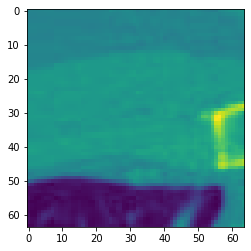

In [35]:
im = imageio.imread('/data/unet/train/images/img_out_LIDC-IDRI-0462_1_18_339.jpg')
#im = im.astype('float32')
plt.imshow(im)
np.unique(im)

Array([0.], dtype=float32)

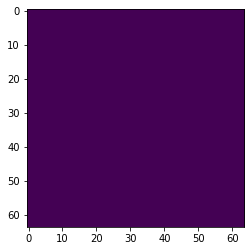

In [33]:
im = imageio.imread('/data/unet/train/masks/mask_out_LIDC-IDRI-0462_1_18_339.jpg')
im = im.astype('float32')
plt.imshow(im)
np.unique(im)

#### Define the Unet model

In [174]:
train_image_files = os.listdir('/data/unet/train/images/')
train_mask_files = [im_file.replace('img', 'mask') for im_file in train_image_files]

val_image_files = os.listdir('/data/unet/val/images/')
val_mask_files = [im_file.replace('img', 'mask') for im_file in val_image_files]


In [175]:
train_image_files[:5]

['img_LIDC-IDRI-0190_1_91.jpg',
 'img_out_LIDC-IDRI-0172_0_6_108.jpg',
 'img_out_LIDC-IDRI-0464_0_15_206.jpg',
 'img_LIDC-IDRI-0172_0_109.jpg',
 'img_out_LIDC-IDRI-0437_2_13_303.jpg']

In [179]:
from PIL import Image
class nodule_data(Dataset):
    def __init__(self,root_dir, image_paths,mask_paths):
        super().__init__()
        self.root_dir = root_dir
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        try:
            image = Image.open(self.root_dir + 'images/' + self.image_paths[index])
            mask = Image.open(self.root_dir + 'masks/' + self.mask_paths[index])
            mask = mask.convert('1')
            mask = np.array(mask)
            mask = mask.astype(np.uint8)
            image -= np.mean(image)
            image /= np.std(image)
        except:
            #issues loading image, return blank image and mask
            print("Found an issue with image {}".format(self.image_paths[index]))
            image = np.zeros([512, 512])
            mask = np.zeros([512, 512])
            mask = mask.astype(np.uint8)
            image -= np.mean(image)
            image /= np.std(image)
        return image[np.newaxis,:].astype('float32'), mask[np.newaxis,:].astype('float32')#, self.image_paths[index], self.mask_paths[index]
            

batch_size = 12
num_workers = 4

nodule_data_train = nodule_data('/data/unet/train/',train_image_files, train_mask_files)
val_loader = DataLoader(nodule_data_val, batch_size = batch_size,
                             num_workers = num_workers)

nodule_data_val = nodule_data('/data/unet/val/',val_image_files, val_mask_files)
train_loader = DataLoader(nodule_data_train, batch_size = batch_size,
                             num_workers = num_workers)

In [177]:
dataiter = iter(val_loader)
images,labels = dataiter.next()
print(images.dtype, labels.dtype)

torch.float32 torch.float32


In [178]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
print(images.dtype, labels.dtype)

torch.float32 torch.float32


In [139]:

images[1].shape

torch.Size([1, 64, 64])

#### Define the model

In [327]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
        self.relu1 = nn.ReLU()
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        self.relu2 = nn.ReLU()
        self.bn2   = nn.BatchNorm2d(out_ch)
    
    def forward(self, x):
        return self.bn2(self.relu2(self.conv2(self.bn1(self.relu1(self.conv1(x))))))
    

class Encoder(nn.Module):
    def __init__(self, chs=(1,32,64,128,256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64, 32)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
#            enc_ftrs = self.crop(encoder_features[i], x)
#            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = torch.cat([x, encoder_features[i]], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
#    def crop(self, enc_ftrs, x):
#        _, _, H, W = x.shape
#        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
#        return enc_ftrs

class Unet(nn.Module):
    def __init__(self, enc_chs=(1,32,64,128,256), dec_chs=(256, 128, 64, 32), num_class=1, retain_dim=False, out_sz=(64,64)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [328]:
print(torch.__version__)
print("Number of GPUs =", torch.cuda.device_count())

1.10.0a0+3fd9dcf
Number of GPUs = 1


In [329]:
model = Unet()
model = torch.nn.parallel.DataParallel(model, device_ids=[0]).cuda()

In [330]:
device = torch.device("cuda")

In [331]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
            Conv2d-4           [-1, 32, 64, 64]           9,248
              ReLU-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
             Block-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
           Conv2d-12           [-1, 64, 32, 32]          36,928
             ReLU-13           [-1, 64, 32, 32]               0
      BatchNorm2d-14           [-1, 64,

In [252]:
# DICE only for the images which has nodules in ground truth
def dice_coeff(y_true, y_pred):
    smooth = 0.0001
    #print('label shape=', y_true.ndim)
    if y_true.ndim == 2:
        y_true = y_true[np.newaxis,:,:]
    true_nodules = torch.sum(y_true, dim=[1,2])
    idxs = torch.where(true_nodules>0)
    y_true = y_true[idxs]
    y_pred = y_pred[idxs]
    if idxs[0].shape[0] <=0:
        return torch.tensor(0.0)
    else:
    #return torch.mean( (2. * torch.sum(y_true * y_pred, dim=1) + smooth) / (torch.sum(y_true, dim=1) + torch.sum(y_pred, dim=1) + smooth) )
        return torch.mean((2. *torch.sum(y_true * y_pred, dim = [1,2]) + smooth)/(torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2]) + smooth), dim=[0])

In [213]:
# DICE when using images with nodules as well as blank images
def dice_coeff_2(y_true, y_pred):
    smooth = 0.0001
    #return torch.mean( (2. * torch.sum(y_true * y_pred, dim=1) + smooth) / (torch.sum(y_true, dim=1) + torch.sum(y_pred, dim=1) + smooth) )
    return torch.mean((2. *torch.sum(y_true * y_pred, dim = [1,2]) + smooth)/(torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2]) + smooth), dim=[0])

#### Configure metrics logging in tensorboard

In [258]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/unet_lidc_2')

In [282]:
def get_next_rundir():
    dirs = os.listdir('runs')
    idx = np.sort([int(d.split('_')[2]) for d in dirs])[-1]
    newdirname = 'runs/unet_lidc_{}'.format(idx+1)
    return newdirname

In [283]:
get_next_rundir()

'runs/unet_lidc_3'

In [332]:
def train(train_epochs):
    
    num_epochs = train_epochs
    criterion  = nn.BCEWithLogitsLoss()
    optimizer  = torch.optim.Adam(model.parameters(),0.0001)
    
    rundir = get_next_rundir()
    writer = SummaryWriter(rundir)
    
    train_loss = []
    val_loss   = []
    best_dice = 0
    best_loss = 1
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        running_loss = 0.0
        batch_dice_score = []
        epoch_dice_score = []
        start = time.time()
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            curr_loss = loss.item()
            running_loss += curr_loss
            epoch_loss += curr_loss

            # begin: DICE score
            #mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
            mask_pre_prob = torch.sigmoid(outputs)#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            batch_dice_score.append(score)
            epoch_dice_score.append(score)
            # end: DICE score

            if i % 100 == 99: # every 10 minibatch
                writer.add_scalar('training loss', running_loss/100, epoch * len(train_loader) + i)
                writer.add_scalar('training dice', torch.mean(torch.from_numpy(np.array(batch_dice_score))), epoch * len(val_loader) + i)
                running_loss = 0.0
                batch_dice_score = []

        epoch_loss /= i+1
        train_loss.append(epoch_loss)
        epoch_dice_score = torch.mean(torch.from_numpy(np.array(epoch_dice_score)))

        end = time.time()
        print(f"Epoch {epoch} trained with loss: {epoch_loss}, and dice score {epoch_dice_score}. The running time is {end-start}.")

        model.eval()
        running_loss = 0.0
        epoch_loss = 0.0
        running_score = 0.0
        start = time.time()
        batch_dice_score = []
        epoch_dice_score = []
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float())
                curr_loss = loss.item()
                running_loss += curr_loss
                epoch_loss += curr_loss

                # begin: DICE score
                #mask_pre_prob = torch.sigmoid(seg_model(inputs))#.detach().cpu().numpy()
                mask_pre_prob = torch.sigmoid(outputs)#.detach().cpu().numpy()
                outputs = np.squeeze(mask_pre_prob).detach().cpu()
                mask_pre = np.where(outputs>0.5, 1,0)
                mask_pre = torch.from_numpy(mask_pre)
                score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
                batch_dice_score.append(score)
                epoch_dice_score.append(score)
                # end: DICE score

                if i % 100 == 99: # every 10 minibatch
                    writer.add_scalar('eval loss', running_loss/100, epoch * len(val_loader) + i)
                    writer.add_scalar('eval dice', torch.mean(torch.from_numpy(np.array(batch_dice_score))), epoch * len(val_loader) + i)
                    running_loss = 0.0
                    batch_dice_score = []

        epoch_loss /= i+1
        #running_score /= i+1
        val_loss.append(epoch_loss)
        end = time.time()
        epoch_dice_score = torch.mean(torch.from_numpy(np.array(epoch_dice_score)))
        print(f"Epoch {epoch} evaluated with loss: {epoch_loss}, and dice score: {epoch_dice_score}. The running time is {end-start}.")

        #if running_loss == min(val_loss):
        PATH = f'{rundir}/Epoch{epoch}.pth'
        torch.save(model.state_dict(),PATH)
        print('Last model saved at epoch:', epoch)
        if epoch_dice_score > best_dice:
            best_dice = epoch_dice_score
            PATH = f'{rundir}/best_{epoch}.pth'
            torch.save(model.state_dict(),PATH)
            print('Best model saved at epoch:', epoch)

    print("Training is completed.")

In [333]:
train(60)

Epoch 0 trained with loss: 0.47013317303177204, and dice score 0.5109730362892151. The running time is 31.832042694091797.
Epoch 0 evaluated with loss: 0.23639988563344128, and dice score: 0.6299135088920593. The running time is 2.3390960693359375.
Last model saved at epoch: 0
Best model saved at epoch: 0
Epoch 1 trained with loss: 0.12851704966445315, and dice score 0.6226833462715149. The running time is 33.14025926589966.
Epoch 1 evaluated with loss: 0.062381498927830674, and dice score: 0.6676416397094727. The running time is 2.265815258026123.
Last model saved at epoch: 1
Best model saved at epoch: 1
Epoch 2 trained with loss: 0.04512840299000171, and dice score 0.6722564101219177. The running time is 32.064438581466675.
Epoch 2 evaluated with loss: 0.039964214448252176, and dice score: 0.6960383057594299. The running time is 2.346827268600464.
Last model saved at epoch: 2
Best model saved at epoch: 2
Epoch 3 trained with loss: 0.02873372825226707, and dice score 0.682361543178558

In [339]:
ls runs/unet_lidc_9/

Epoch0.pth   Epoch3.pth   Epoch50.pth
Epoch1.pth   Epoch30.pth  Epoch51.pth
Epoch10.pth  Epoch31.pth  Epoch52.pth
Epoch11.pth  Epoch32.pth  Epoch53.pth
Epoch12.pth  Epoch33.pth  Epoch54.pth
Epoch13.pth  Epoch34.pth  Epoch55.pth
Epoch14.pth  Epoch35.pth  Epoch56.pth
Epoch15.pth  Epoch36.pth  Epoch57.pth
Epoch16.pth  Epoch37.pth  Epoch58.pth
Epoch17.pth  Epoch38.pth  Epoch59.pth
Epoch18.pth  Epoch39.pth  Epoch6.pth
Epoch19.pth  Epoch4.pth   Epoch7.pth
Epoch2.pth   Epoch40.pth  Epoch8.pth
Epoch20.pth  Epoch41.pth  Epoch9.pth
Epoch21.pth  Epoch42.pth  best_0.pth
Epoch22.pth  Epoch43.pth  best_1.pth
Epoch23.pth  Epoch44.pth  best_15.pth
Epoch24.pth  Epoch45.pth  best_2.pth
Epoch25.pth  Epoch46.pth  best_21.pth
Epoch26.pth  Epoch47.pth  best_3.pth
Epoch27.pth  Epoch48.pth  best_9.pth
Epoch28.pth  Epoch49.pth  events.out.tfevents.1636723222.83e20fad0afe.408.9
Epoch29.pth  Epoch5.pth


In [341]:
from tqdm import tqdm
def calculate_dice_score_eval(model, loader):
    batch_dice_score = []
    least_dice = 1
    least_label = None
    least_pre = None
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            mask_pre_prob = torch.sigmoid(model(inputs))#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            if score < least_dice:
                least_dice = score
                least_label = labels
                least_pre = mask_pre
            batch_dice_score.append(score)
            if (i % 100) == 0:
                print("Accumulated dice coeff {}".format(torch.mean(torch.from_numpy(np.array(batch_dice_score)))))
    final_score = torch.mean(torch.from_numpy(np.array(batch_dice_score)))
    print("dice score: {}".format(final_score))
    return final_score, least_dice, least_label, least_pre

In [342]:
seg_model = Unet()
seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0]).cuda()
seg_model.load_state_dict(torch.load('runs/unet_lidc_9/best_21.pth'))
seg_model.eval()
final_score, least_dice, least_label, least_pre = calculate_dice_score_eval(seg_model, val_loader)
print("Final val dice score = {}".format(final_score))

17it [00:00, 83.27it/s]

Accumulated dice coeff 0.8229115605354309


123it [00:01, 114.72it/s]

Accumulated dice coeff 0.7568582892417908


215it [00:01, 126.92it/s]

Accumulated dice coeff 0.7387306690216064


244it [00:02, 113.71it/s]

dice score: 0.7386075854301453
Final val dice score = 0.7386075854301453


In [336]:
test_image_files = os.listdir('/data/unet/test/images/')
test_mask_files = [im_file.replace('img', 'mask') for im_file in test_image_files]
nodule_data_test = nodule_data('/data/unet/test/',test_image_files, test_mask_files)
test_loader = DataLoader(nodule_data_test, batch_size = batch_size,
                             num_workers = num_workers)

In [344]:
seg_model = Unet()
seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0]).cuda()
seg_model.load_state_dict(torch.load('runs/unet_lidc_9/best_21.pth'))
seg_model.eval()
final_score, least_dice, least_label, least_pre  = calculate_dice_score_eval(seg_model, test_loader)
print("Final test dice score = {}".format(final_score))

17it [00:00, 84.46it/s]

Accumulated dice coeff 0.6739959120750427


112it [00:01, 103.62it/s]

Accumulated dice coeff 0.673153281211853
dice score: 0.662816047668457
Final test dice score = 0.662816047668457


### Check how well we are predicting

In [191]:
cohort = '/data/unet/val/images/'
patient_test_list = os.listdir(cohort)

In [190]:
patient_test_list

['img_out_LIDC-IDRI-0911_0_5_118.jpg',
 'img_out_LIDC-IDRI-0039_0_7_120.jpg',
 'img_out_LIDC-IDRI-0963_0_5_214.jpg',
 'img_LIDC-IDRI-0720_0_148.jpg',
 'img_LIDC-IDRI-0368_1_43.jpg',
 'img_LIDC-IDRI-0982_0_375.jpg',
 'img_LIDC-IDRI-0526_1_59.jpg',
 'img_random_LIDC-IDRI-0515_0_178.jpg',
 'img_LIDC-IDRI-0549_0_88.jpg',
 'img_out_LIDC-IDRI-0447_0_0_64.jpg',
 'img_out_LIDC-IDRI-0879_0_1_106.jpg',
 'img_LIDC-IDRI-0346_0_42.jpg',
 'img_random_LIDC-IDRI-0011_0_30.jpg',
 'img_out_LIDC-IDRI-0093_0_0_55.jpg',
 'img_out_LIDC-IDRI-0368_2_7_67.jpg',
 'img_out_LIDC-IDRI-0368_2_5_66.jpg',
 'img_out_LIDC-IDRI-0673_0_10_199.jpg',
 'img_out_LIDC-IDRI-0866_2_3_105.jpg',
 'img_LIDC-IDRI-0549_0_91.jpg',
 'img_out_LIDC-IDRI-0982_0_13_373.jpg',
 'img_LIDC-IDRI-0583_1_219.jpg',
 'img_LIDC-IDRI-0543_1_422.jpg',
 'img_LIDC-IDRI-0209_0_47.jpg',
 'img_out_LIDC-IDRI-0439_0_7_81.jpg',
 'img_LIDC-IDRI-0039_2_131.jpg',
 'img_out_LIDC-IDRI-0368_2_8_68.jpg',
 'img_out_LIDC-IDRI-0332_1_6_163.jpg',
 'img_out_LIDC-IDRI-02

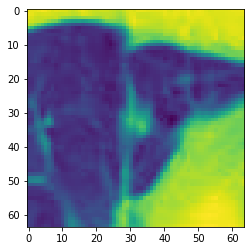

In [194]:
img = Image.open(cohort + "img_LIDC-IDRI-0526_1_59.jpg")
plt.imshow(img)

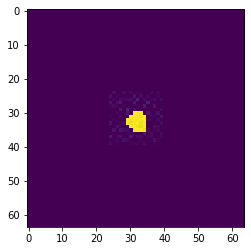

In [195]:
img = Image.open('/data/unet/val/masks/' + "mask_LIDC-IDRI-0526_1_59.jpg")
plt.imshow(img)

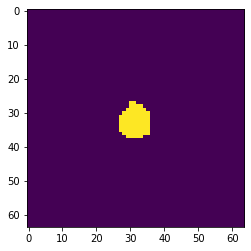

In [199]:
img = Image.open(cohort + "img_LIDC-IDRI-0526_1_59.jpg")
image = np.array(img).astype('float32')#vol[:,:,k_slice].astype('float32')
image -= np.mean(image)
image /= np.std(image)
image = torch.from_numpy(image[np.newaxis,np.newaxis,:]).to(device)
mask_pre = torch.sigmoid(model(image)).detach().cpu().numpy()
mask_pre = np.squeeze(mask_pre)
#  print(np.max(mask_pre), np.min(mask_pre))
#  print(np.max(CT_mask[:,:,k_slice]), np.min(CT_mask[:,:,k_slice]))
mask_pre = np.where(mask_pre>0.5, 1,0)
plt.imshow(mask_pre)

In [ ]:
%matplotlib inline

cohort = data_folder
patient_list = os.listdir(cohort)
patient_select = 0

print ("Current patient ID =", patient_list[patient_select])

scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    if i==0:
        plt.title('Image',fontsize=16)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])
    if i==0:
        plt.title('GT mask',fontsize=16)

    plt.subplot(nodule_num,3,3+i*3)
    image = vol[:,:,k_slice].astype('float32')
    image -= np.mean(image)
    image /= np.std(image)
    image = torch.from_numpy(image[np.newaxis,np.newaxis,:]).to(device)
    mask_pre = torch.sigmoid(model(image)).detach().cpu().numpy()
    mask_pre = np.squeeze(mask_pre)
  #  print(np.max(mask_pre), np.min(mask_pre))
  #  print(np.max(CT_mask[:,:,k_slice]), np.min(CT_mask[:,:,k_slice]))
    mask_pre = np.where(mask_pre>0.5, 1,0)
    plt.imshow(mask_pre)
    if i==0:
        plt.title('Predicted mask',fontsize=16)